In [1]:
# Importing everything we need 
# The usual packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

# for timing model fitting iterations inside of loops
from time import time

# model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV

# Scalars
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import calinski_harabasz_score

Now we're ready to move into the clustering modeling stage. Given that we don't know the underlying distribution of our potential clusters in the data, we've decided to go with the following clustering methods that address different assumptions of clustering distributions<sup>1</sup>:
- K-Means: partitioning method
    - partitions the data in that it assigns every point to a cluster
    - assumes that clusters are convex-shaped, meaning, spherical clusters
    - doesn't handle noise or outliers well
- DBSCAN: density-based method
    - doesn't have the assumption that clusters are convex-shaped
    - considers noise data
- HDBSCAN: density-based method
    - similar to DBSCAN, but applies to clusters of different densities
- Agglomerative clustering: hierarchical clustering method (bottom-up appraoch) where each data point starts as its own cluster but gets merged with one another based on similarity
    - assumes that clusters are convex-shaped, meaning, spherical clusters

Then, we'll validate the different models we run using internal and external validation <sup>2</sup>. Ultimately, we do validation so that we achieve some quality in the clustering, as defined by high within-cluster similarity and low between-cluster similarity. In other words, well-defined clusters are dense/compact and well-separated. Please note that these internal validation metrics aren't perfect in that they aren't applicable to all clustering algorithms. For example, silhouette scores or Calinski Harabasz indices aren't the best metrics to use for density-based clustering because density-based clustering assumes clusters aren't convex-shaped. Throughout the model iteration process, we'll look at these internal evaluation metrics for reference but heuristically.

    Internal evaluation metrics:
        - Inertia/within-cluster sum-of-squares (WSS)
            - only applies to K-Means
        - Silhouette Score
            - typically is higher when clusters are convex-shaped
        - Calinski_Harabasz
            - typically is higher when clusters are convex-shaped


We'll use external evaluation metrics to see the similarity between clusters found by different clustering models and from there, analyze any interesting patterns or structures in distinct or well-defined clusters.

    External evaluation metrics:
        - Adjusted Rand Index
        - Adjusted Mutual Information Score

In [140]:
# load data

df_final2 = pd.read_csv('data/df_model_cluster.csv', index_col=[0])

df_final2.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_neoplasms,diag_3_other,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [141]:
# check 

df_final2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69989 entries, 2 to 101765
Data columns (total 58 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   time_in_hospital                                   69989 non-null  float64
 1   num_lab_procedures                                 69989 non-null  float64
 2   num_procedures                                     69989 non-null  float64
 3   num_medications                                    69989 non-null  float64
 4   number_outpatient                                  69989 non-null  float64
 5   number_emergency                                   69989 non-null  float64
 6   number_inpatient                                   69989 non-null  float64
 7   number_diagnoses                                   69989 non-null  float64
 8   num_med_changes                                    69989 non-null  float64
 9   age_[

### K-Means

K-Means is an algorithm that looks to minimize the within-cluster sum of squares (WSS), or the within-cluster variation. It requires us to pre-specify a value for `n_clusters` parameter, so let's run a for loop through a range of `n_clusters` values and use some heuristics to determine the optimal value. `n_clusters` is the number of clusters that gets returned by the algorithm; in the code and graphs below, `n_clusters` and *k* are used interchangeably.

In [931]:
%%time

# range of n_clusters = 2-10
ks = np.arange(2,11)

# lists that we will append evaluation metrics to
inertia_list = list()
silhouette_list = list()
c_h_list = list()

for k in ks:

    # Instantiate
    my_kmeans = KMeans(n_clusters=k, n_jobs=-1)
    
    # Fit (i.e. get clusters)
    my_kmeans.fit(df_final2)
    
    # Append inertia
    inertia_list.append(my_kmeans.inertia_)
    
    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, my_kmeans.labels_))
       
    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, my_kmeans.labels_))

CPU times: user 15min 16s, sys: 4min 17s, total: 19min 33s
Wall time: 20min 53s


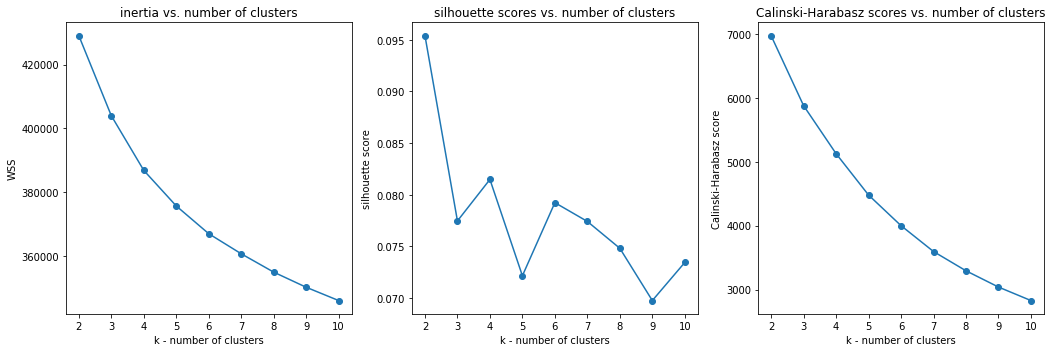

In [932]:
plt.subplots(1,3,figsize=(15,5))

# Visualize the elbow plot
plt.subplot(1,3,1)
plt.plot(ks, inertia_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('WSS')
plt.title('inertia vs. number of clusters')
plt.xticks(ks)

# Visualize the silhouette plot
plt.subplot(1,3,2)
plt.plot(ks, silhouette_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(ks)

# Visualize the C-H plot
plt.subplot(1,3,3)
plt.plot(ks, c_h_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(ks)

plt.tight_layout()
plt.show()

Let's interpret the results of these validation metrics:

**Inertia**

In an ideal situation, we would find a "bend" in the inertia graph where it would inform us where is the most optimal `n_clusters` to set the model at. As the within-cluster sum of squares (WSS) around the cluster means decreases and the number of clusters increases, eventually the decrease in WSS flattens after a certain number of clusters. Where that flattening occurs, or where the magnitude of the decrease starts dropping, is the "bend" that indicates the optimal number. In this particular graph, it's difficult to discern where the "bend" is, though perhaps around `n_clusters` of 4 or 5.

**Silhouette score**

The silhouette score is bound between -1 and 1, with a higher silhouette score indicating that the model has well-defined clusters. Its calculation is based on within-cluster distances and between-cluster distances. Ideally we would want the score to be above 0, since a score of around 0 means there are overlapping clusters. In our particular graph, `n_clusters` of 2, or 4, looks to be an optimal value.

**Calinski-Harabasz score**

A higher Calinski-Harabasz score is associated with well-defined clusters. It's a variance ratio measure, meaning, it measures the ratio between within-cluster sum of squares and between-cluster sum of squares. In the graph we have, the highest score occurs at `n_cluster` of 2.

There are additional internal validation metrics that we've looked at, but we've done so in R because R has nice packages like `Nbclust` that provides 30 indices on determining the optimal value of `n_cluster`. A subjective method we'll do here is seeing what optimal cluster number gets determined by each index, and see which optimal cluster value comes up the most. We won't provide detailed explanations for each index below as we've done above (except for gap statistic), but we've provided the R code and the optimal value result (found under $Best.nc in the R code). *Check file Rscript_ClusterAnalysisIndices.R as well.*

**Gap statistic**<sup>3<sup/>

One advantage of gap statistic is that it doesn't have the same assumptions as some of the other indices do regarding the shapes of the clusters. What it does is it compares the within-cluster dissimilarity for a clustering of the data with that of a bootstrapped sample of data, where there will be a gap between observed value and expected value. The optimal number of clusters is the smallest number producing a gap within one standard error of the number of clusters that minimizes the gap. R has a `clusGap` function that we can use to calculate the gap statistic. In this case, it determines that the optimal number of clusters is 1, but we can also say the optimal number of clusters is 5 since typically it can say it's 1 at the first local maximum.
    <div>
        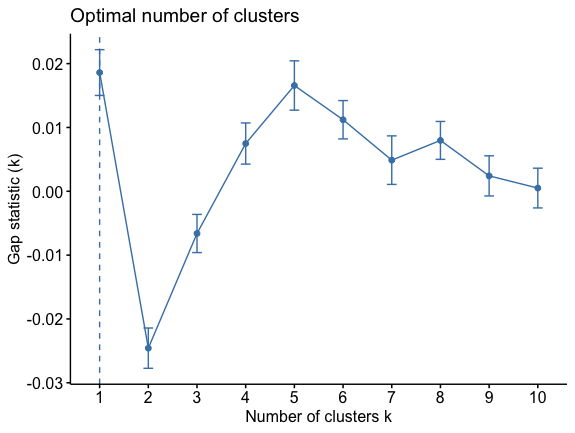
    </div>

**Ball**
    <div>
        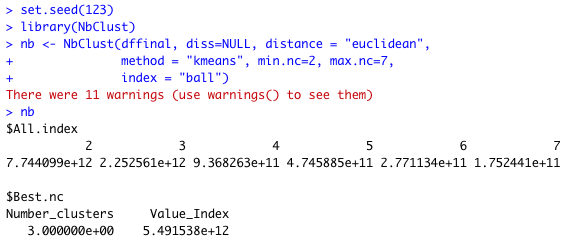
    </div>

**Beale**
    <div>
        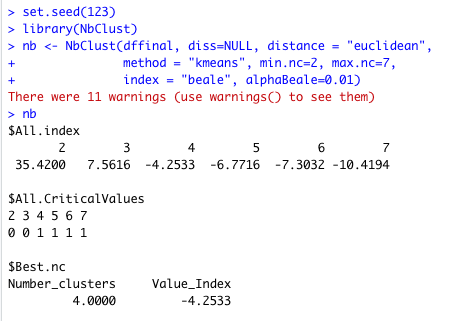
    </div>

**Duda**
    <div>
        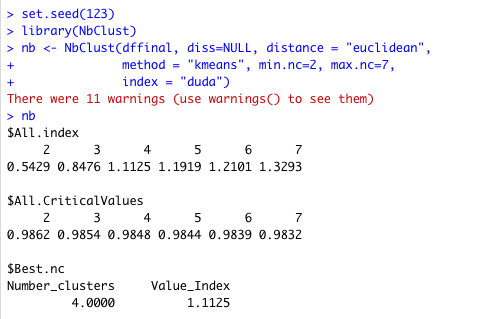
    </div>
    
**Pseudot2**
    <div>
        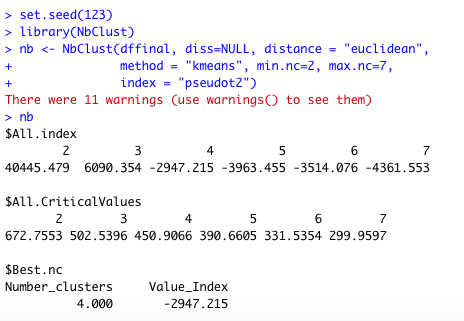
    </div>

**Ratowsky**
    <div>
        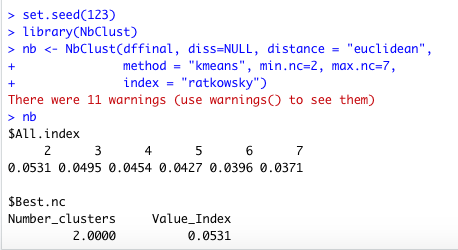
    </div>

**Sdbw**
    <div>
        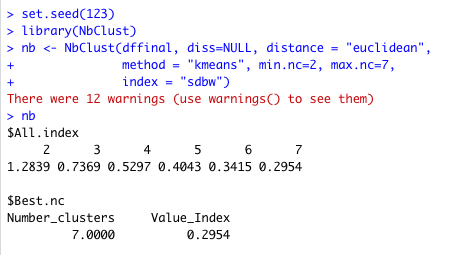
    </div>

**SD index**
    <div>
        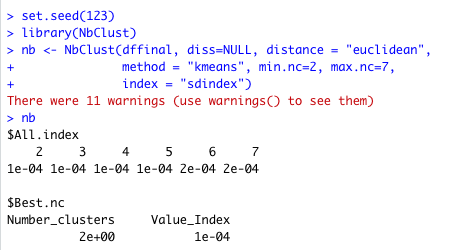
    </div>

Based on the findings from all the indices, let's model a K-Means with `n_cluster` of 4.

In [3]:
%%time

# Instantiate
my_kmeans_final = KMeans(n_clusters=4, n_jobs=-1)

# Fit
my_kmeans_final.fit(df_final2)

CPU times: user 165 ms, sys: 173 ms, total: 339 ms
Wall time: 7.19 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [4]:
# cluster labels count

my_kmeans_final.labels_.shape

(69989,)

Let's now add these K-Means cluster labels to the dataframe.

In [5]:
# copy dataframe first

df_final_labels = df_final2.copy()

# append k-means cluster labels to the dataframe

df_final_labels['kmeans'] = my_kmeans_final.labels_

In [6]:
df_final_labels.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_other,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0


### DBSCAN

For DBSCAN, the hyperparameters that matter are `eps` and `min_samples`. 

- `eps` = the distance that specifies the neighbors; two points are considered to be neighbors if the distance between them are less than or equal to `eps`.
- `min_samples` = minimum number of data points to define a cluster.

One method to find the optimal `eps` value is using NearestNeighbors<sup>4,5</sup> as an unsupervised learning method. Then we plot what is called the KNN distance plot and find the "bend" again that indicates the optimal value for `eps`.

In [143]:
%%time

from sklearn.neighbors import NearestNeighbors

# instantiate; n_neighbors arbitrarily set at 50

neigh = NearestNeighbors(n_neighbors=50, n_jobs=-1)

# fit

nbrs = neigh.fit(df_final2)

# return two arrays: distances, indices
# distances = the distance to the closest n_neighbors points 
# indices = the index for each of those points

distances, indices = nbrs.kneighbors(df_final2)

CPU times: user 22min 29s, sys: 11.6 s, total: 22min 41s
Wall time: 13min 55s


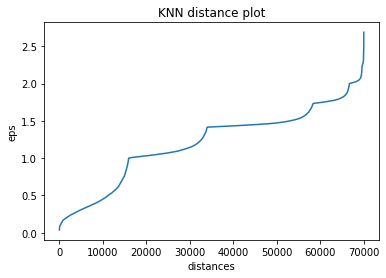

In [144]:
# sort the results
# note that this is just a plot for distances[:,2]; we could do this for other indices since we have n_neighbors=50

distanceDec = sorted(distances[:,2])

# plot the sorted results

plt.figure()
plt.plot(list(range(1,69990)), distanceDec)
plt.ylabel('eps')
plt.xlabel('distances')
plt.title('KNN distance plot')
plt.show()

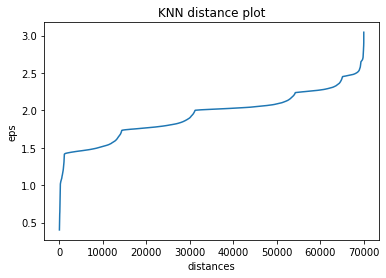

In [145]:
# sort the results

distanceDec = sorted(distances[:,49])

# plot the sorted results

plt.figure()
plt.plot(list(range(1,69990)), distanceDec)
plt.ylabel('eps')
plt.xlabel('distances')
plt.title('KNN distance plot')
plt.show()

The threshold point is the first point in the first valley of the sorted k-dist graph

Since the above k-neighbors graphs are vague on what the optimal value for eps should be, in that we see more than one "bend", let's do a for-loop through a range of `eps` values, hold `min_samples` constant at some value, and find the optimal `eps` value based on heuristics. We're doing this instead of doing two nested for loops (for `eps` and `min_samples`) to lessen run time.

In [924]:
%%time

# specify a range of eps values to loop through
eps = [1.5, 2, 2.5]

# create empty lists to append scores to 
silhouette_list = list()
c_h_list = list()

for e in eps:

    # Instantiate
    # hold min_samples constant = 50
    my_db = DBSCAN(eps=e, min_samples=50, n_jobs=-1)

    # Fit (i.e. get clusters)
    my_db.fit(df_final2)

    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, my_db.labels_))

    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, my_db.labels_))

CPU times: user 1h 28min 16s, sys: 1min 58s, total: 1h 30min 14s
Wall time: 40min 34s


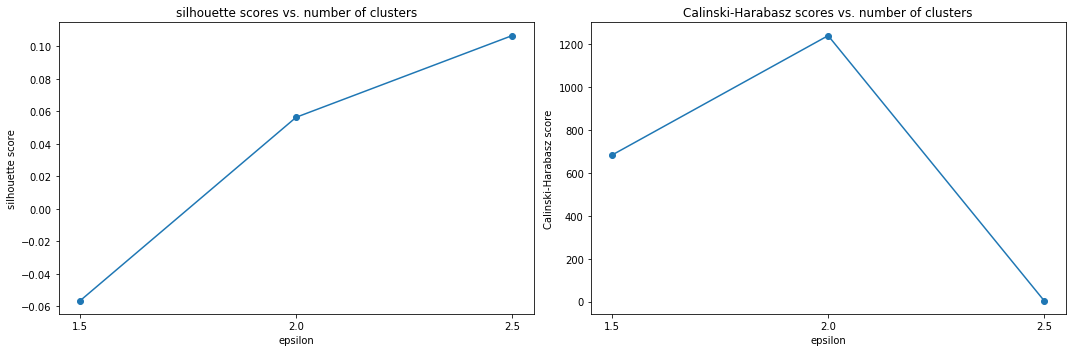

In [925]:
plt.subplots(1,2,figsize=(15,5))

# visualize the silhouette plot
plt.subplot(1,2,1)
plt.plot(eps, silhouette_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(eps)

# visualize the C-H plot
plt.subplot(1,2,2)
plt.plot(eps, c_h_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(eps)

plt.tight_layout()
plt.show()

We recognize that these internal validation metrics may not be the best to use for DBSCAN as we've mentioned in our intro, so let's view these for direction. Taking both silhouette score and Calinski-Harabasz into consideration, the suggested `eps` = 2 looks like it's the optimal value.

What if this time we loop through the same `eps` values but increase `min_samples` to 70 and hold that constant?

In [926]:
%%time

# specify a range of eps values to loop through
eps = [1.5, 2, 2.5]

# create empty lists to append scores to 
silhouette_list = list()
c_h_list = list()

for e in eps:

    # Instantiate
    # hold min_samples constant = 70
    my_db = DBSCAN(eps=e, min_samples=70, n_jobs=-1)

    # Fit (i.e. get clusters)
    my_db.fit(df_final2)

    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, my_db.labels_))

    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, my_db.labels_))

CPU times: user 1h 35min, sys: 3min 1s, total: 1h 38min 1s
Wall time: 1h 1min 2s


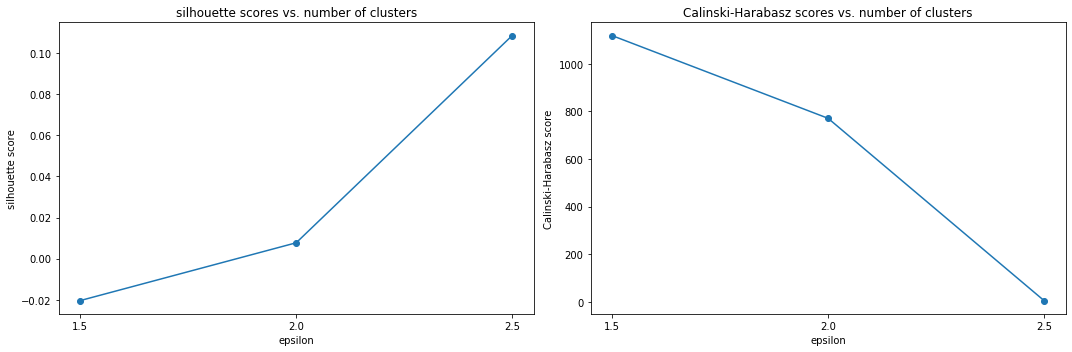

In [927]:
plt.subplots(1,2,figsize=(15,5))

# visualize the silhouette plot
plt.subplot(1,2,1)
plt.plot(eps, silhouette_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(eps)

# visualize the C-H plot
plt.subplot(1,2,2)
plt.plot(eps, c_h_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(eps)

plt.tight_layout()
plt.show()

Notice that at the same `eps` of 2, both indices have dropped when `min_samples` is increased to 70. At `eps` = 1.5, the two graphs are also offering conflicting information. 

Would the indices improve if we maintain the same `eps` values but reduce `min_samples` to 40 then?

In [950]:
%%time

# specify a range of eps values to loop through
eps = [1.5, 2, 2.5]

# create empty lists to append scores to 
silhouette_list = list()
c_h_list = list()

for e in eps:

    # Instantiate
    my_db = DBSCAN(eps=e, min_samples=40, n_jobs=-1)

    # Fit (i.e. get clusters)
    my_db.fit(df_final2)

    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, my_db.labels_))

    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, my_db.labels_))

CPU times: user 1h 29min 8s, sys: 2min 35s, total: 1h 31min 44s
Wall time: 39min 14s


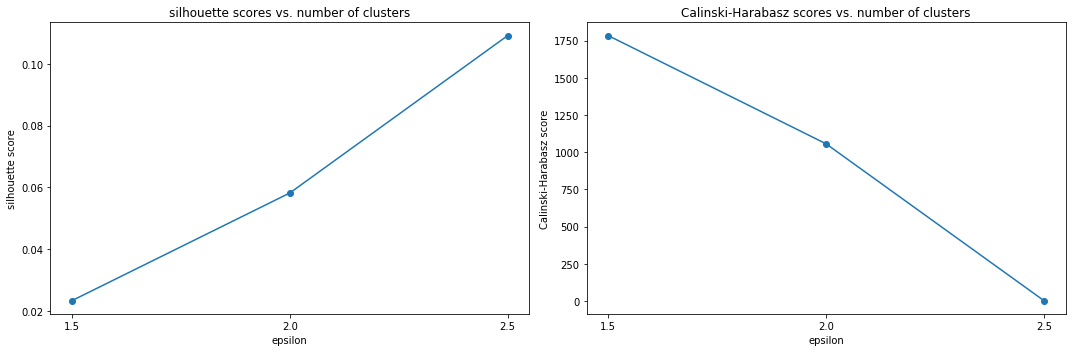

In [951]:
plt.subplots(1,2,figsize=(15,5))

# visualize the silhouette plot
plt.subplot(1,2,1)
plt.plot(eps, silhouette_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(eps)

# visualize the C-H plot
plt.subplot(1,2,2)
plt.plot(eps, c_h_list, marker='o')
plt.xlabel('epsilon')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(eps)

plt.tight_layout()
plt.show()

At this point, we'll stop the manual hyperparameter tuning since these heuristics aren't showing much improvement. Let's just go ahead and see what DBSCAN returns for the clusters.

In [953]:
# number of clusters returned

len(pd.Series(my_db.labels_).value_counts().index) 

2

In [954]:
# number of outliers

display(my_db.labels_[my_db.labels_ == -1].size)

# number of points that are clustered

display(my_db.labels_[my_db.labels_ != -1].size)

6

69983

DBSCAN finds 2 clusters, but the results aren't what we want because 1 cluster is noise (as indicated by -1) and the rest of the datapoints are grouped in another. This might be because the heuristics we're using have assumptions that align with partition-based algorithms. We're going to ignore DBSCAN results and proceed with HDBSCAN and see if its specific hyperparameter tuning methods available to us will help us.

### HDBSCAN

For HDBSCAN, the hyperparameters<sup>6</sup> we care about are:

- `min_cluster_size`: This is the minimum size that you consider as a cluster; increasing the size means reducing the number of clusters
- `min_samples`: This measures how conservative you want your clusters to be; the larger the value, the more conservative the clusters are, and therefore more points may be considered noise. By default, `min_samples` is the same as `min_cluster_size`.

Let's arbitrarily start with `min_cluster_size` as 50 and `min_samples` = 10.

In [958]:
%%time

# instantiate

h_db = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)

# fit

h_db.fit(df_final2)

CPU times: user 3min 17s, sys: 2.15 s, total: 3min 19s
Wall time: 6min 2s


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=10, p=None,
        prediction_data=False)

In [959]:
# get the number of clusters found by finding the largest cluster label

h_db.labels_.max()

22

In [960]:
# sizes of each cluster

pd.Series(h_db.labels_).value_counts()

-1     59476
 20     3467
 22     2232
 21     1654
 7       558
 2       362
 13      271
 18      261
 14      189
 8       186
 0       165
 19      144
 12      135
 11      124
 9       108
 15      101
 5        99
 17       89
 6        69
 1        67
 16       60
 3        59
 10       57
 4        56
dtype: int64

This number of clusters (24, including cluster of -1) is more than what we would like. Also, it's concerning that the largest cluster is noise data. Let's plot out the condensed tree<sup>7</sup>, which gives us a visualization of the cluster hierarchy. It shows the cluster hierarchy as a dendrogram. `select_clusters`=True will show us which branches were selected by the algorithm.

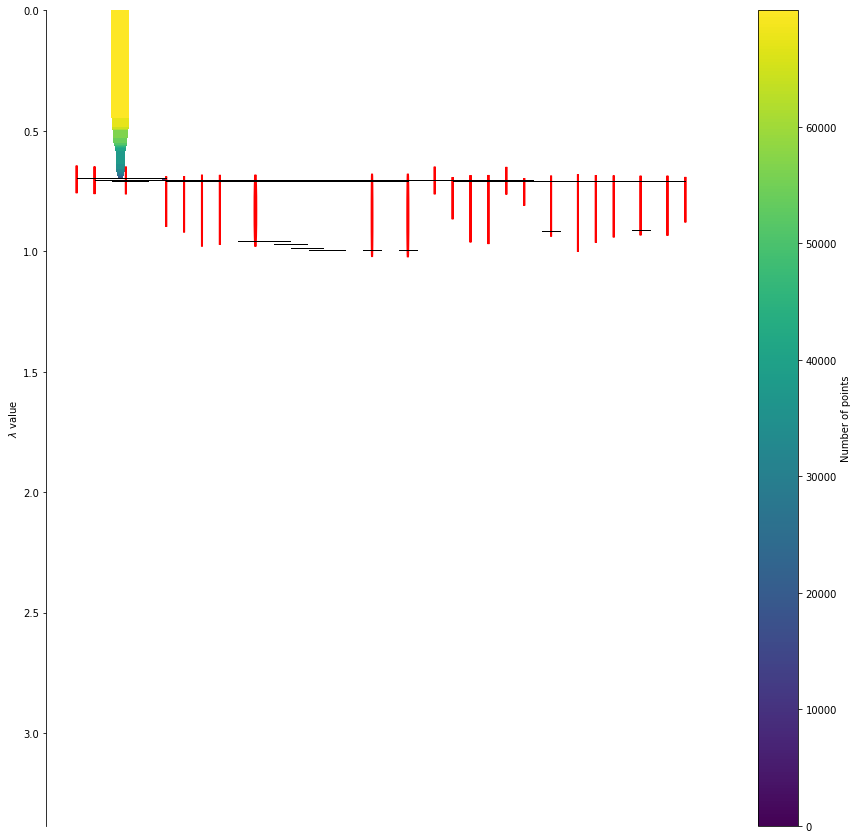

In [961]:
# plot condensed tree

plt.figure(figsize=(15,15))
h_db.condensed_tree_.plot(
    select_clusters=True, 
    selection_palette=sns.color_palette('deep',8))
plt.show()

Our condensed tree is difficult to interpret, which is not surprising given that we have 23 clusters (including the noise cluster). Given that we can't see the colors of the bars anymore, it means the cluster hierarchy is complex. One way to address this is to increase `min_cluster_size` to reduce the number of clusters returned, so we'll increase it from 50 to 70, but keep `min_samples` constant at 10.

In [965]:
%%time

# instantiate

h_db = hdbscan.HDBSCAN(min_cluster_size=70, min_samples=10)

# fit

h_db.fit(df_final2)

CPU times: user 3min 17s, sys: 1.51 s, total: 3min 18s
Wall time: 5min 52s


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=70, min_samples=10, p=None,
        prediction_data=False)

In [966]:
# get the number of clusters found by finding the largest cluster label

h_db.labels_.max()

16

In [967]:
# sizes of each cluster

pd.Series(h_db.labels_).value_counts()

-1     59844
 14     3467
 16     2232
 15     1654
 3       558
 1       362
 8       271
 12      261
 9       189
 4       186
 0       165
 13      144
 7       135
 6       124
 5       108
 10      101
 2        99
 11       89
dtype: int64

The number of clusters has reduced but we notice that the noise cluster now has ~400 more data points compared to the last iteration. Let's do one last iteration but increase both `min_cluster_size` and `min_samples`. It's likely though that noise data remains the largest cluster based on the last iterations we see.

In [968]:
%%time

# instantiate

h_db = hdbscan.HDBSCAN(min_cluster_size=110, min_samples=50)

# fit

h_db.fit(df_final2)

CPU times: user 55.2 s, sys: 1.22 s, total: 56.4 s
Wall time: 4min 8s


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=110, min_samples=50, p=None,
        prediction_data=False)

In [969]:
# get the number of clusters found by finding the largest cluster label

h_db.labels_.max()

4

In [970]:
# sizes of each cluster

pd.Series(h_db.labels_).value_counts()

-1    68017
 1      758
 2      469
 3      300
 0      259
 4      186
dtype: int64

This is not very meaningful when the largest cluster continues to be noise data after some manual hyperparameter tuning. Let's ignore the results from HDBSCAN as well and move on to Agglomerative Clustering.

### Agglomerative Clustering

With hierarchical clustering, we don't have the notion of neighbors, which means any point can be linked to any other point. This is where the concept of connectivity comes in. We can add a connectivity constraint to the algorithm. Scikit-learn also explains it well:

_These constraint are useful to impose a certain local structure, but they also make the algorithm faster, especially when the number of the samples is high. The connectivity constraints are imposed via an connectivity matrix: a scipy sparse matrix that has elements only at the intersection of a row and a column with indices of the dataset that should be connected. This matrix can be constructed from a-priori information: for instance, you may wish to cluster web pages by only merging pages with a link pointing from one to another._

We'll create the connectivity matrix using the kneighbors_graph<sup>8</sup>.

In [973]:
%%time

from sklearn.neighbors import kneighbors_graph

# n_neighbors = 20 is chosen arbitrarily

connectivity = kneighbors_graph(df_final2, n_neighbors=20, metric='euclidean', include_self=False, n_jobs=-1)

CPU times: user 44min 20s, sys: 24.3 s, total: 44min 44s
Wall time: 16min 7s


Then we'll use connectivity from above in our first iteration of Agglomerative clustering. We're going to loop through a range of `n_cluster` values and try to find the optimal number using internal validation metrics such as silhouette score and Calinski Harabasz score. We decide to not use a dendrogram in determining the optimal number of clusters since there's some subjectivity involved when looking at the dendrogram visually. Granted, internal validation metrics are used for directional guidance as well.

In [974]:
%%time

# range of n_clusters = 2-10
ks = np.arange(2,11)

# lists that we will append evaluation metrics to
silhouette_list = list()
c_h_list = list()

for k in ks:

    # Instantiate
    agg = AgglomerativeClustering(n_clusters=k, connectivity=connectivity, linkage='ward')
    
    # Fit (i.e. get clusters)
    agg.fit(df_final2)
        
    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, agg.labels_))
       
    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, agg.labels_))

CPU times: user 23min 42s, sys: 6min 37s, total: 30min 20s
Wall time: 32min 36s


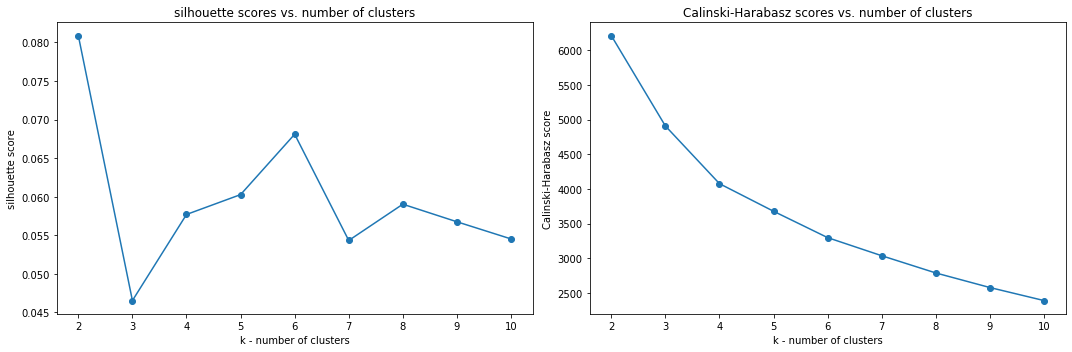

In [980]:
plt.subplots(1,2,figsize=(15,5))

# Visualize the silhouette plot
plt.subplot(1,2,1)
plt.plot(ks, silhouette_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(ks)

# Visualize the Calinski-Harabasz scores plot
plt.subplot(1,2,2)
plt.plot(ks, c_h_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(ks)

plt.tight_layout()
plt.show()

According to silhouette score, optimal `n_clusters` = 2 or 6, whereas according to Calinski-Harabasz score, optimal `n_clusters` = 2. Let's try manual hyperparameter tuning again, but increase `n_neighbors` to 50 since with our dataset size, it's reasonable to increase `n_neighbors`.

In [8]:
%%time

# n_neighbors = 50 this time

connectivity = kneighbors_graph(df_final2, n_neighbors=50, metric='euclidean', include_self=False, n_jobs=-1)

CPU times: user 24min 2s, sys: 8.67 s, total: 24min 11s
Wall time: 9min 7s


In [982]:
%%time

# range of n_clusters = 2-10
ks = np.arange(2,11)

# lists that we will append evaluation metrics to
silhouette_list = list()
c_h_list = list()

for k in ks:

    # Instantiate
    agg = AgglomerativeClustering(n_clusters=k, connectivity=connectivity, linkage='ward')
    
    # Fit (i.e. get clusters)
    agg.fit(df_final2)
        
    # Append silhouette scores 
    silhouette_list.append(silhouette_score(df_final2, agg.labels_))
       
    # Append Calinski_Harabasz scores 
    c_h_list.append(calinski_harabasz_score(df_final2, agg.labels_))

CPU times: user 31min 56s, sys: 4min 25s, total: 36min 22s
Wall time: 33min 3s


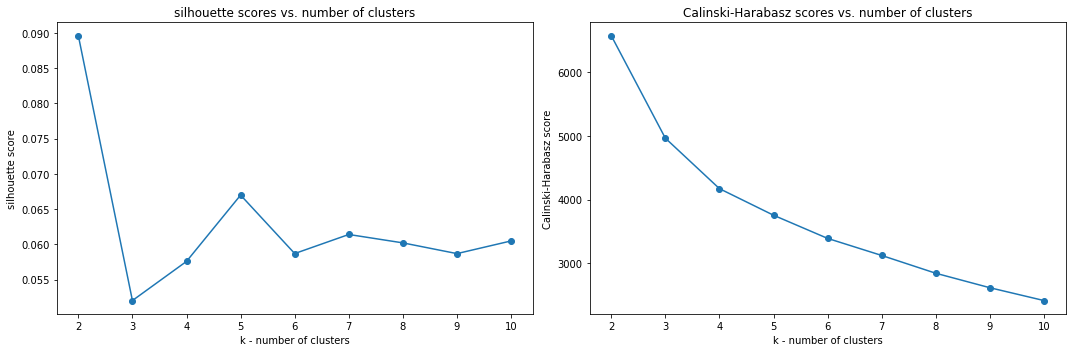

In [983]:
plt.subplots(1,2,figsize=(15,5))

# Visualize the silhouette plot
plt.subplot(1,2,1)
plt.plot(ks, silhouette_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette scores vs. number of clusters')
plt.xticks(ks)

# Visualize the Calinski-Harabasz scores plot
plt.subplot(1,2,2)
plt.plot(ks, c_h_list, marker='o')
plt.xlabel('k - number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz scores vs. number of clusters')
plt.xticks(ks)

plt.tight_layout()
plt.show()

Now the silhouette score says optimal value for `n_clusters` = 2 or 5, and Calinski-Harabasz score still says optimal value = 2. 

Given that K-Means returns the optimal value for `n_clusters` as 4, and DBSCAN and HDBSCAN return results that we choose to ignore because of noise data, let's just model Agglomerative Clustering at `n_clusters` = 4. We can then use external validation metrics as mentioned in the intro to see if K-Means and Agglomerative Clustering return similar clusters.

In [9]:
%%time

# instantiate
agg = AgglomerativeClustering(n_clusters=4, connectivity=connectivity, linkage='ward')
    
# tit (i.e. get clusters)

agg.fit(df_final2)

CPU times: user 1min 39s, sys: 1.5 s, total: 1min 41s
Wall time: 1min 41s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<69989x69989 sparse matrix of type '<class 'numpy.float64'>'
	with 3499450 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=4)

In [11]:
# return the sizes of each cluster

pd.Series(agg.labels_).value_counts()

1    23642
0    20118
2    15036
3    11193
dtype: int64

The sizes of each cluster look reasonable to us. Let's add these cluster labels back to the dataset that already contains K-Means' cluster labels.

In [12]:
# check

df_final_labels.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_other,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0


In [13]:
# append Agglomerative Clustering cluster labels to dataset as a new label column

df_final_labels['agglom'] = agg.labels_

In [14]:
# check again

df_final_labels.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3,0
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,3


In [16]:
# output to csv

df_final_labels.to_csv('data/df_final_cluster_labels.csv')

In [21]:
# copy dataframe 

df_final_labels3 = df_final_labels.copy()

With both cluster labels added, we can then check them against a couple external validation metrics<sup>2</sup> - adjusted Rand score and adjusted mutual info score - which check how similar the clusters are between K-Means and Agglomerative Clustering.

### Modeling Validation

In [993]:
# return adjusted rand score
# the arguments are symmetric, meaning, swapping the arguments doesn't change the score

adjusted_rand_score(df_final_labels3['kmeans'], df_final_labels3['agglom'])

0.7000210101130869

In [994]:
# return adjusted mutual info score
# the arguments are symmetric, meaning, swapping the arguments doesn't change the score

adjusted_mutual_info_score(df_final_labels3['kmeans'], df_final_labels3['agglom'])

0.674975876148398

Not bad! Based on how the adjusted rand score and the adjusted mutual information score are well above 0, we can conclude there are similarities found among the clusters. We have more confidence in the clusters found via K-Means method and Agglomerative Clustering method since the scores are ~0.70. Next, we'll do some exploratory analysis on the clusters to find which K-Means clusters are the same or similar with the Agglomerative clusters, and surface any interesting patterns or structures about them.

### Exploratory Analysis - Clusters

To do exploratory analysis on the clusters, we actually want the cluster labels back on the dataset we have before the preprocessing stage to make the task easier. That dataset has categorical variables before one-hot encoding.

In [26]:
# import dataset from preprocessing stage

df = pd.read_csv('data/df_preprocess.csv', index_col=[0])

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,num_med_changes,race_orig,readmitted_orig
2,64410,86047875,Non_Caucasian,Female,[20-30),emergency,home,emergency_room,2,unknown,...,other,6,None,None,No,Yes,0,0,AfricanAmerican,NO
3,500364,82442376,Caucasian,Male,[30-40),emergency,home,emergency_room,2,unknown,...,circulatory,7,None,None,Ch,Yes,0,1,Caucasian,NO
4,16680,42519267,Caucasian,Male,[40-50),emergency,home,emergency_room,1,unknown,...,diabetes,5,None,None,Ch,Yes,0,0,Caucasian,NO
5,35754,82637451,Caucasian,Male,[50-60),urgent,home,other,3,unknown,...,diabetes,9,None,None,No,Yes,1,0,Caucasian,>30
6,55842,84259809,Caucasian,Male,[60-70),elective,home,other,4,unknown,...,other,7,None,None,Ch,Yes,0,0,Caucasian,NO


In [27]:
# copy the dataframe 

dfanalysis = df.copy()

In [39]:
# in the dataset with the original categorical variables, add new columns for the cluster labels

dfanalysis['agglom'] = df_final_labels3.iloc[:,-1]
dfanalysis['kmeans'] = df_final_labels3.iloc[:,-2]

We know we can append the cluster labels back easily on the dataset with the categorical variables because the indices have been kept the same.

In [149]:
# check

dfanalysis.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,num_med_changes,race_orig,readmitted_orig,agglom,kmeans
2,64410,86047875,Non_Caucasian,Female,[20-30),emergency,home,emergency_room,2,unknown,...,None,None,No,Yes,0,0,AfricanAmerican,NO,1,1
3,500364,82442376,Caucasian,Male,[30-40),emergency,home,emergency_room,2,unknown,...,None,None,Ch,Yes,0,1,Caucasian,NO,2,2
4,16680,42519267,Caucasian,Male,[40-50),emergency,home,emergency_room,1,unknown,...,None,None,Ch,Yes,0,0,Caucasian,NO,2,2
5,35754,82637451,Caucasian,Male,[50-60),urgent,home,other,3,unknown,...,None,None,No,Yes,1,0,Caucasian,>30,0,3
6,55842,84259809,Caucasian,Male,[60-70),elective,home,other,4,unknown,...,None,None,Ch,Yes,0,0,Caucasian,NO,3,0


In [150]:
# check against the above

df_final_labels3.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_med_changes,age_[40-50),...,diag_3_respiratory,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,kmeans,agglom
2,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.083333,0.230769,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,1
3,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.307692,0.25,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
4,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.153846,0.00,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2,2
5,0.153846,0.229008,1.000000,0.1875,0.000000,0.0,0.000000,0.461538,0.00,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3,0
6,0.230769,0.526718,0.166667,0.2500,0.000000,0.0,0.000000,0.307692,0.00,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,3


Let's take a look at the sizes of clusters found by each method. Cluster labels are arbitrarily assigned; meaning, K-Means cluster label 1 could be the same as Agglomerative cluster label 2, for example.

In [43]:
# return # of data points per K-Means cluster label

dfanalysis['kmeans'].value_counts()

1    22162
2    18119
3    16440
0    13268
Name: kmeans, dtype: int64

In [44]:
# return # of data points per Agglom cluster label

dfanalysis['agglom'].value_counts()

1    23642
0    20118
2    15036
3    11193
Name: agglom, dtype: int64

The size of each respective cluster label could be a hint as to which cluster labels are the same. However, let's just plot out the distribution of each feature.

In [45]:
# check on column names

dfanalysis.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted', 'num_med_changes', 'race_orig',
       'readmitted_orig', 'agglom', 'kmeans'],
      dtype='object')

In [46]:
# not interested in plotting certain variables such as encounter_id, patient_nbr, etc.

exclude = dfanalysis.iloc[:,[0,1,26,27,28,29]].columns

# assign to a variable the features we're interested in plotting
# .difference returns the indices of features that are not the features we want to exclude from plotting

include = dfanalysis.columns.difference(exclude, sort=False)

include

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted',
       'num_med_changes'],
      dtype='object')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


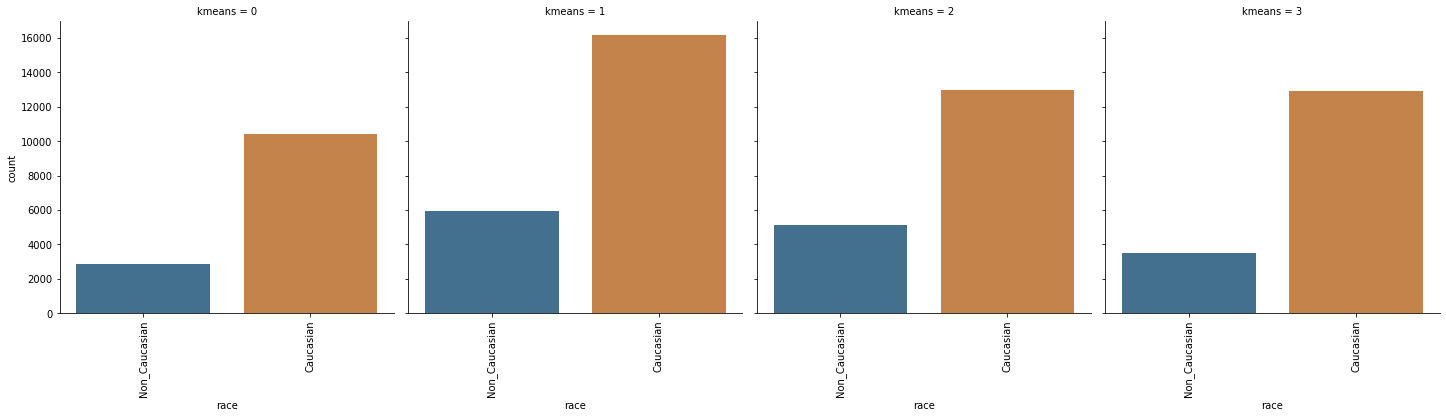

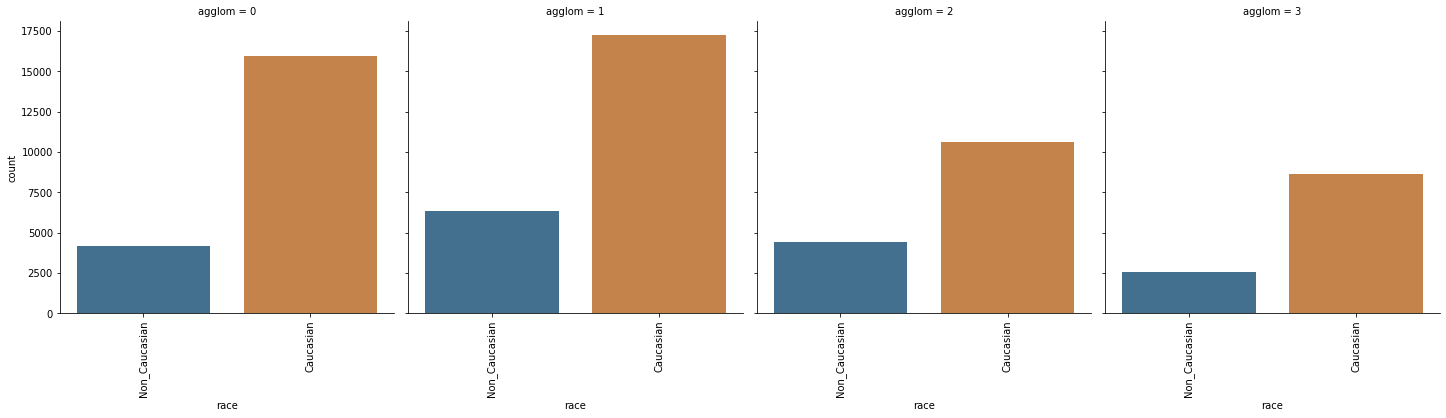

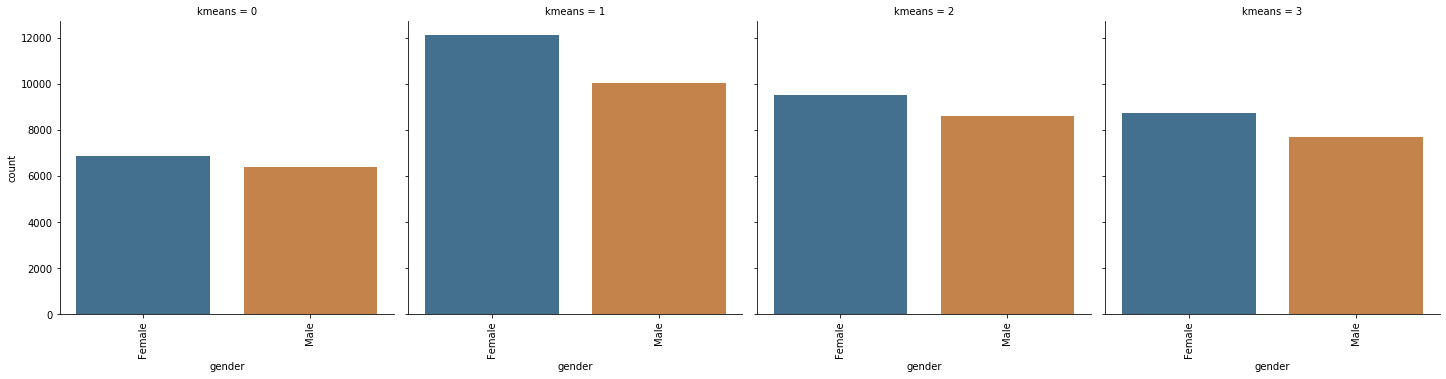

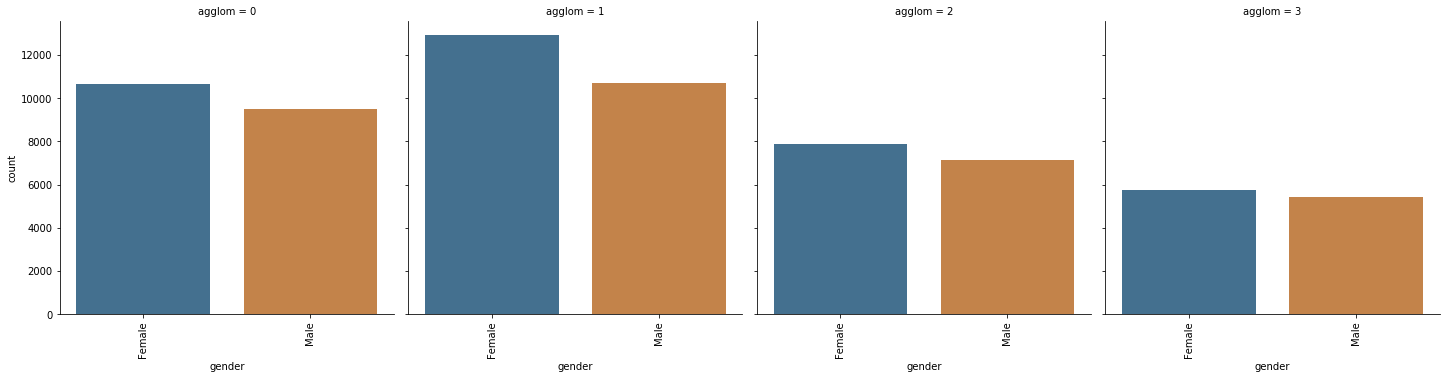

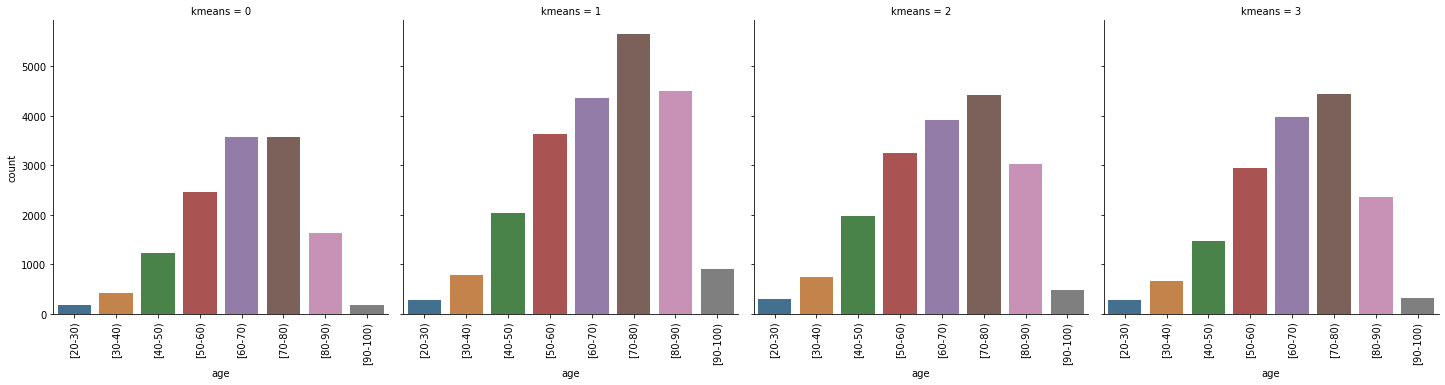

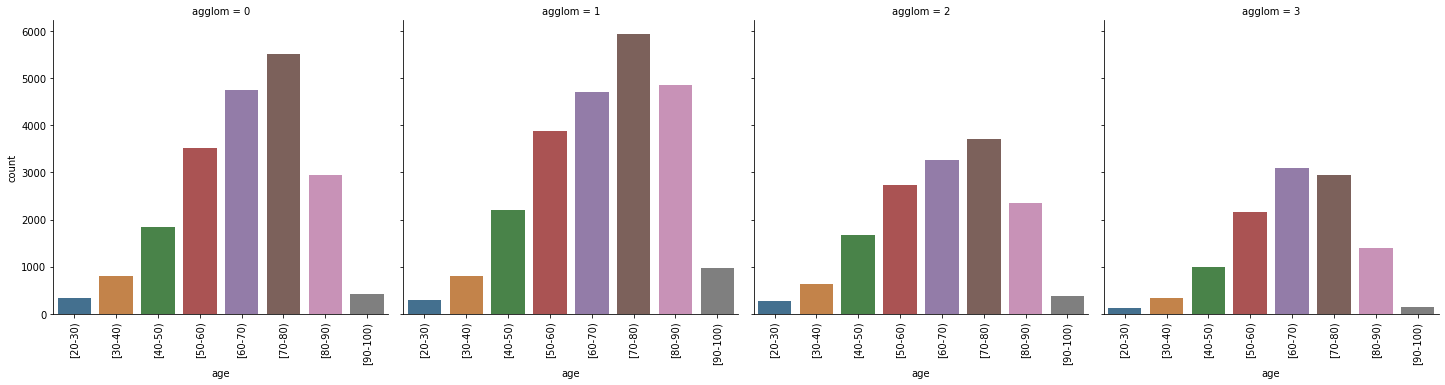

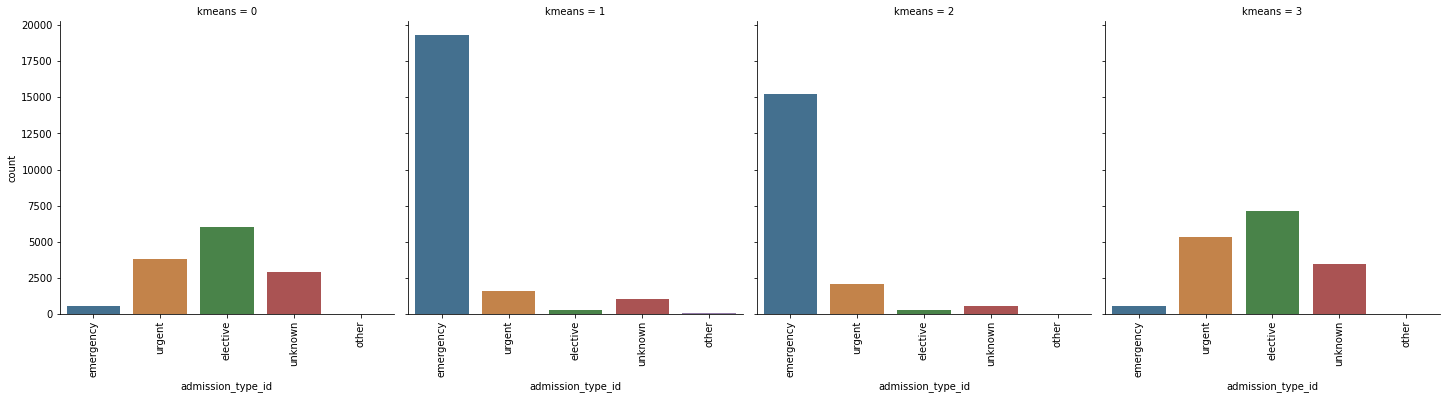

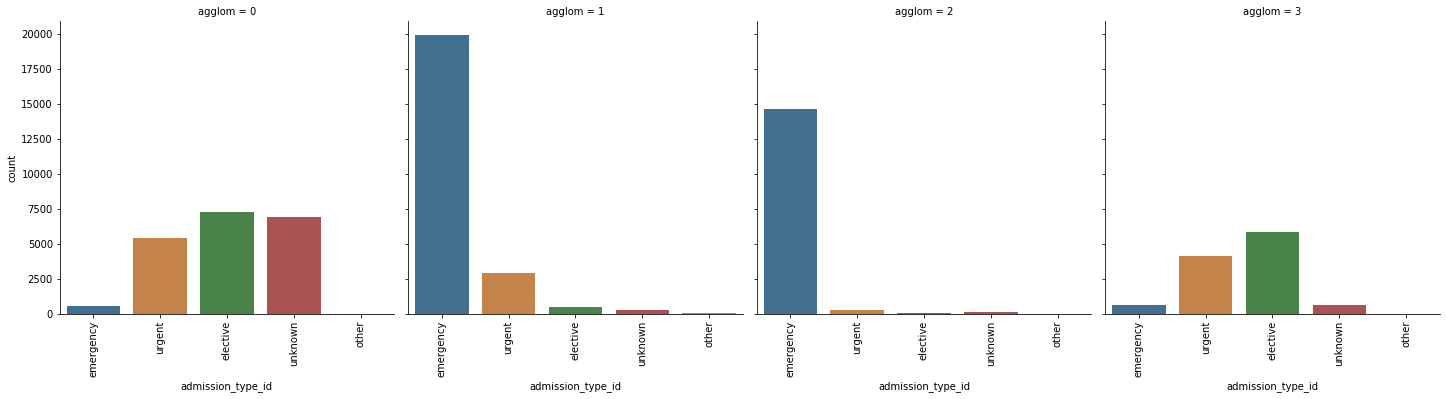

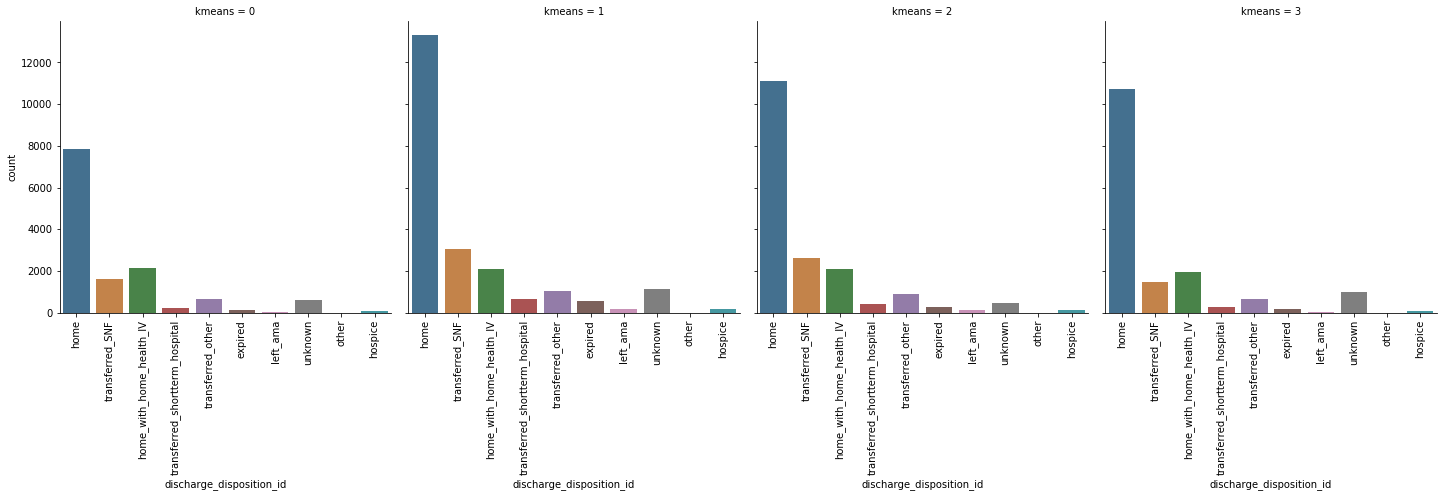

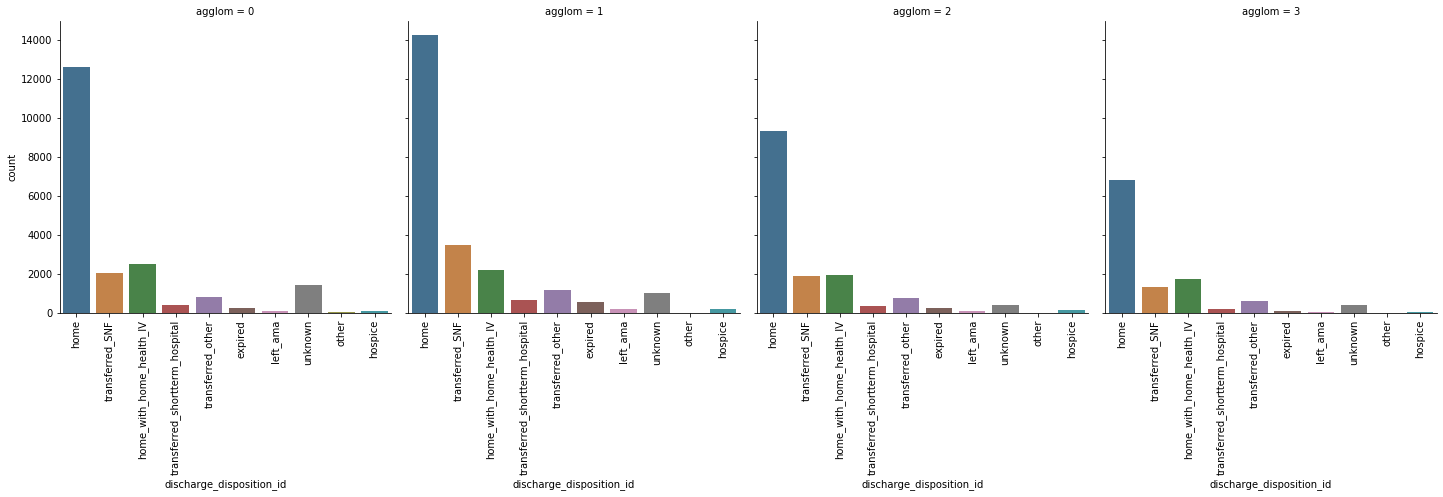

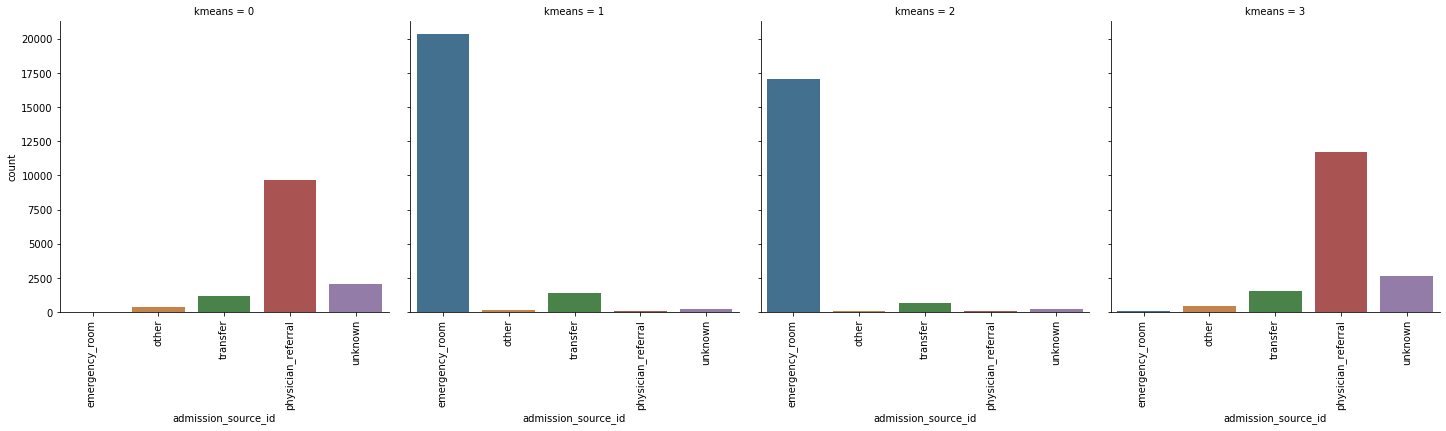

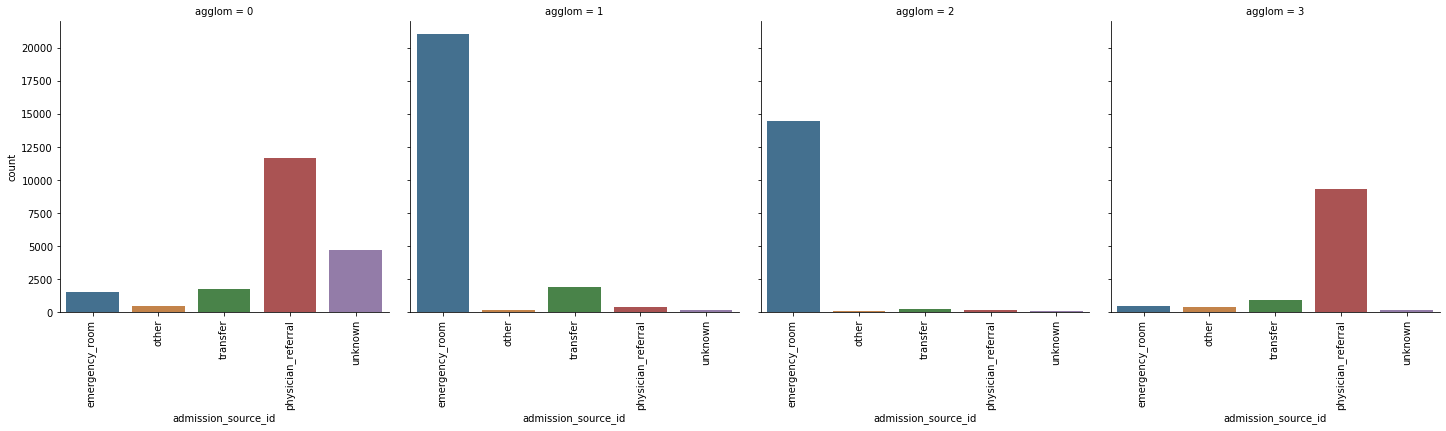

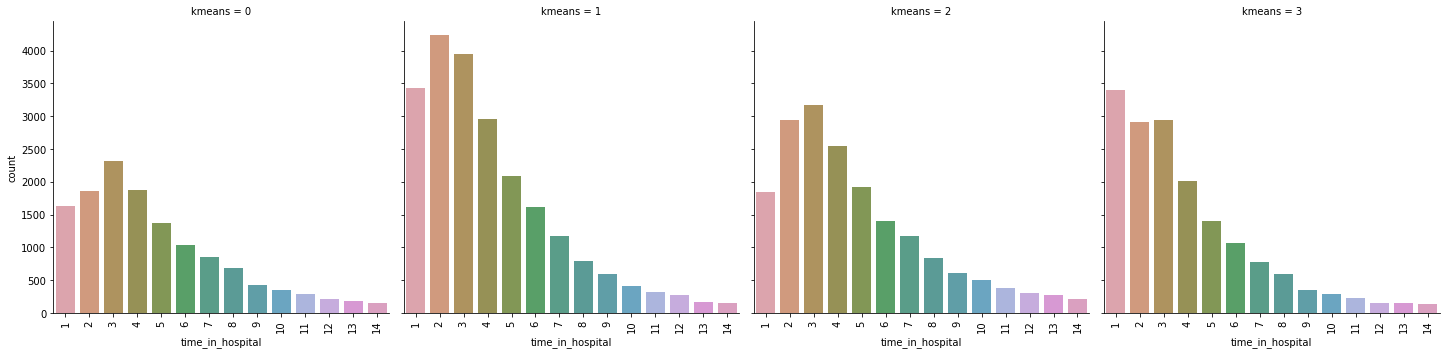

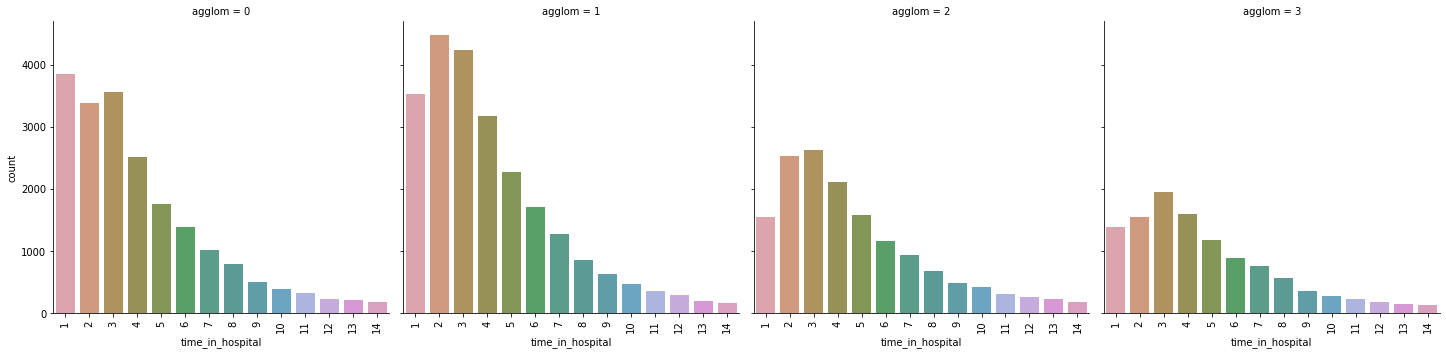

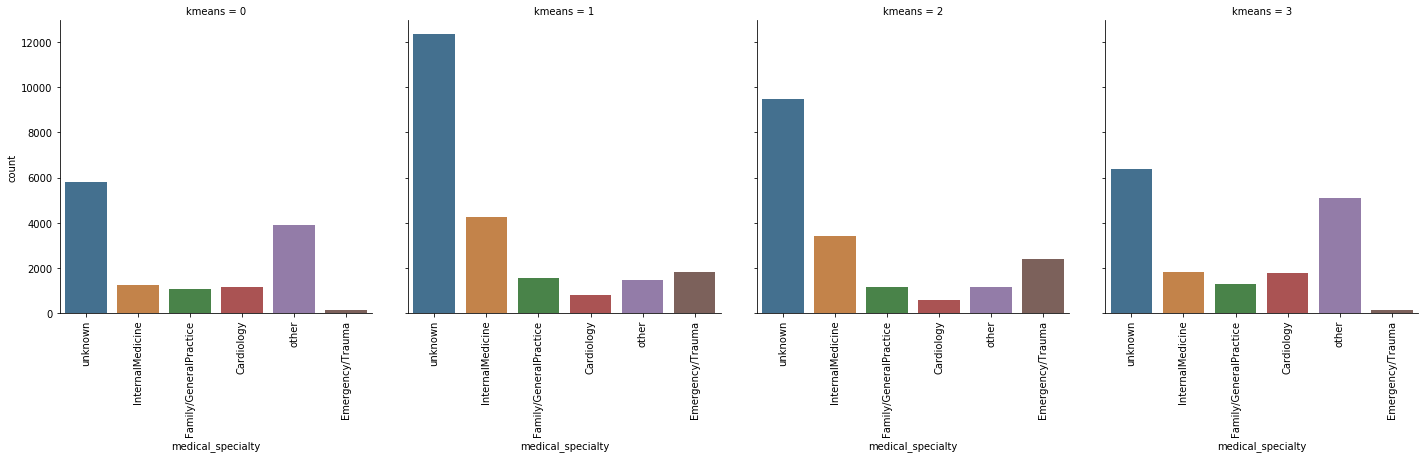

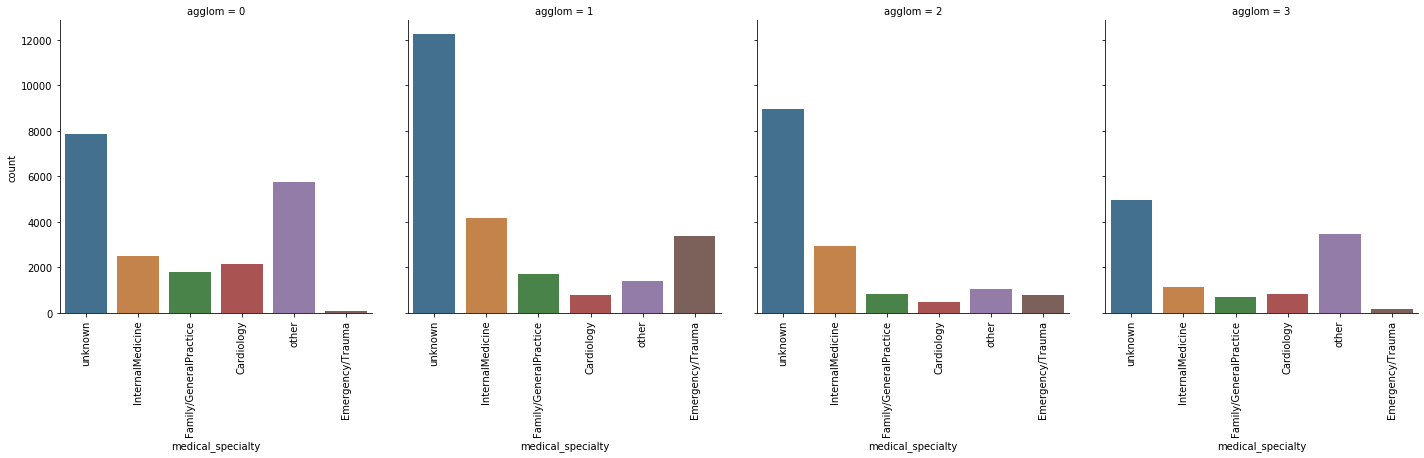

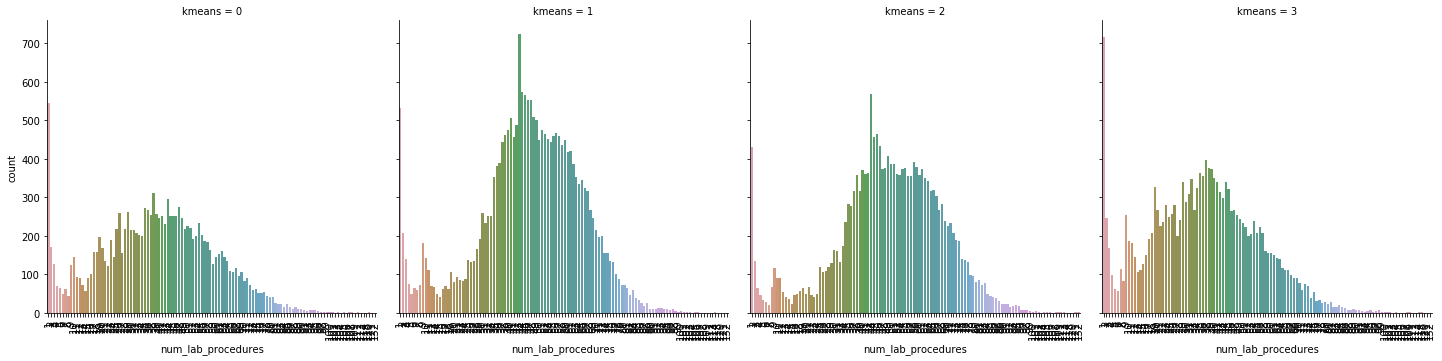

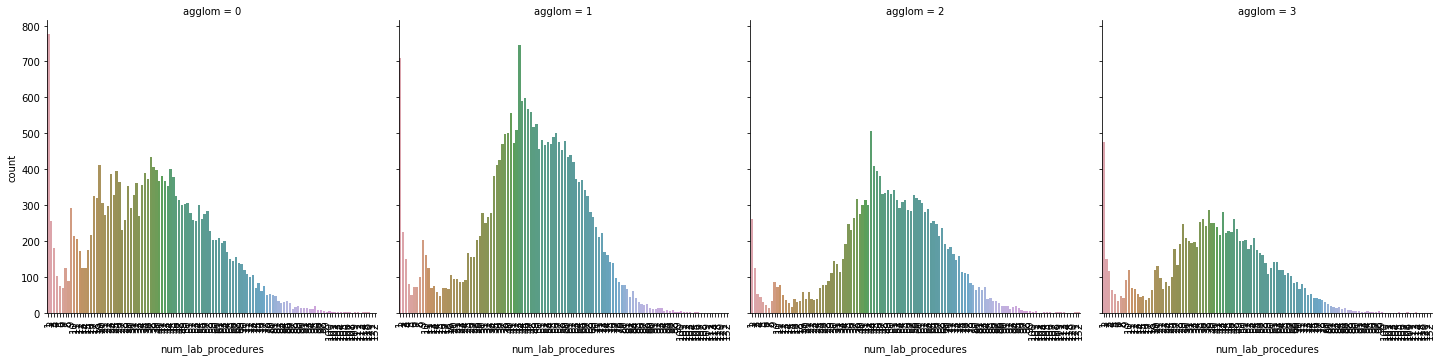

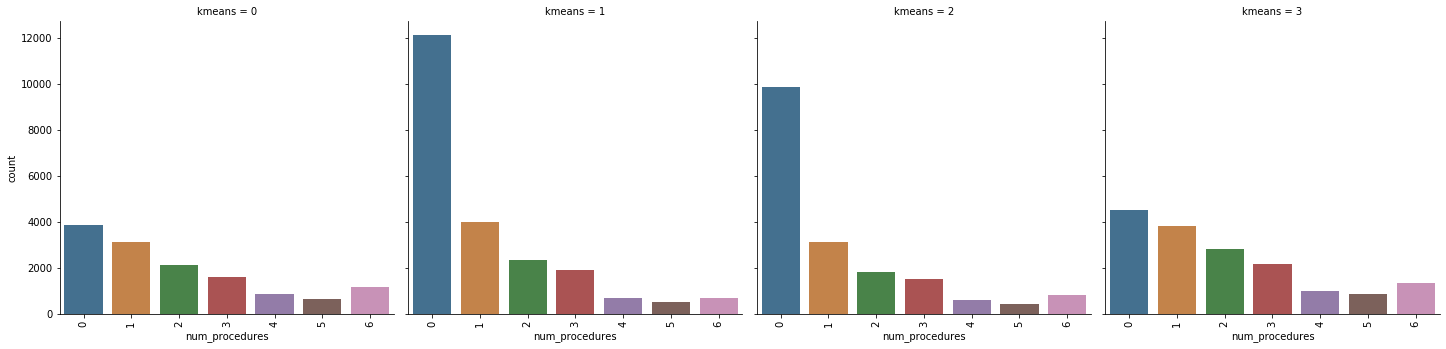

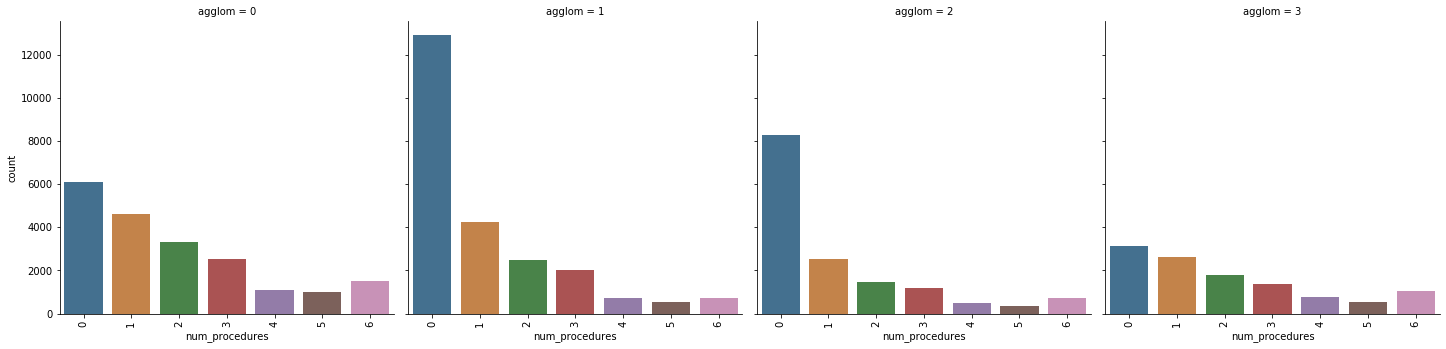

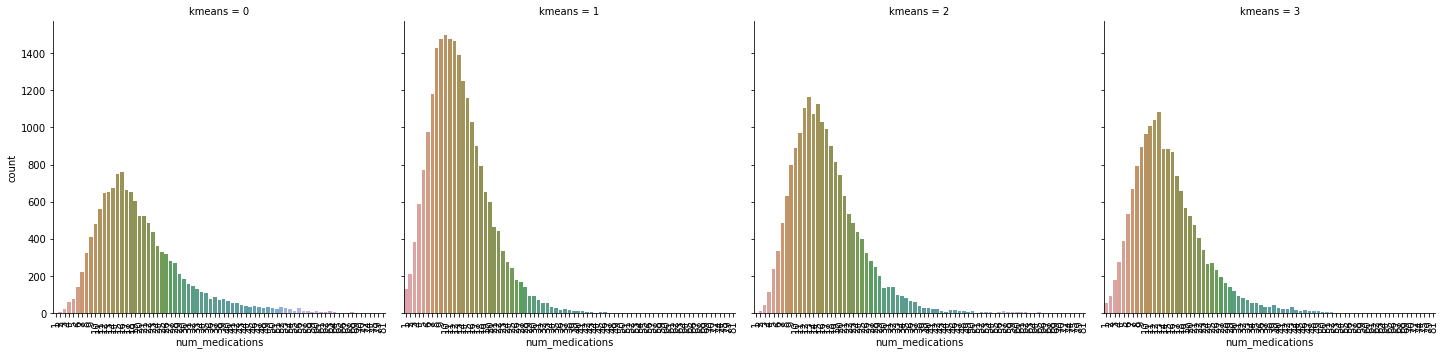

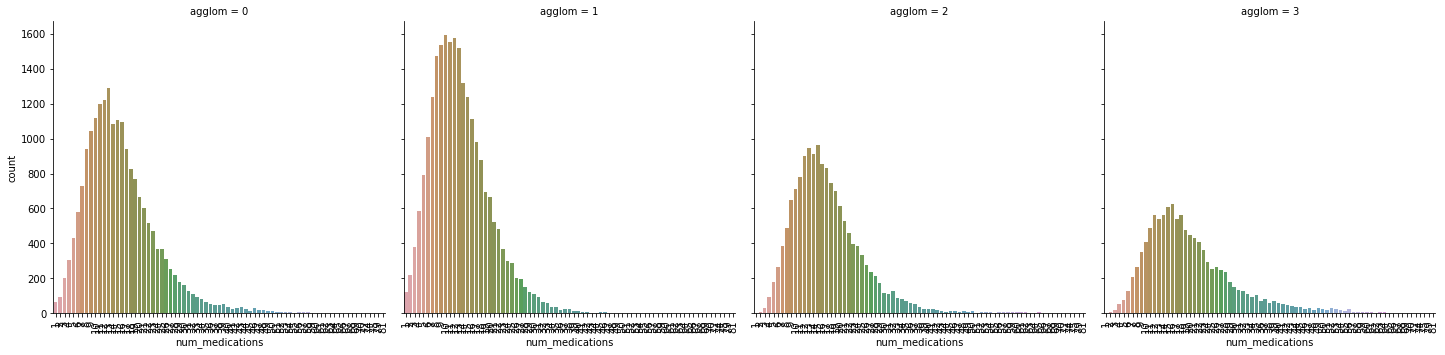

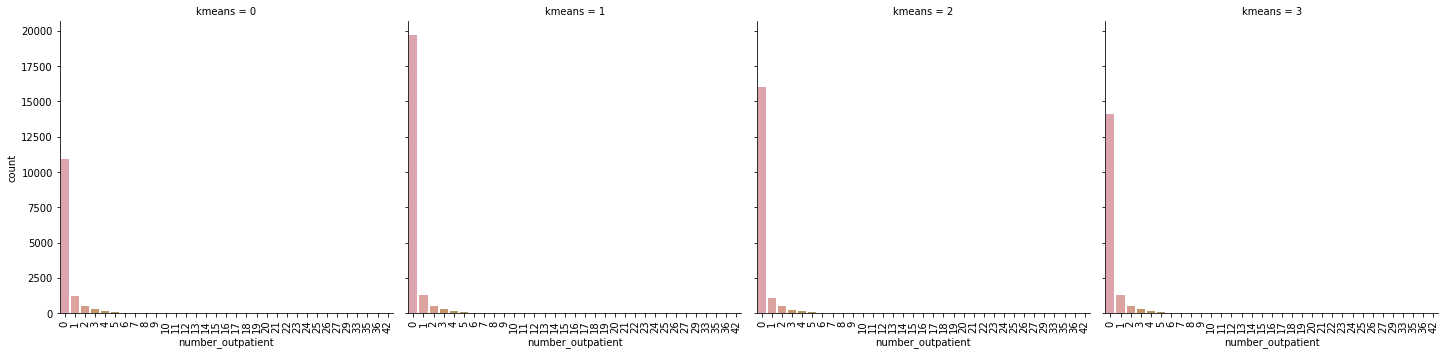

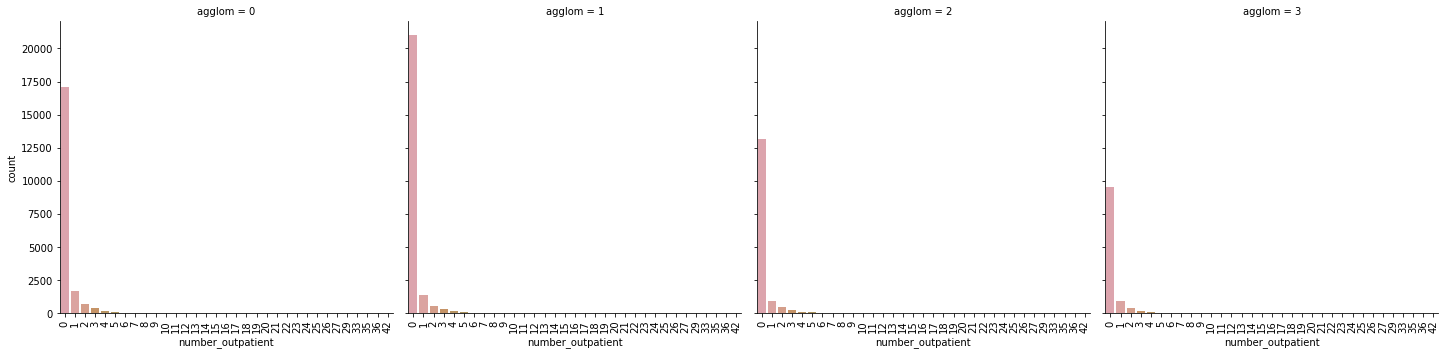

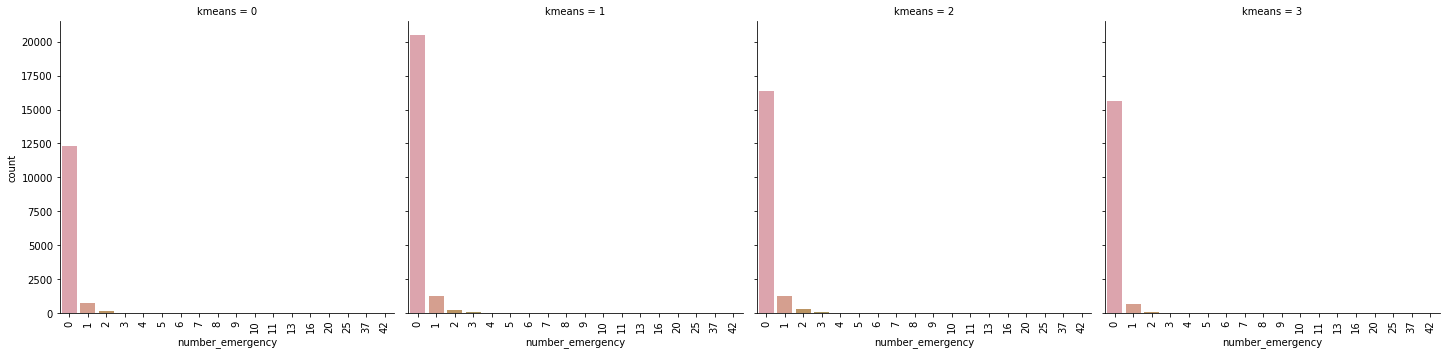

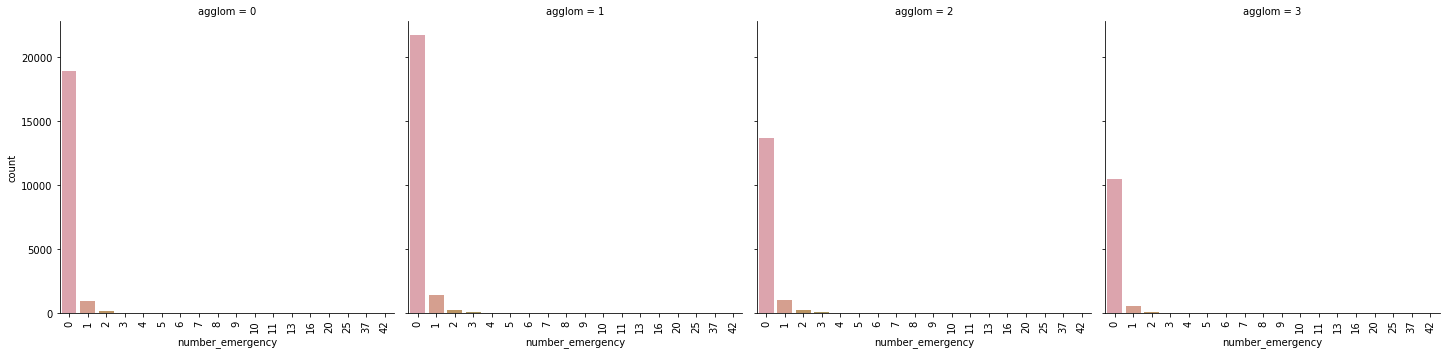

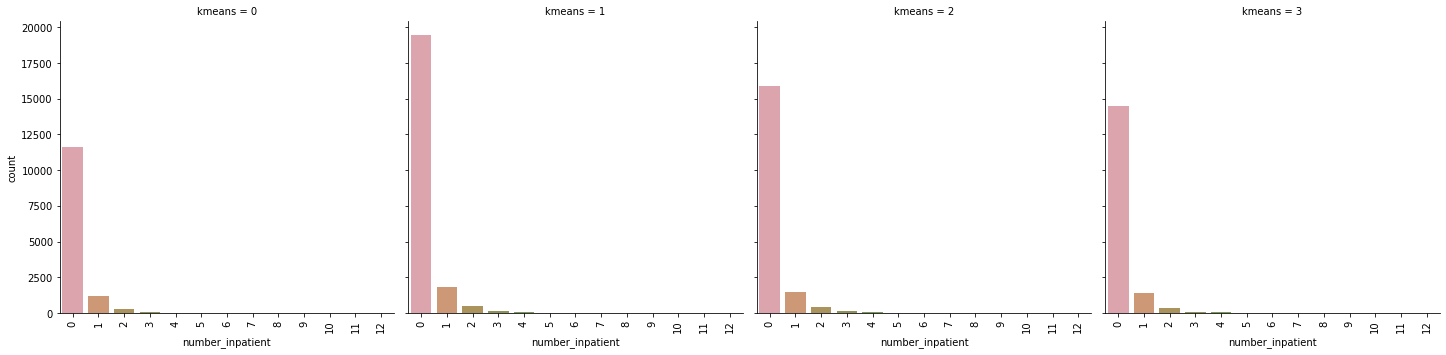

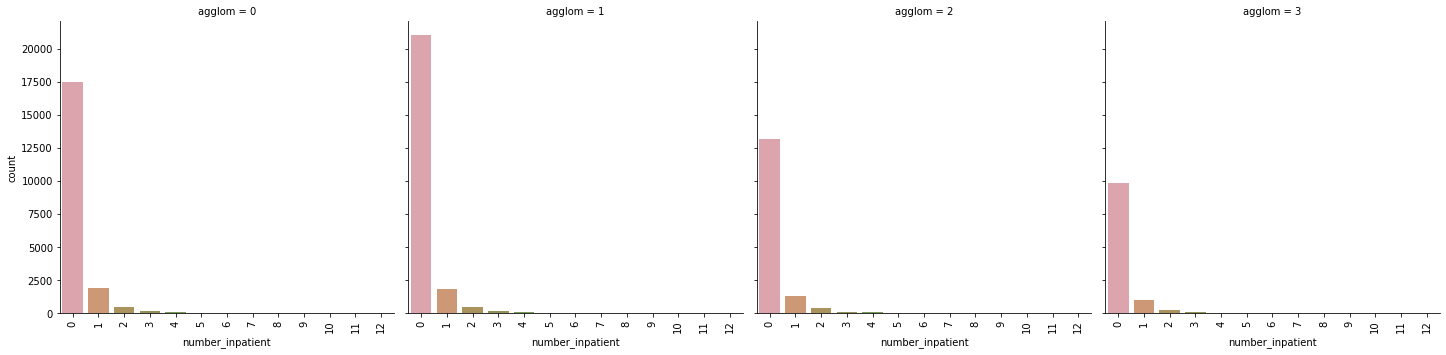

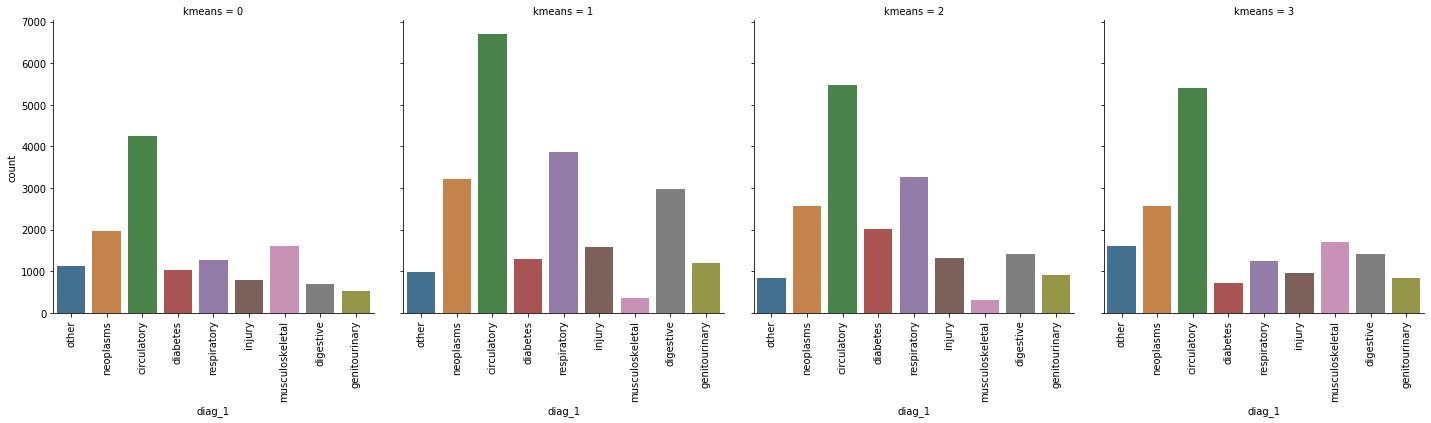

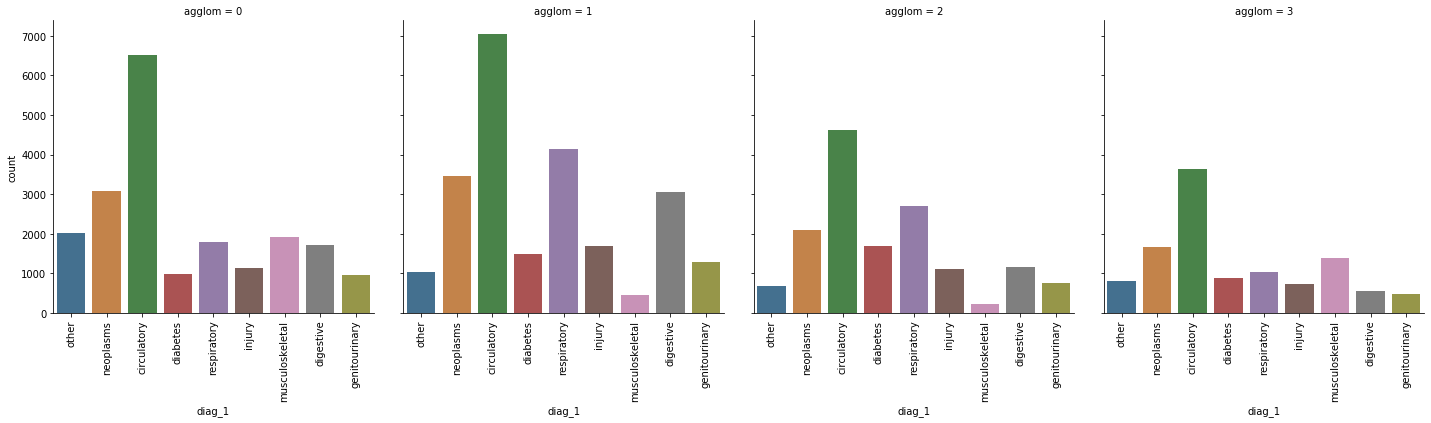

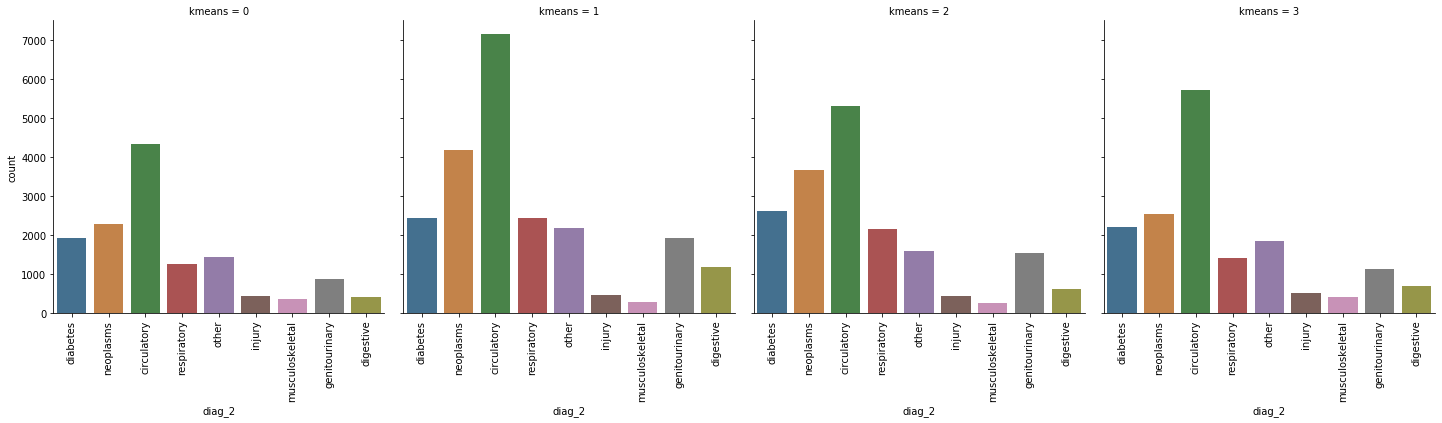

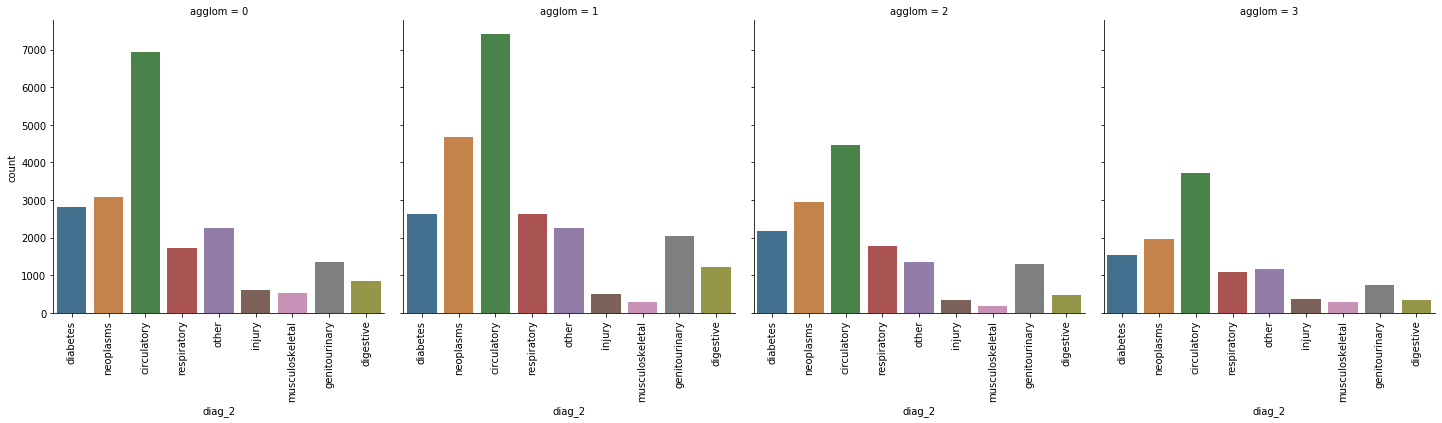

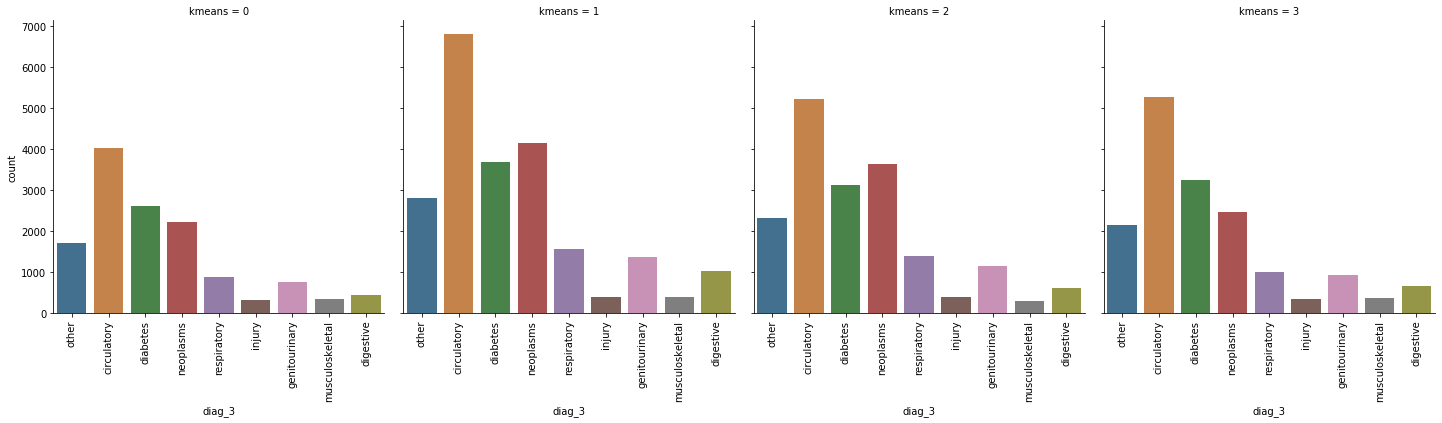

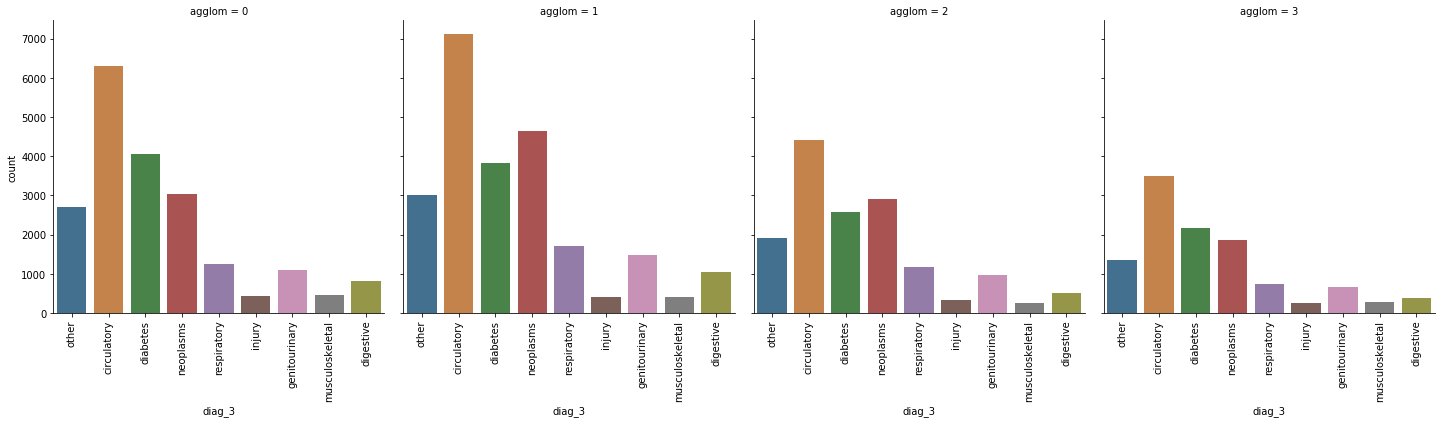

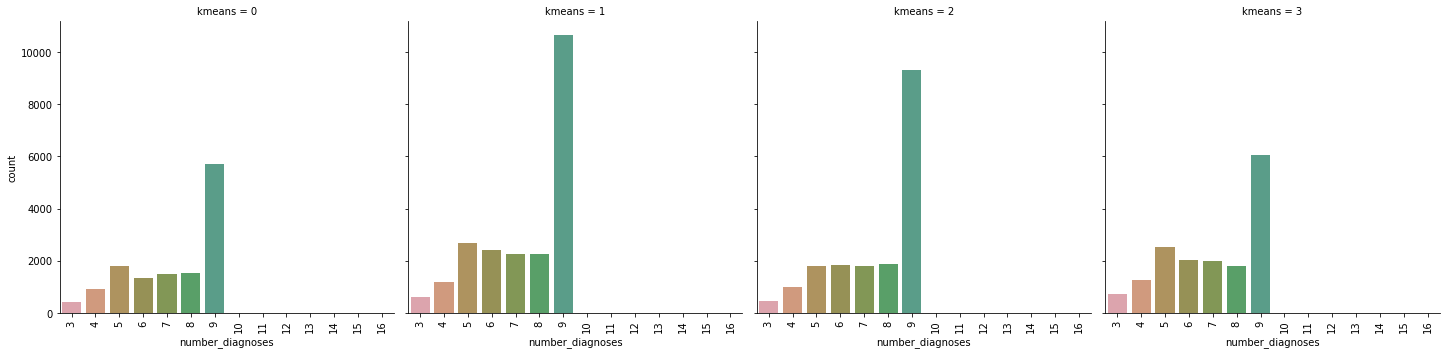

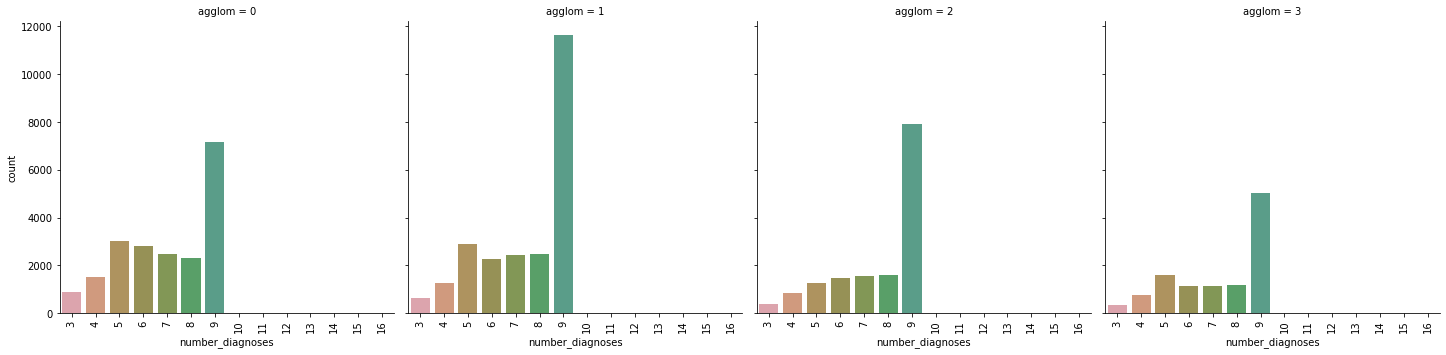

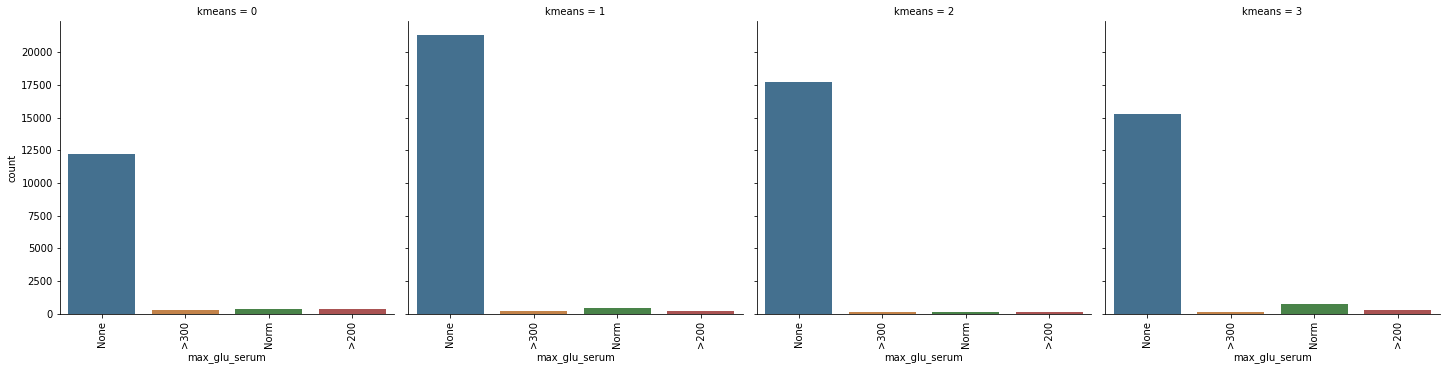

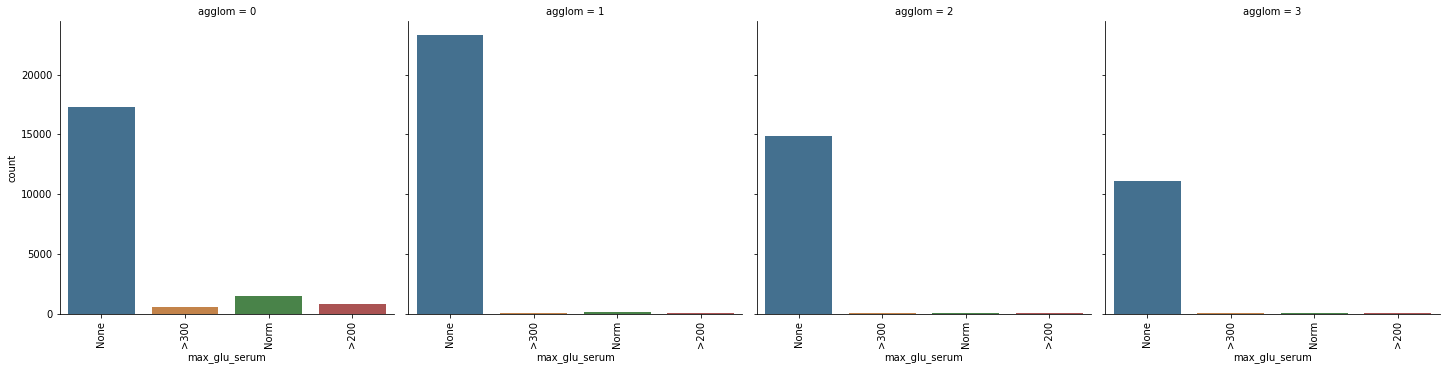

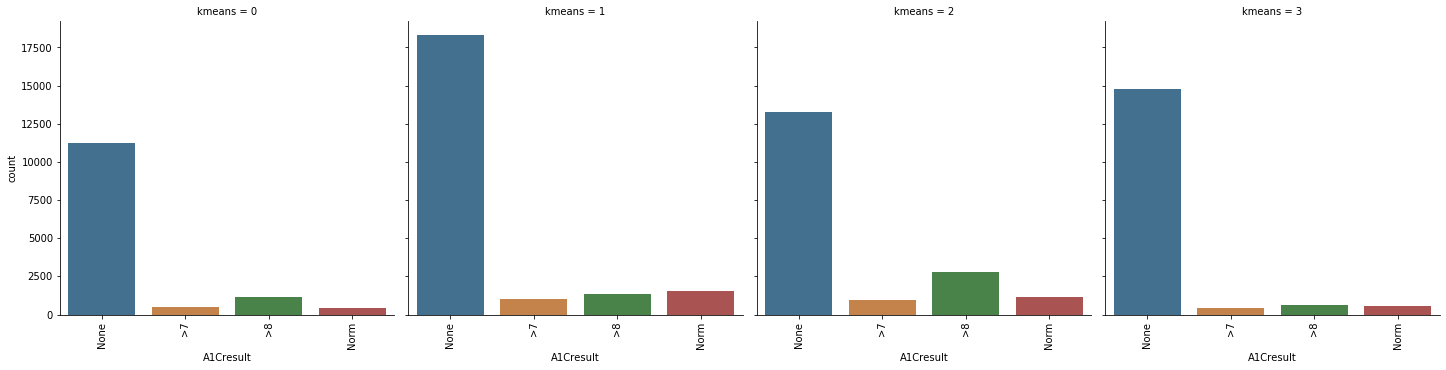

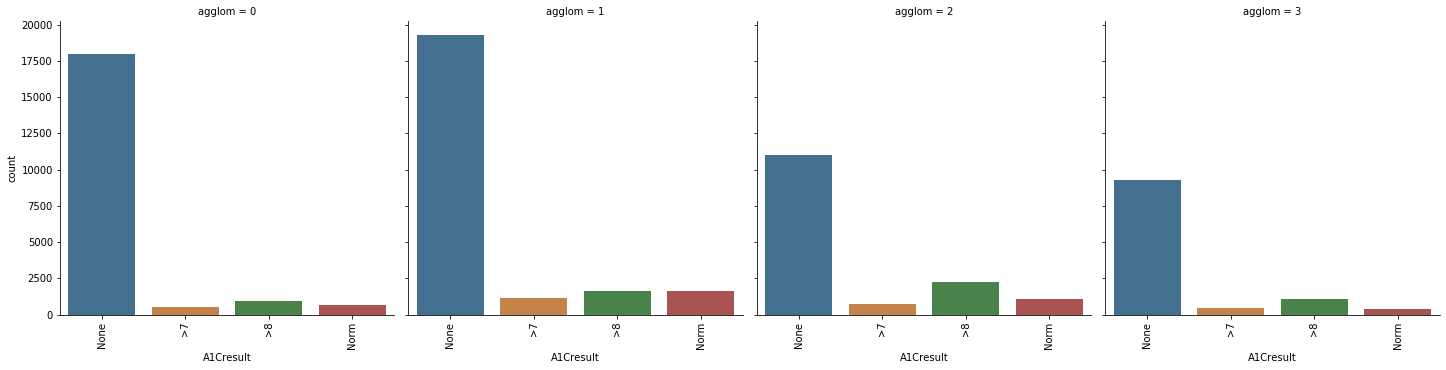

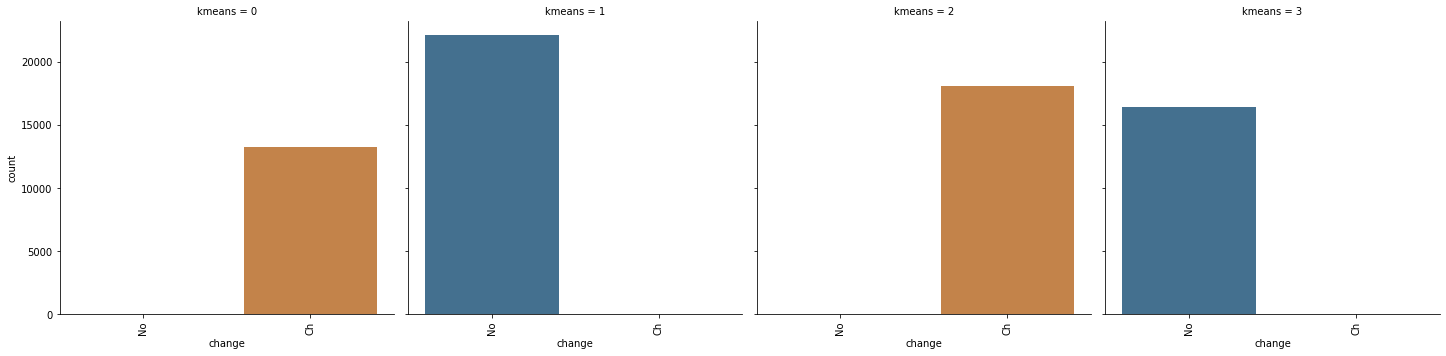

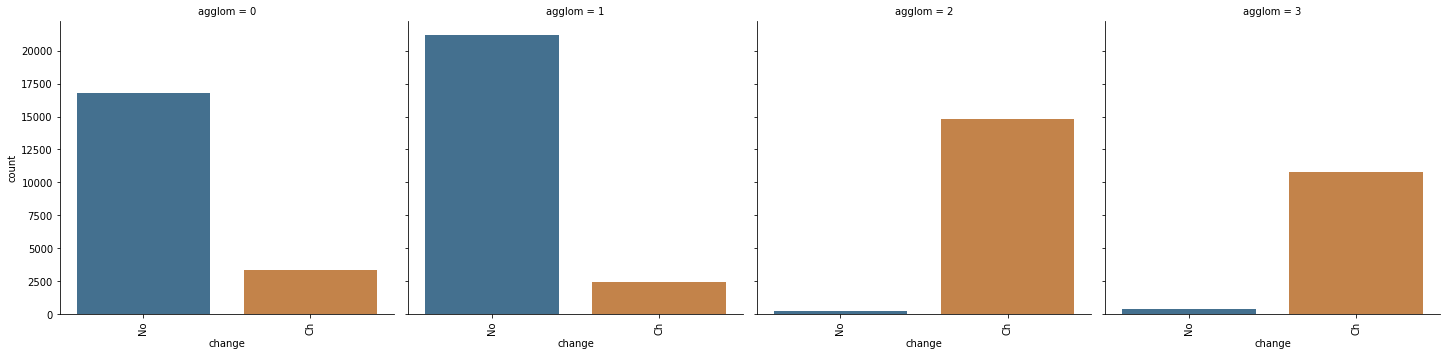

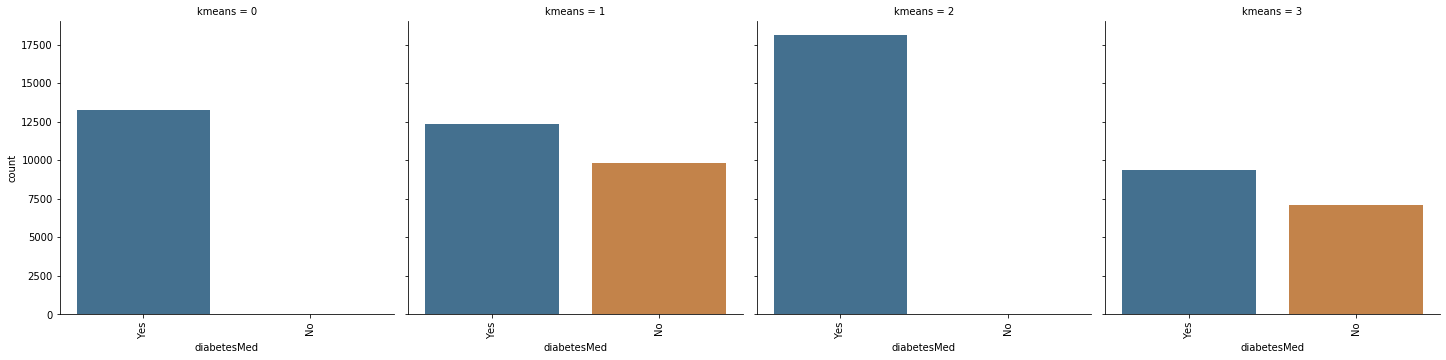

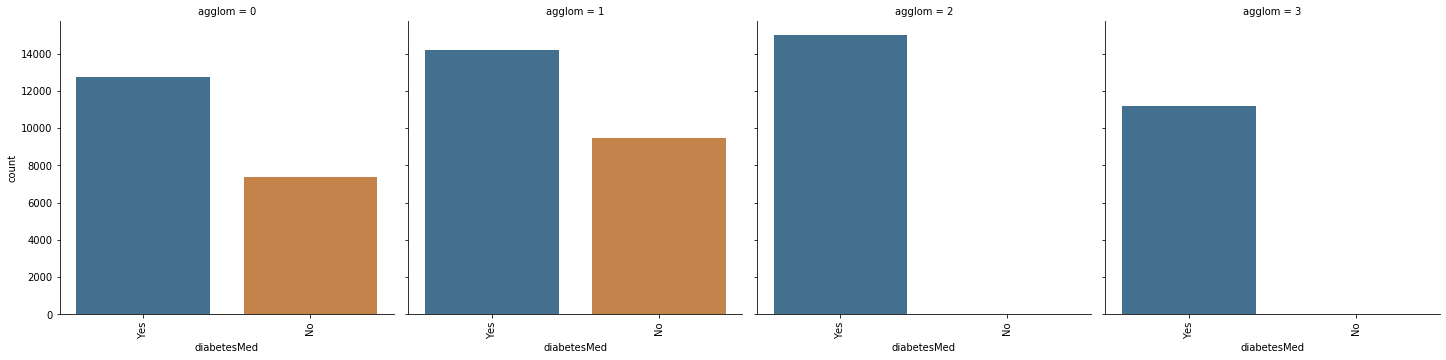

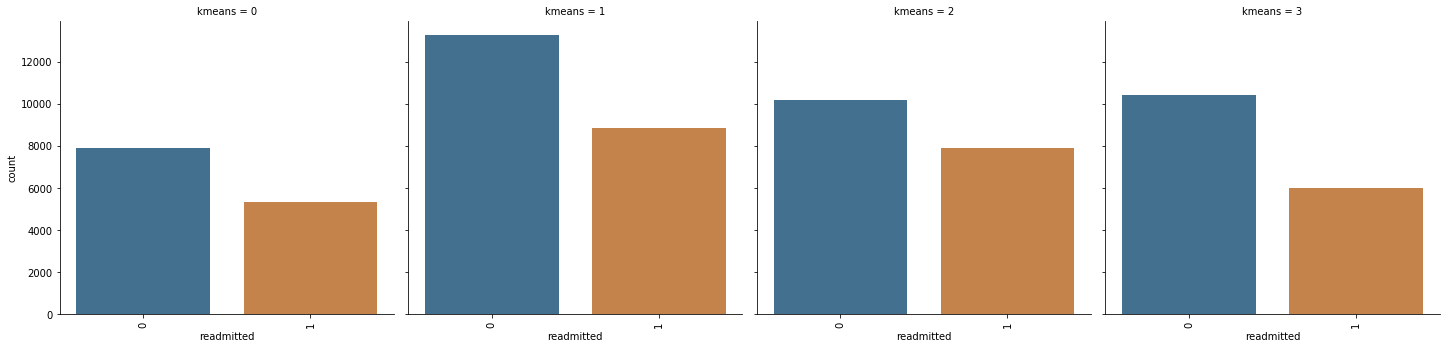

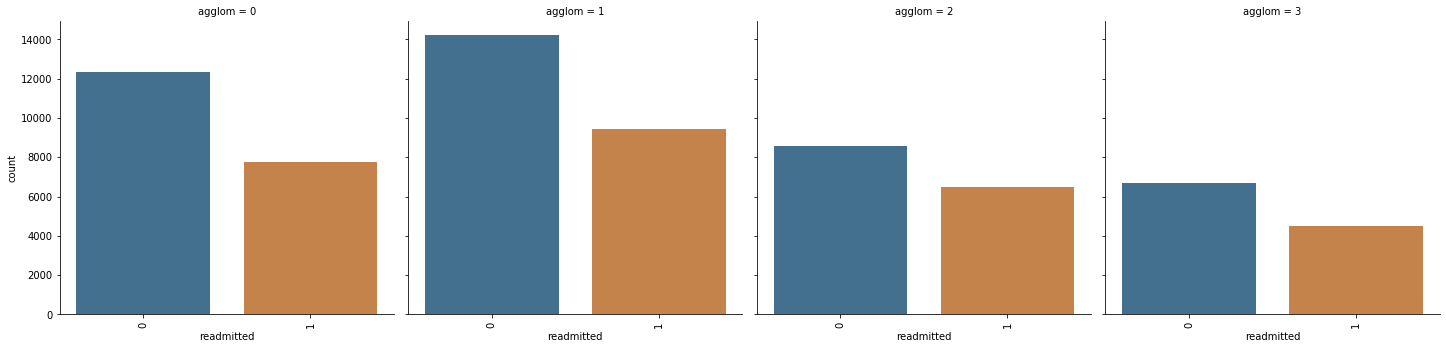

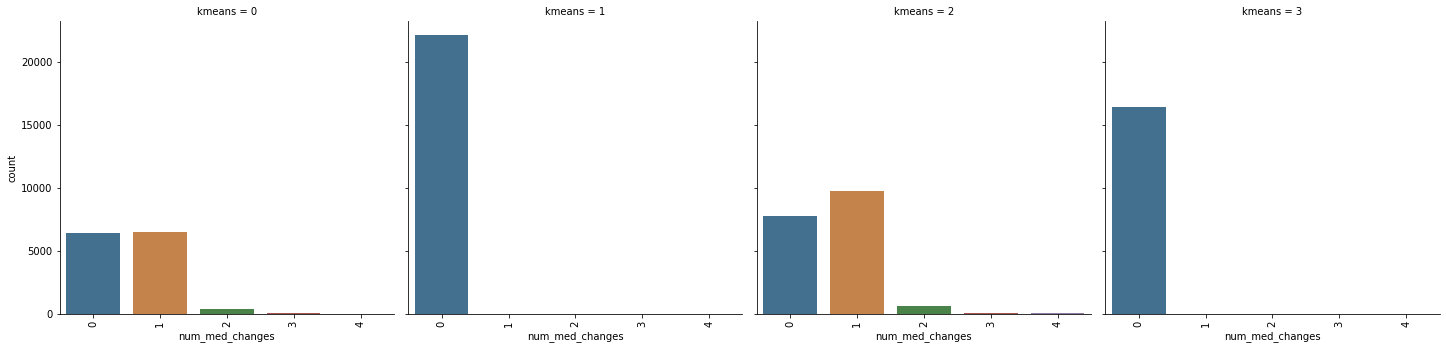

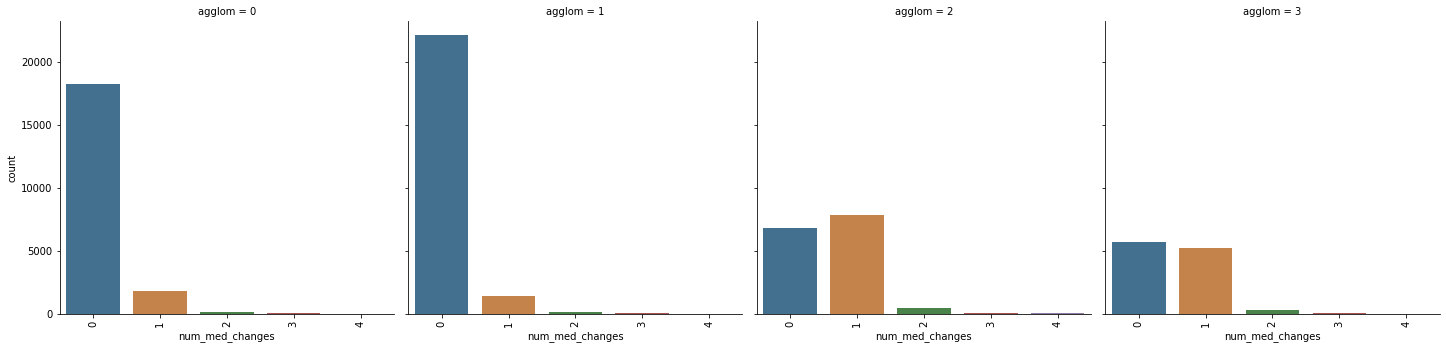

In [152]:
# assign to a variable the features we want to plot (we know the indices from above)

columns_to_plot = dfanalysis.columns[2:26]

# for loop that will plot a categorical plot for each feature
# one row will show a feature for k-means
# another row will show a feature for agglom
for c in columns_to_plot:
    
    gk = sns.catplot(x=c, col='kmeans', kind='count', data=dfanalysis, saturation=0.5)
    gk.set_xticklabels(rotation=90)
    
    ga = sns.catplot(x=c, col='agglom', kind='count', data=dfanalysis, saturation=0.5)
    ga.set_xticklabels(rotation=90)

The categorical plots above suggest that K-Means cluster 1 is the same as Agglomerative cluster 1; as we look at combinations of variables such as `admission_source_id`, `medical_specialty` and `num_med_changes`, these give us more confidence that K-Means cluster 1 is roughly the same as Agglomerative cluster 1. We also see that K-Means cluster 0 and Agglomerative cluster 3 are the same, as made evident by variables such as `admission_type_id` and `diabetesMed`, but also the comparative sizes of these clusters. The rest are a little harder to discern, so below we've plotted categorical plots for combinations of K-Means and Agglomerative clusters for each feature to help confirm our conclusions earlier but also surface insights on which clusters are the same from K-Means and Agglomerative clustering.

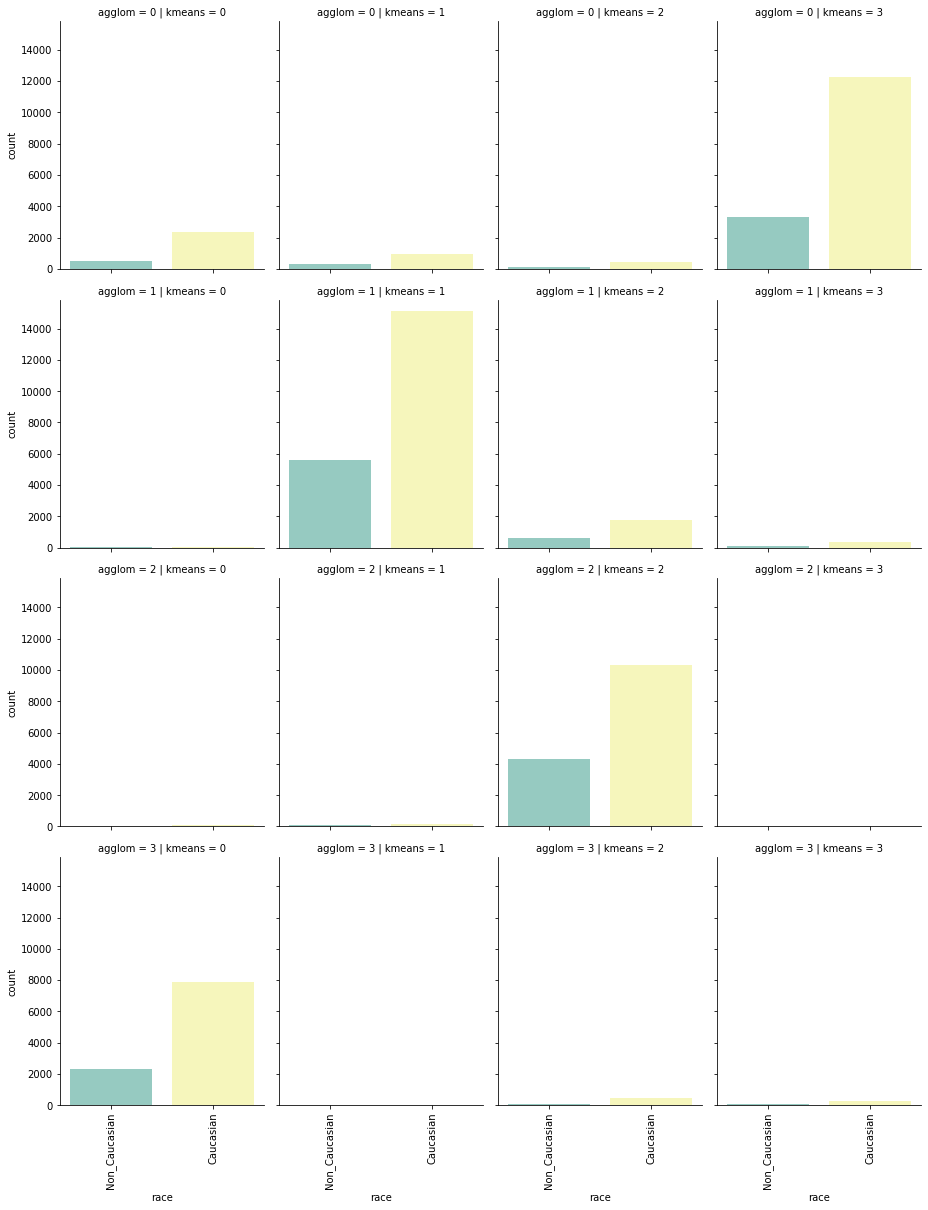

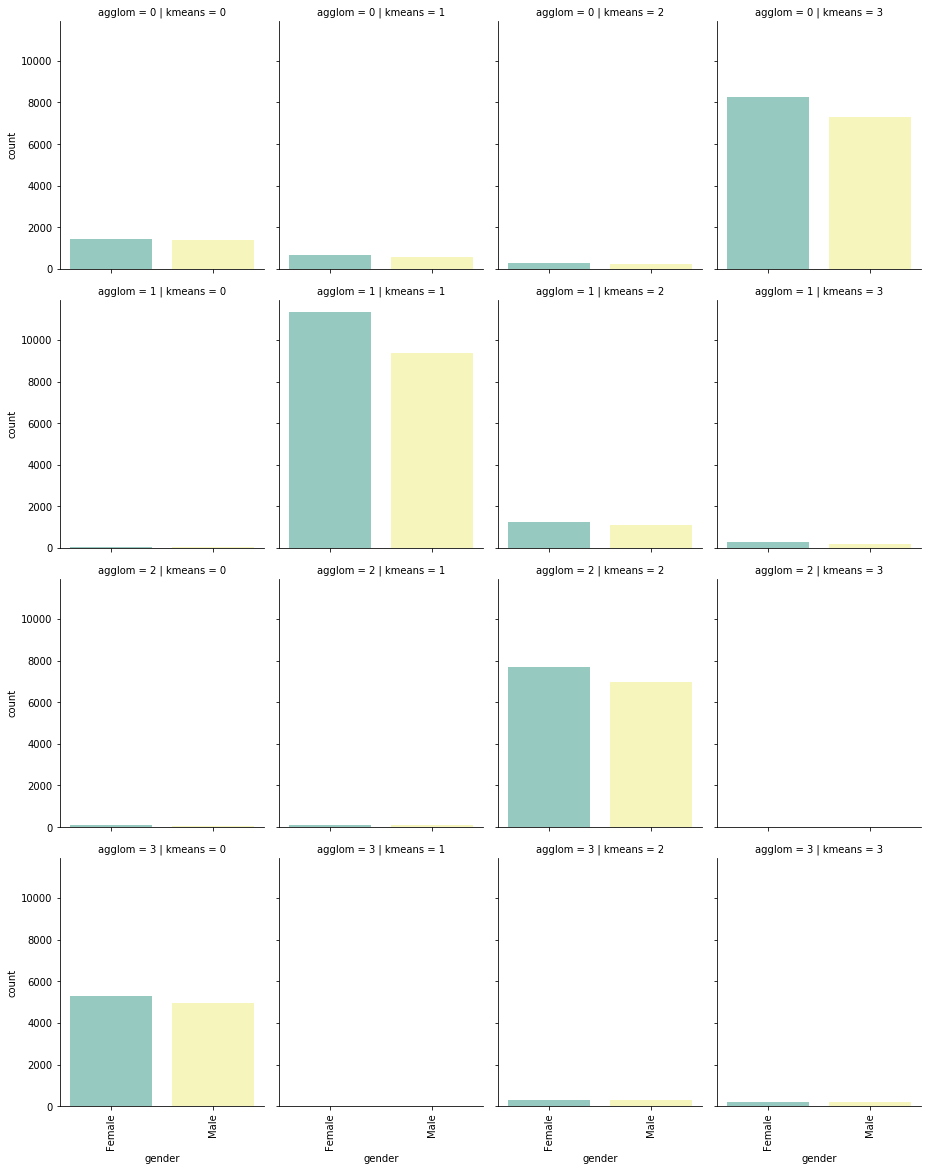

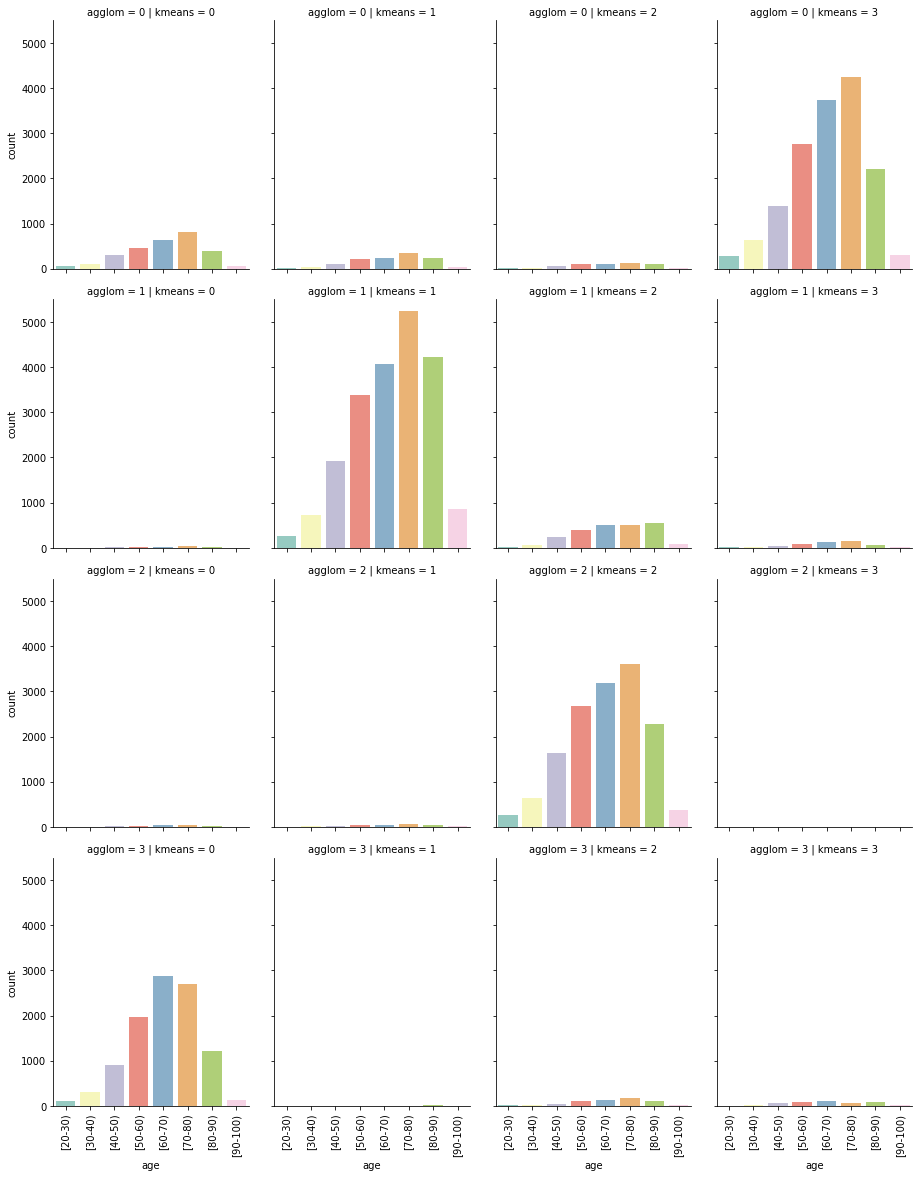

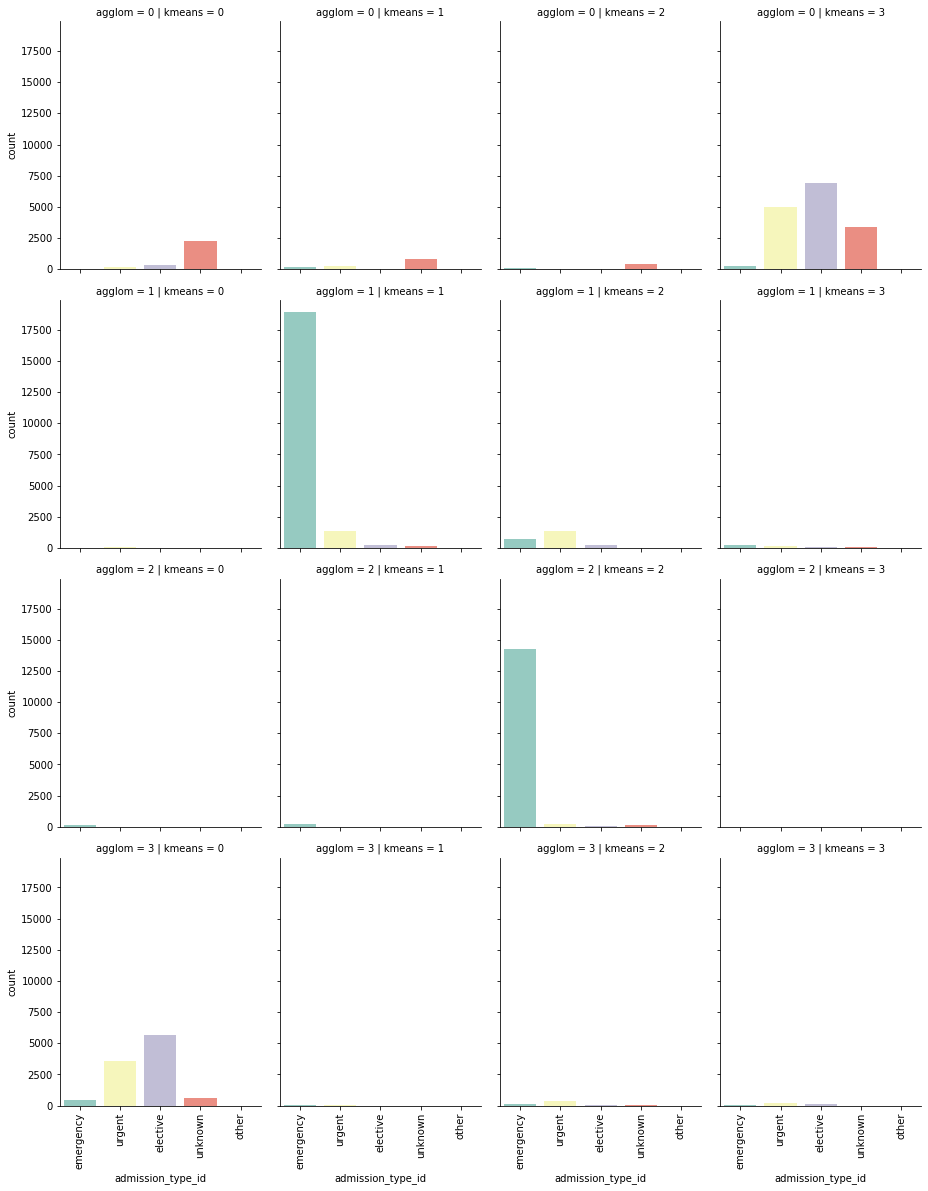

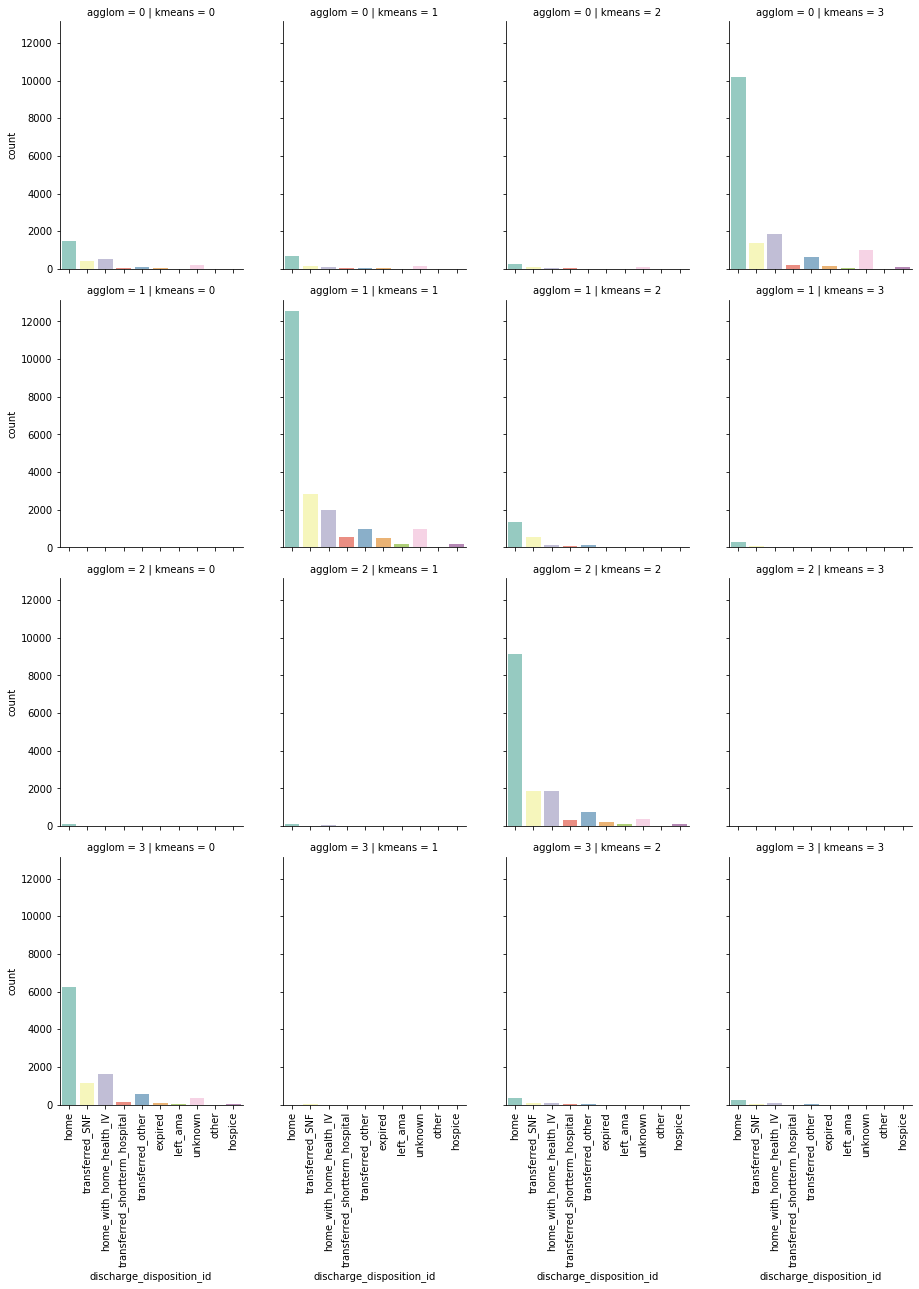

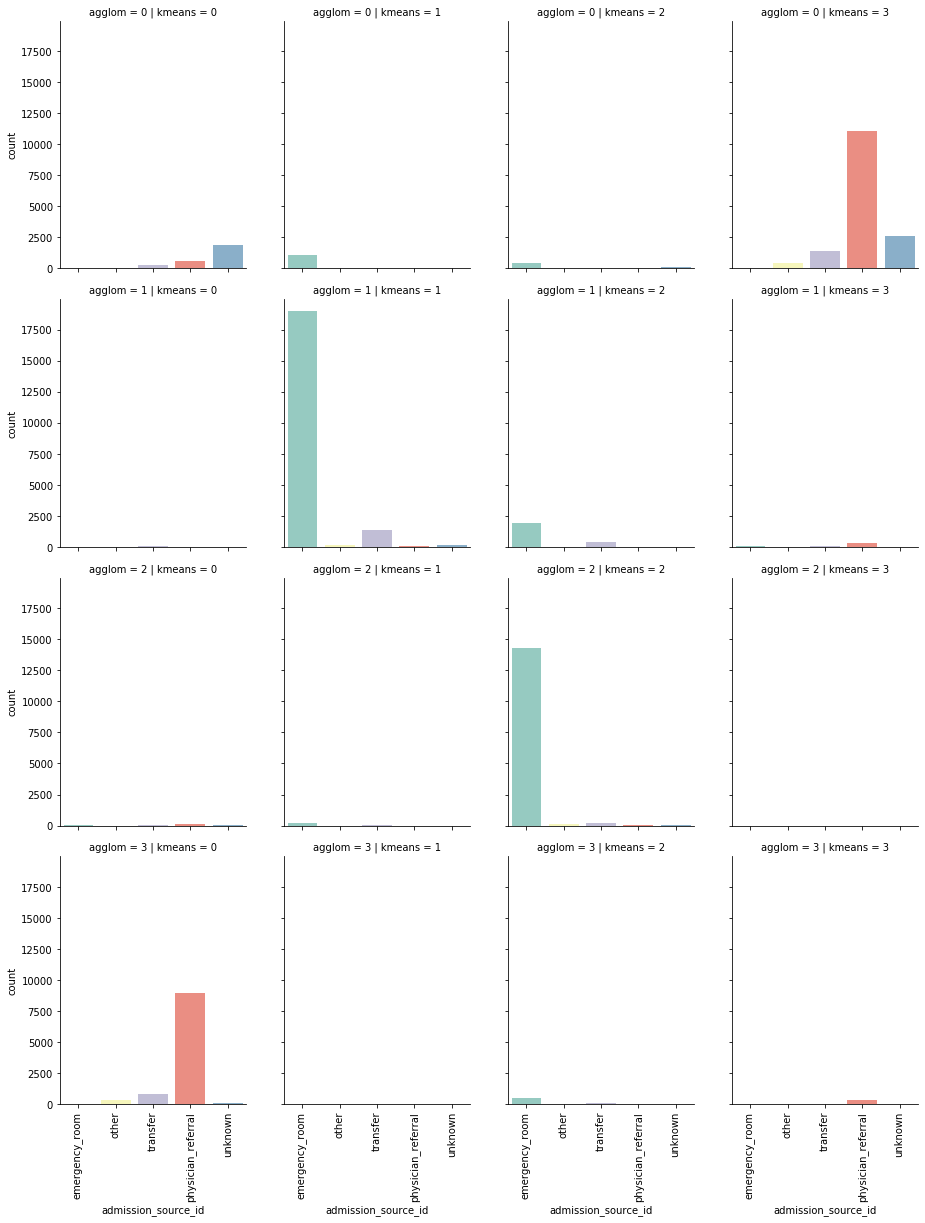

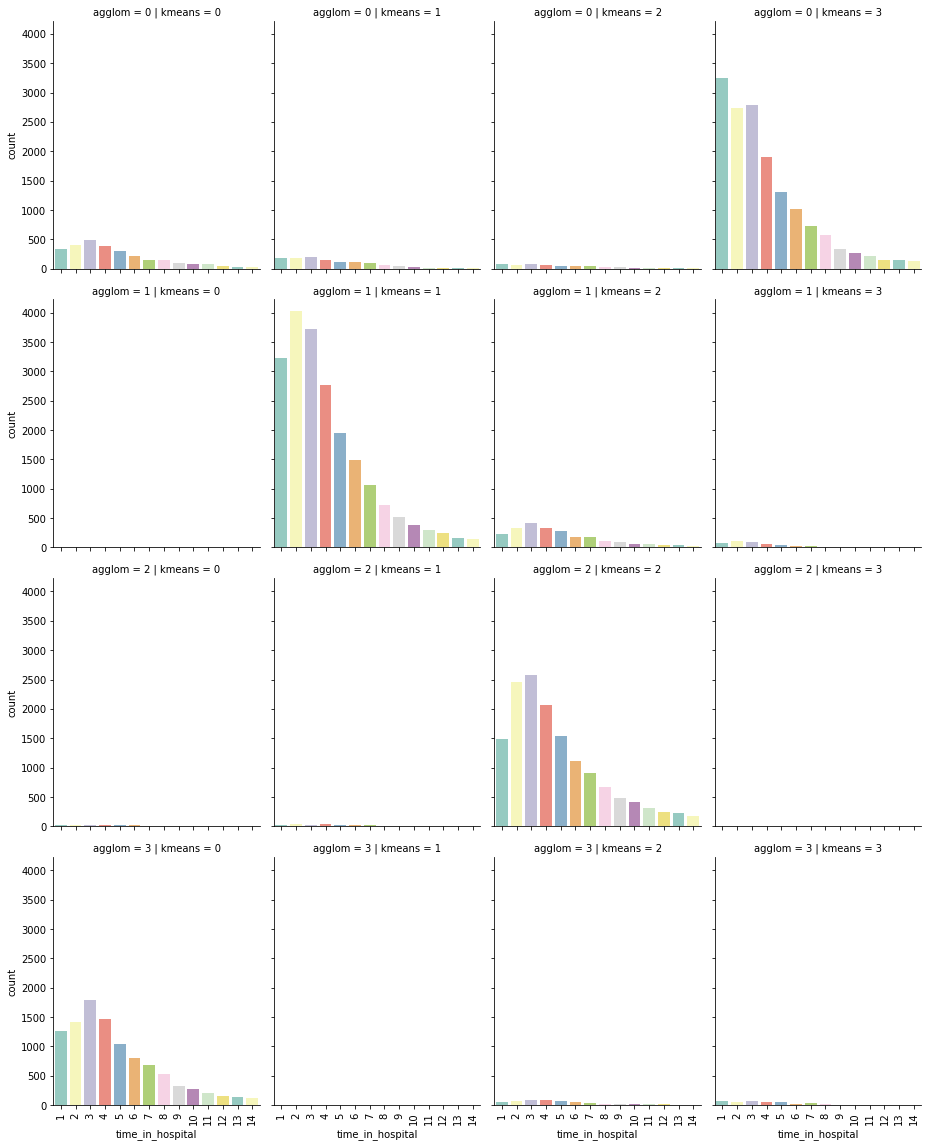

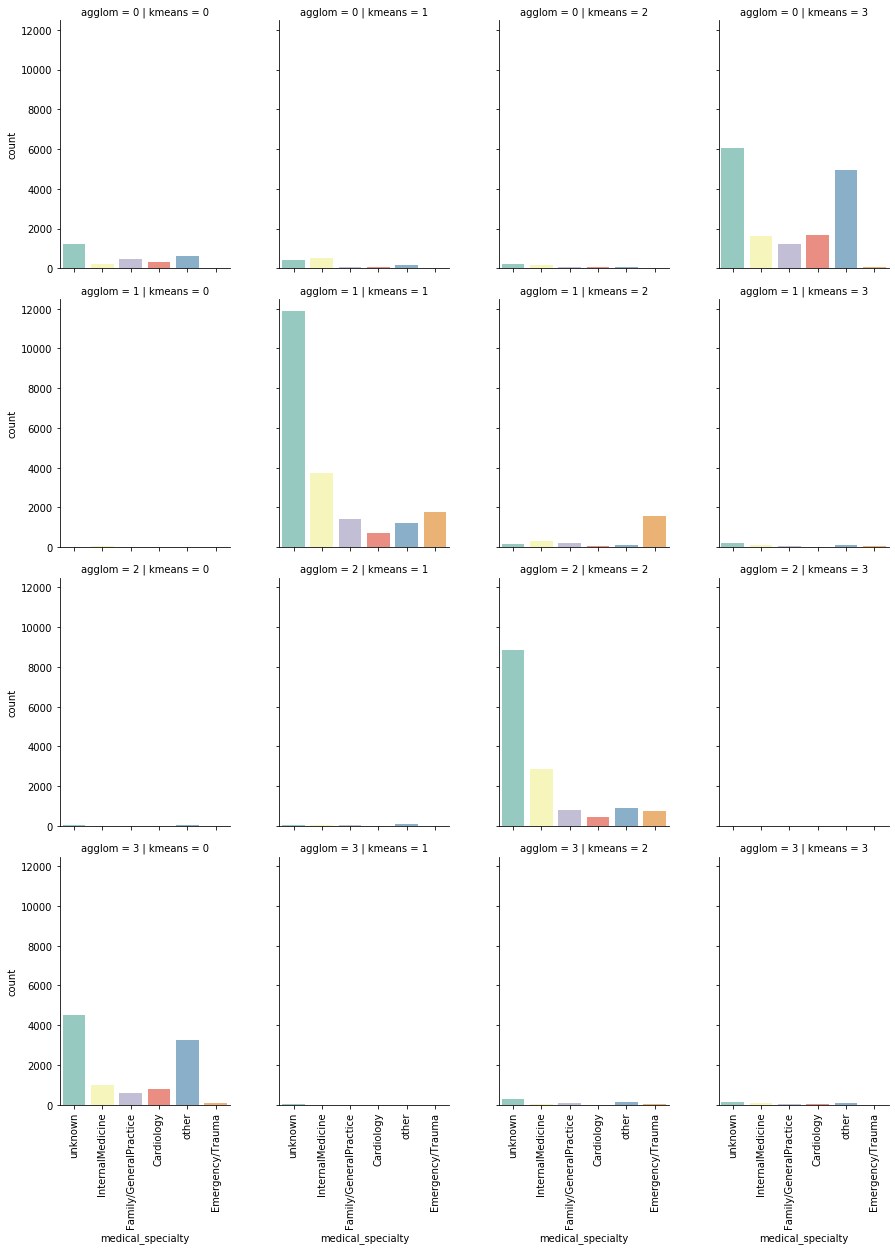

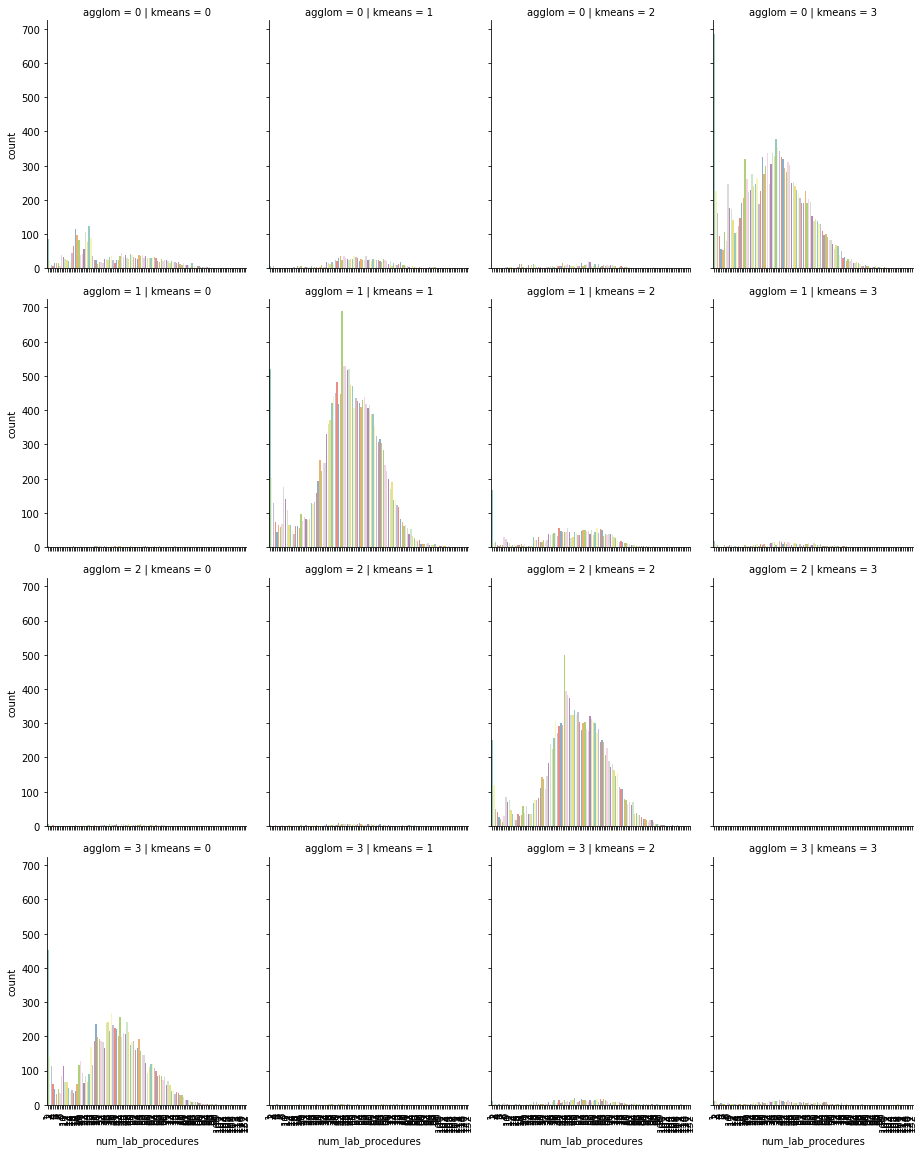

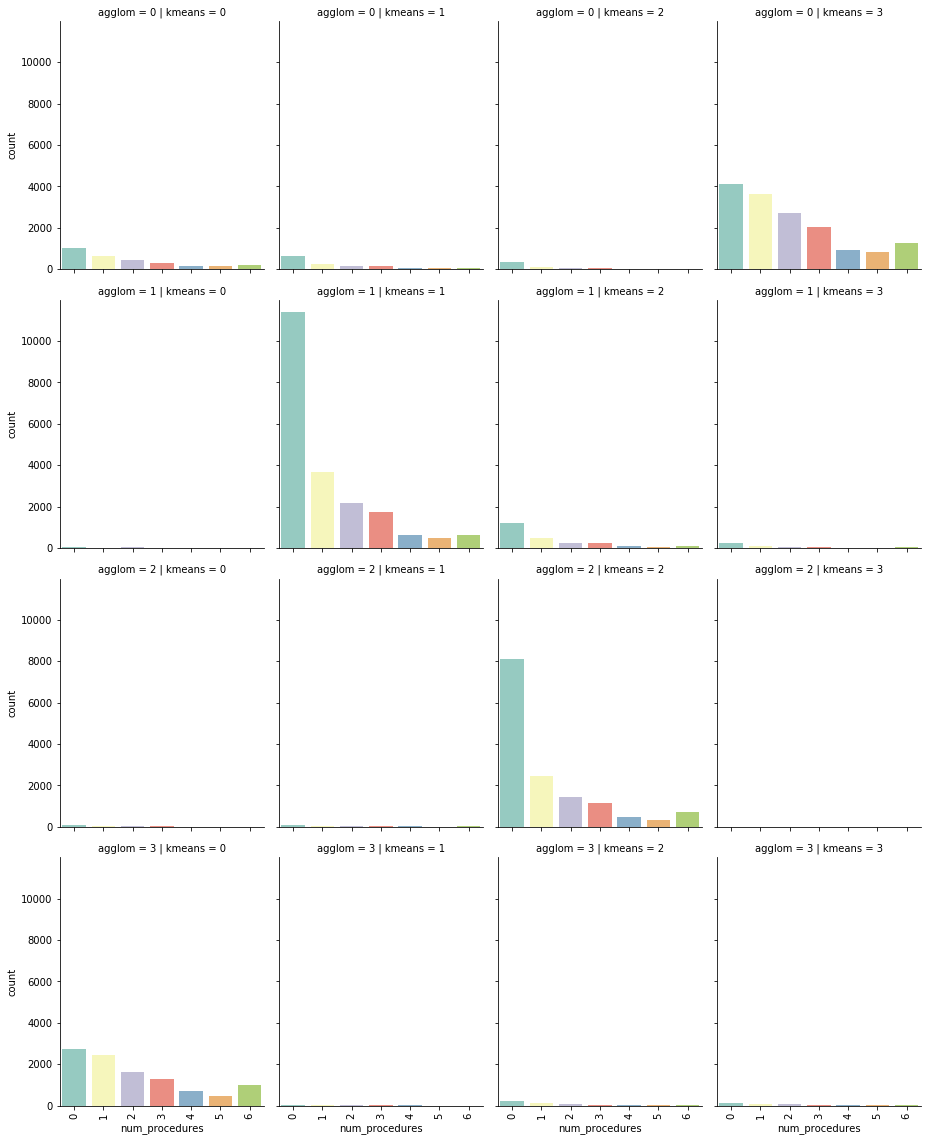

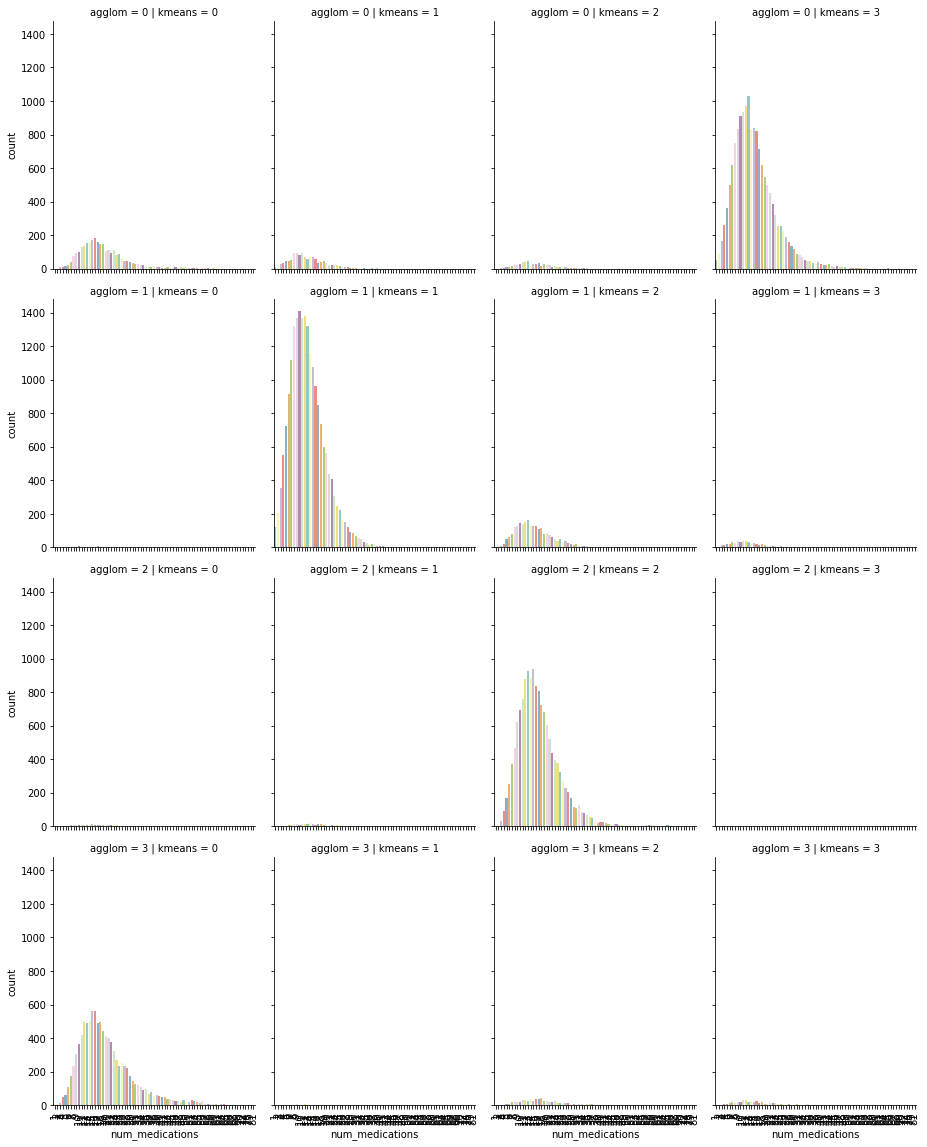

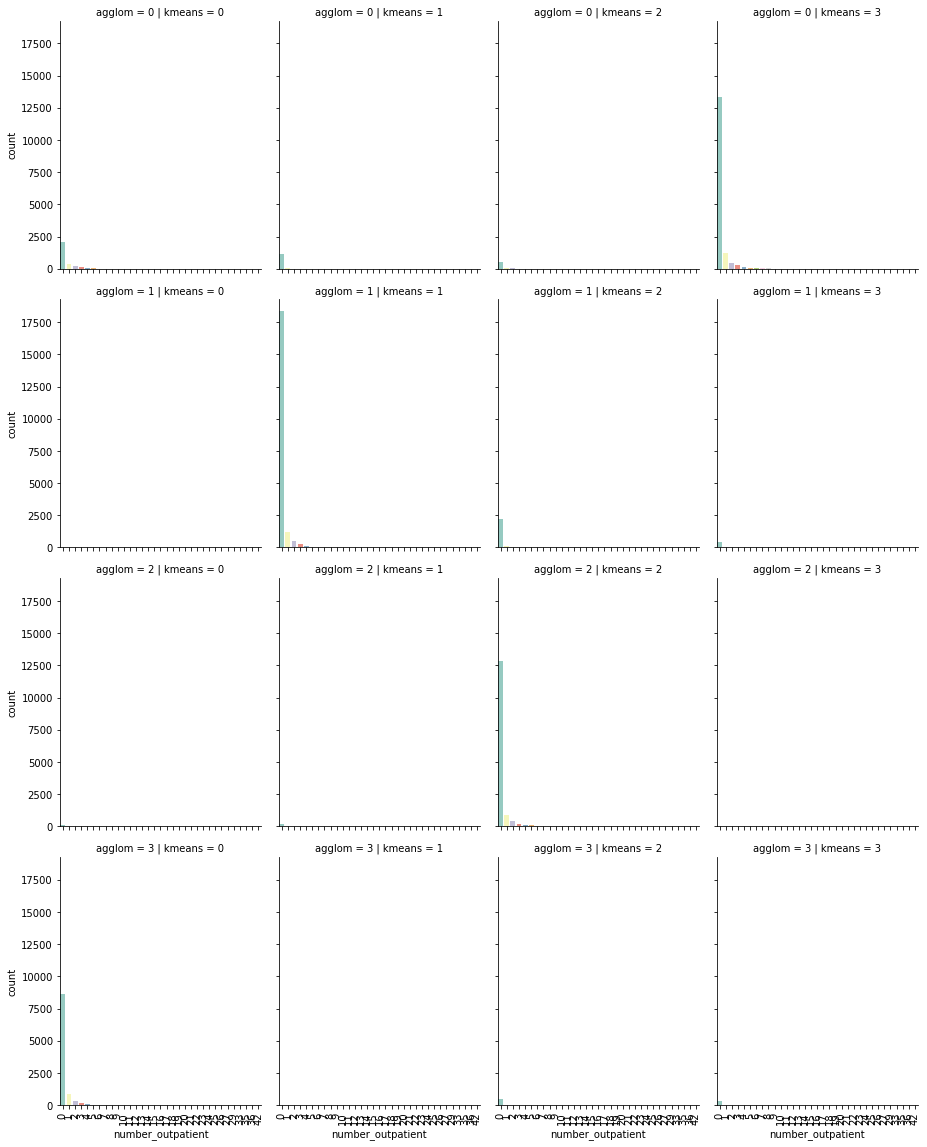

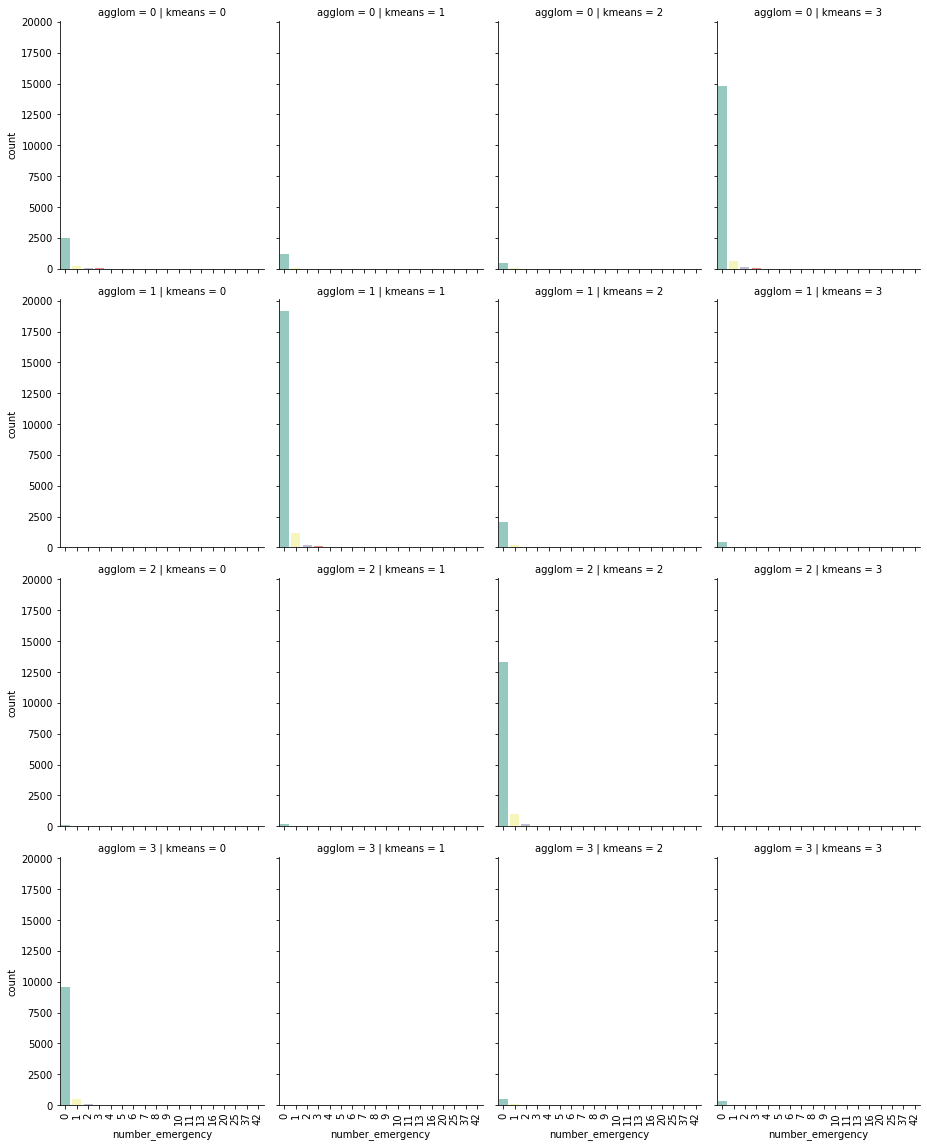

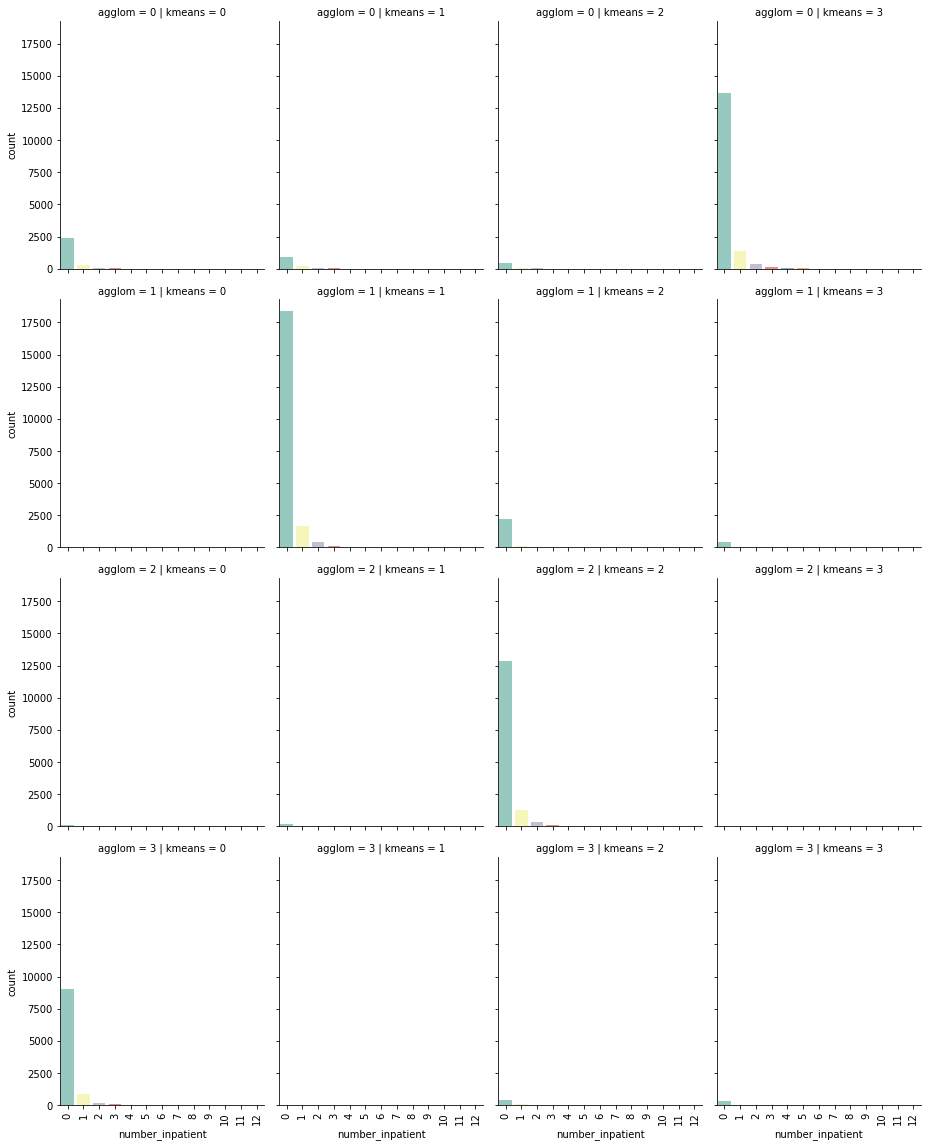

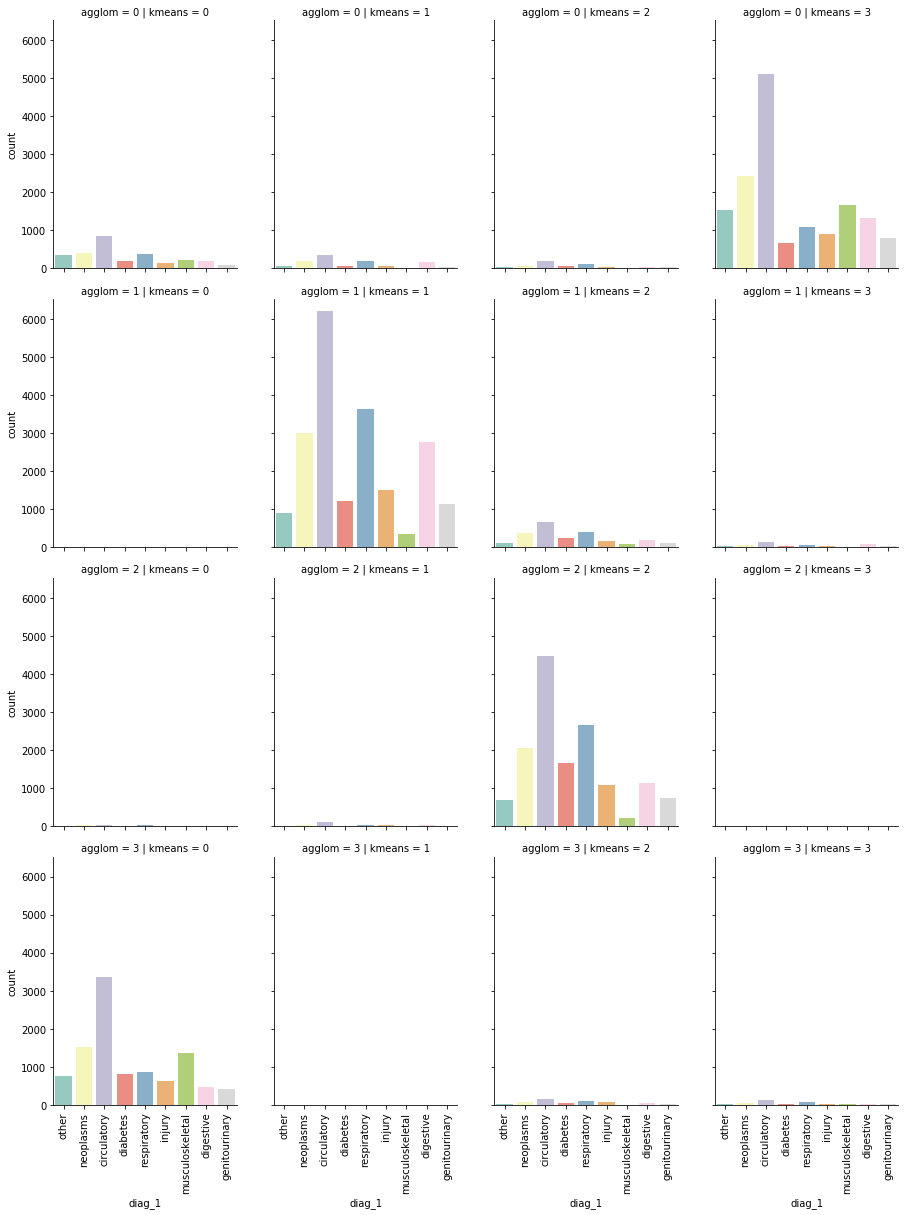

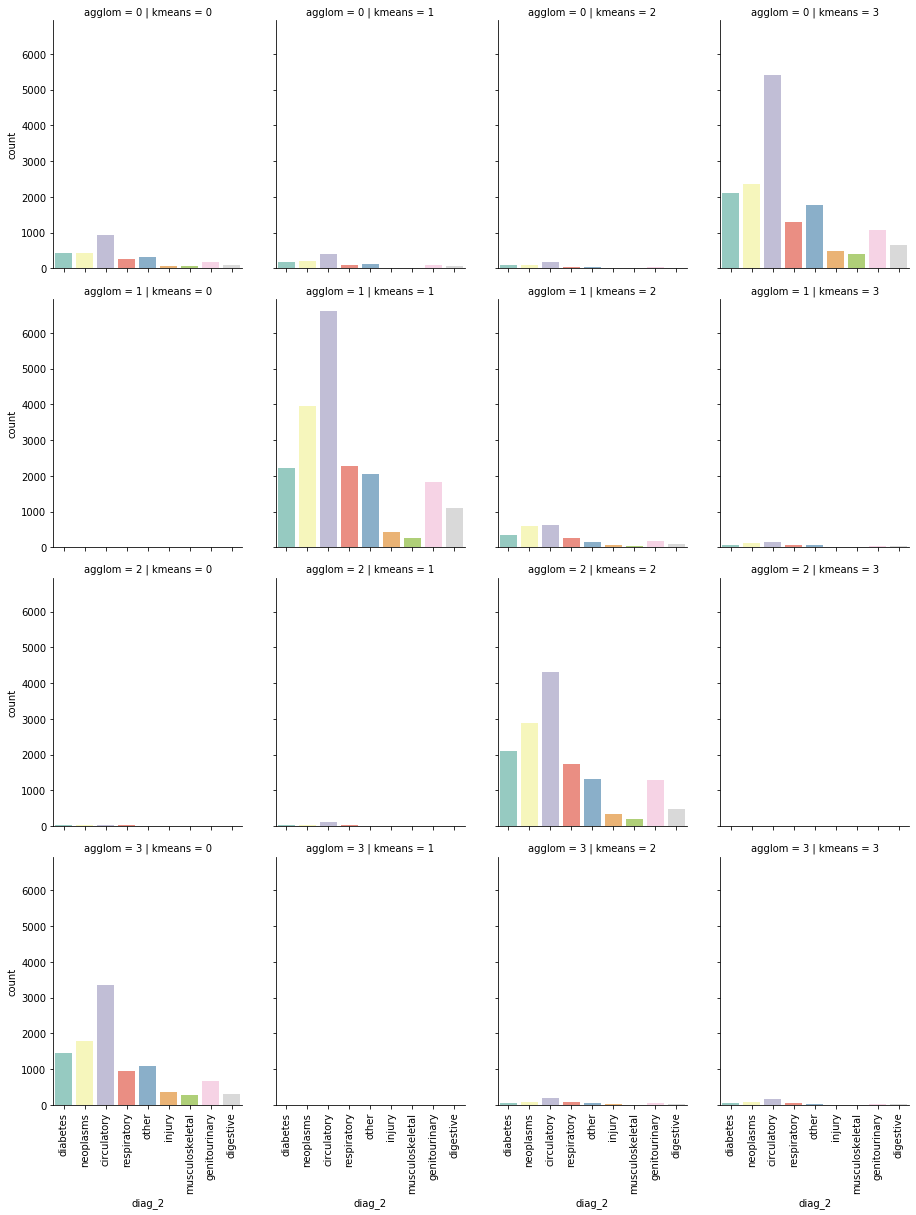

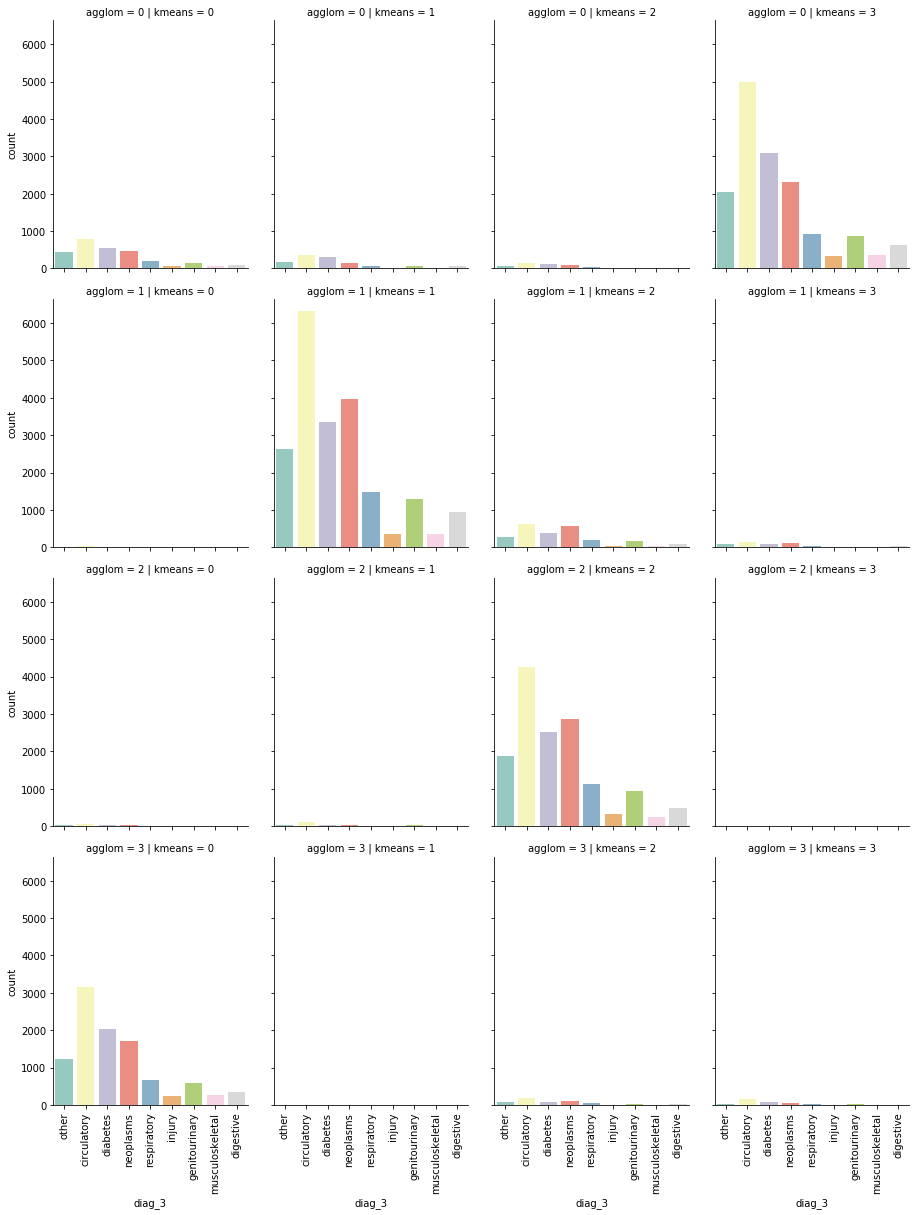

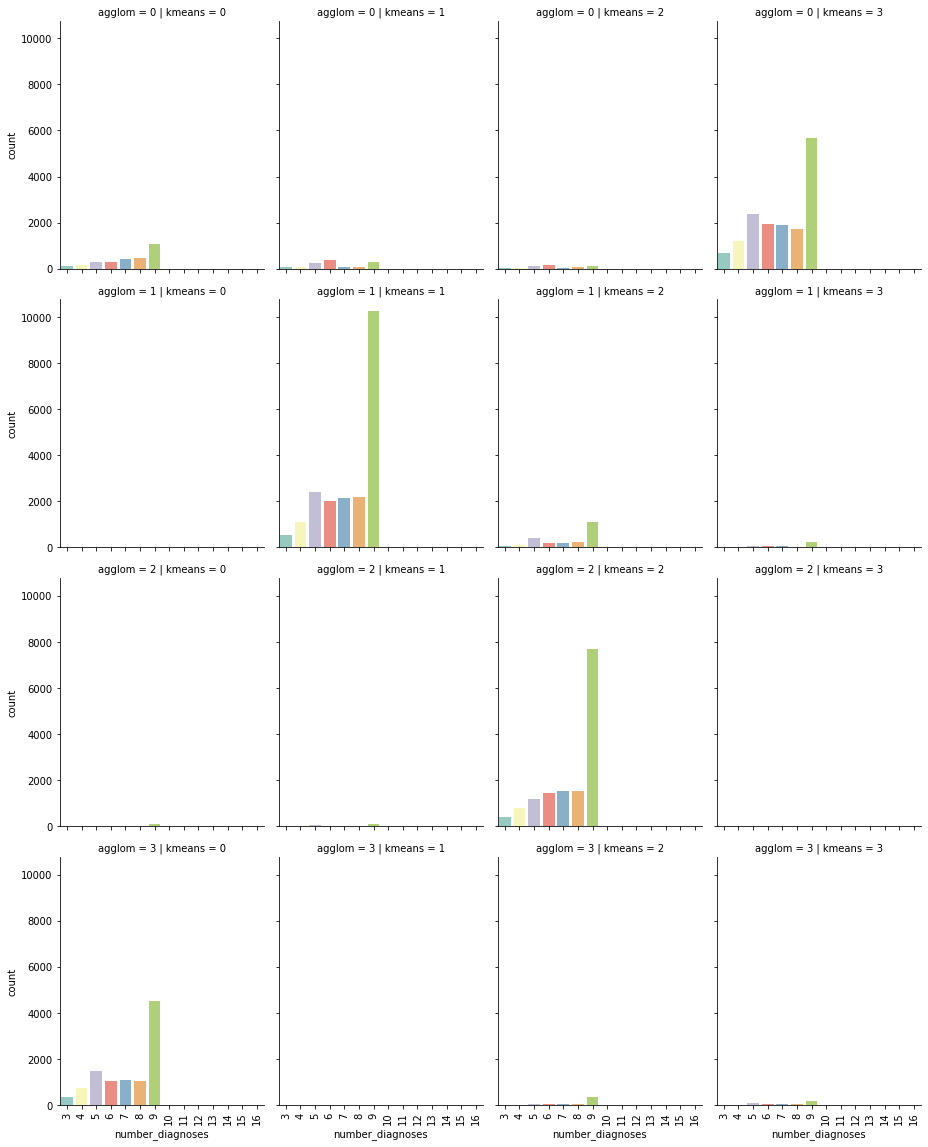

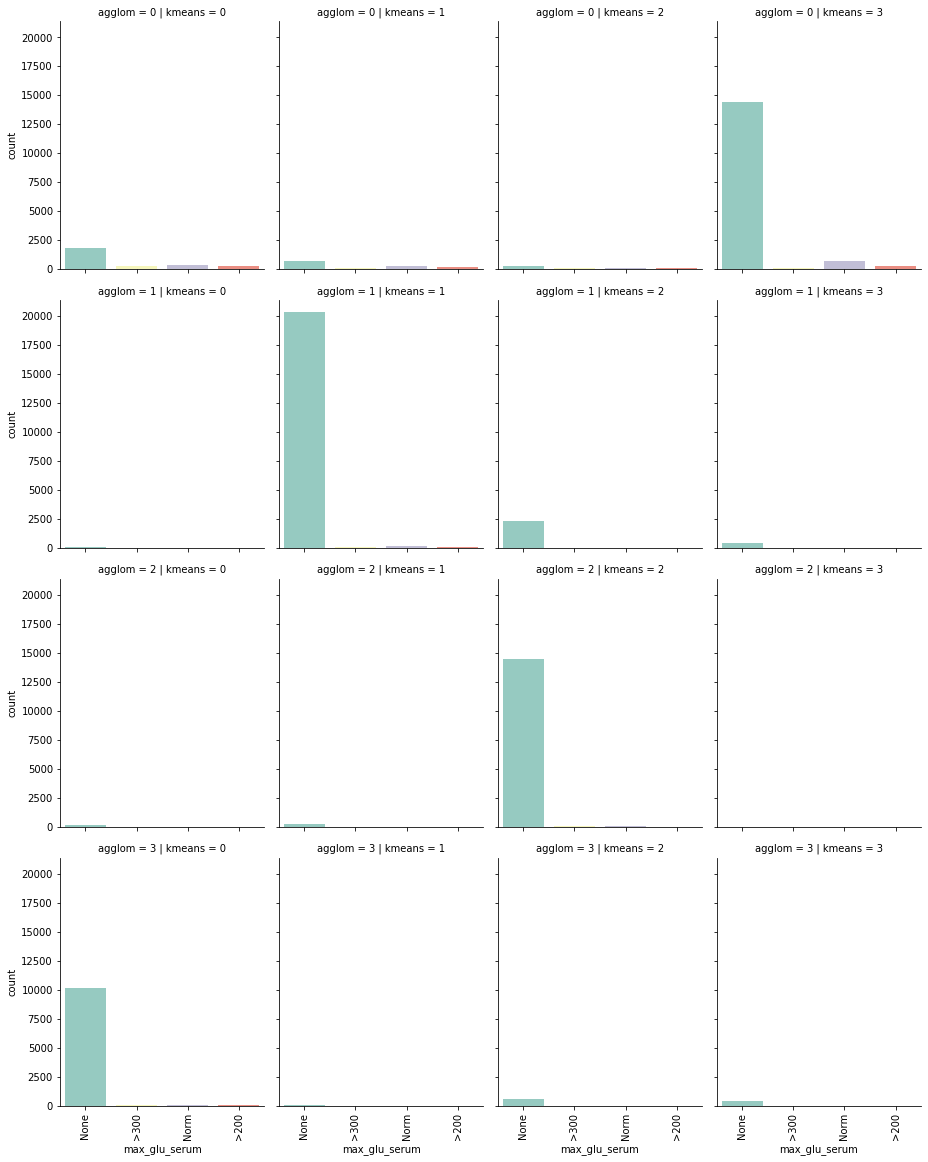

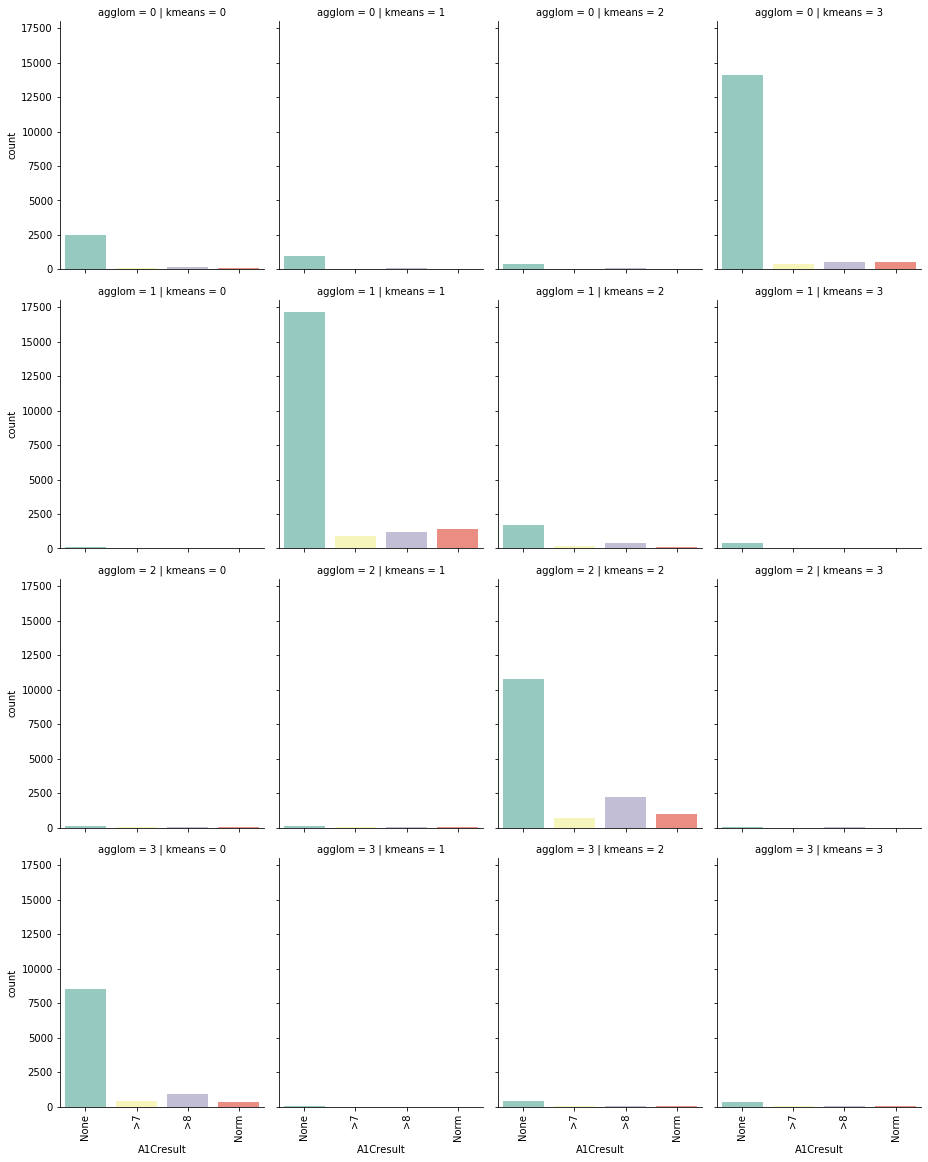

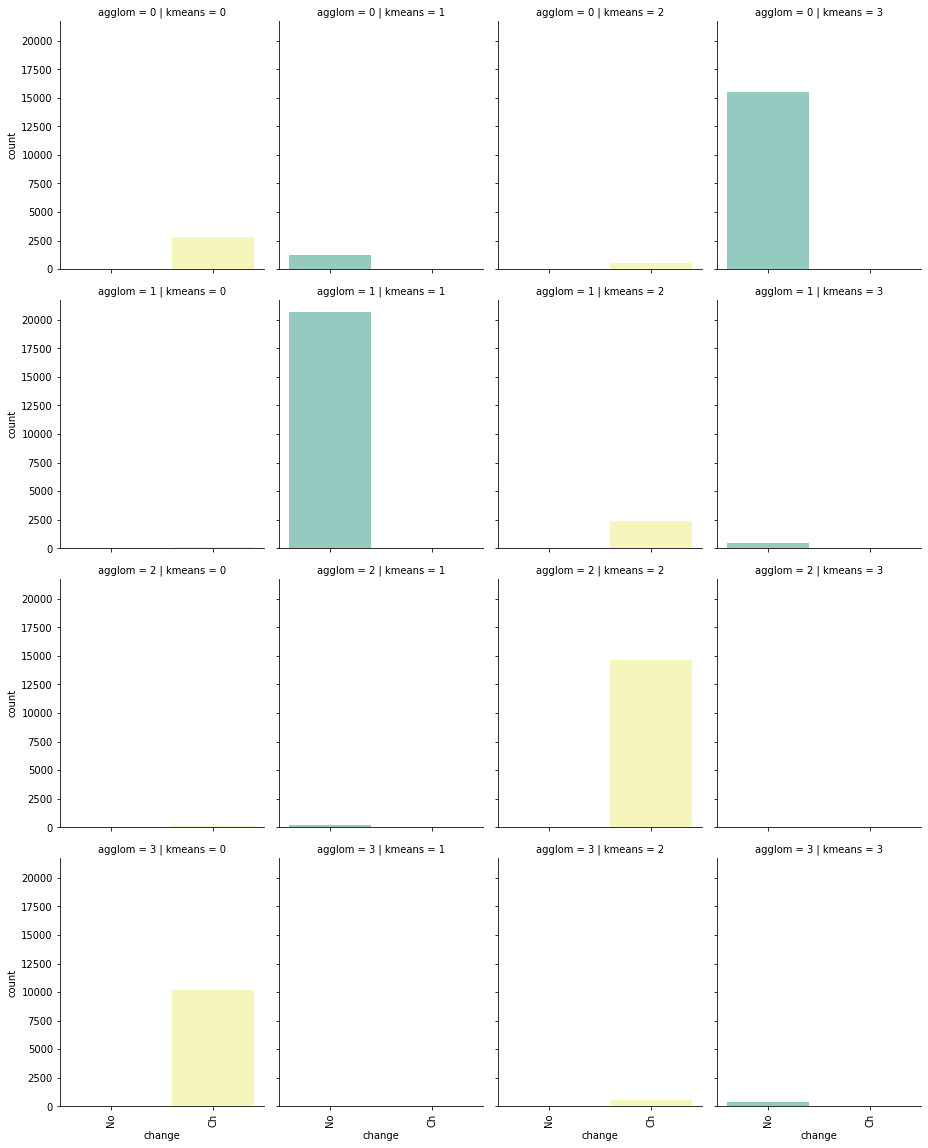

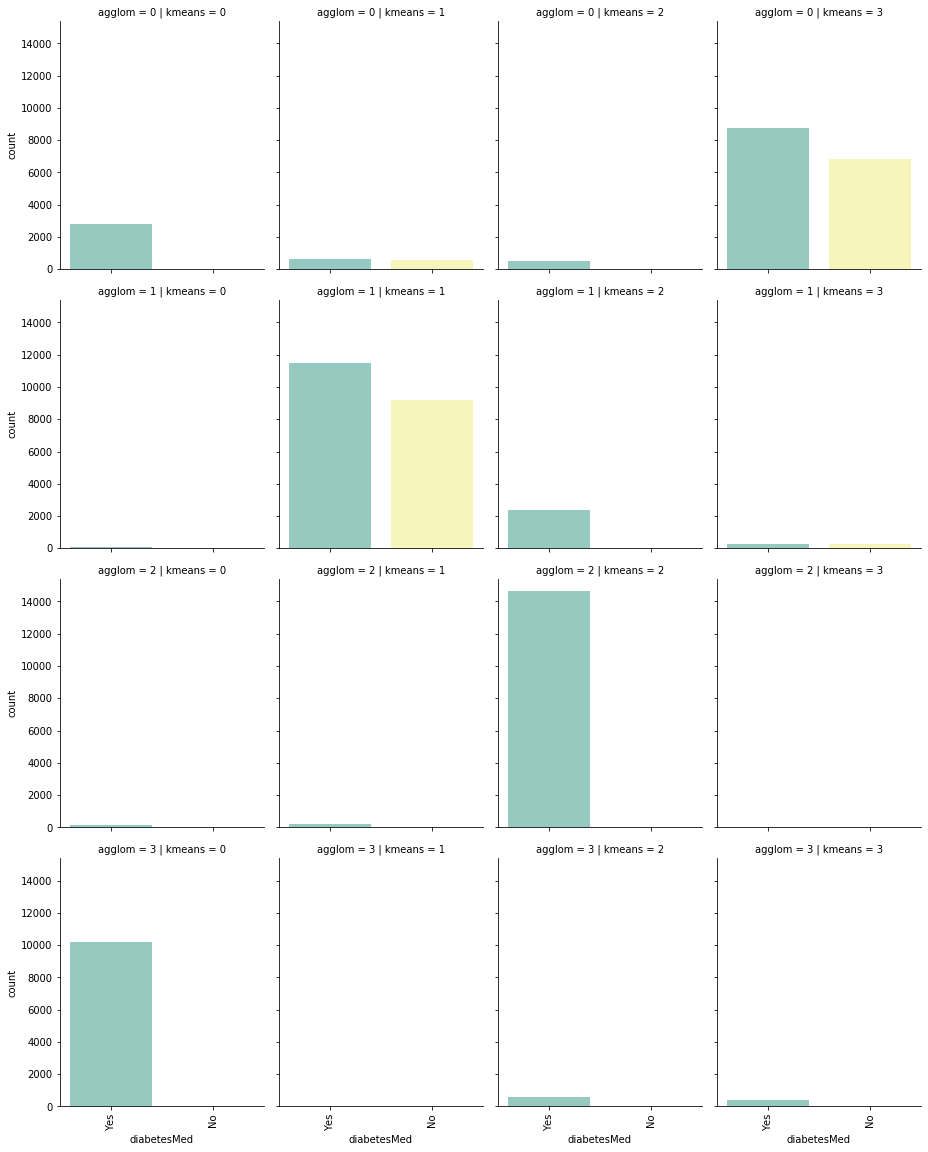

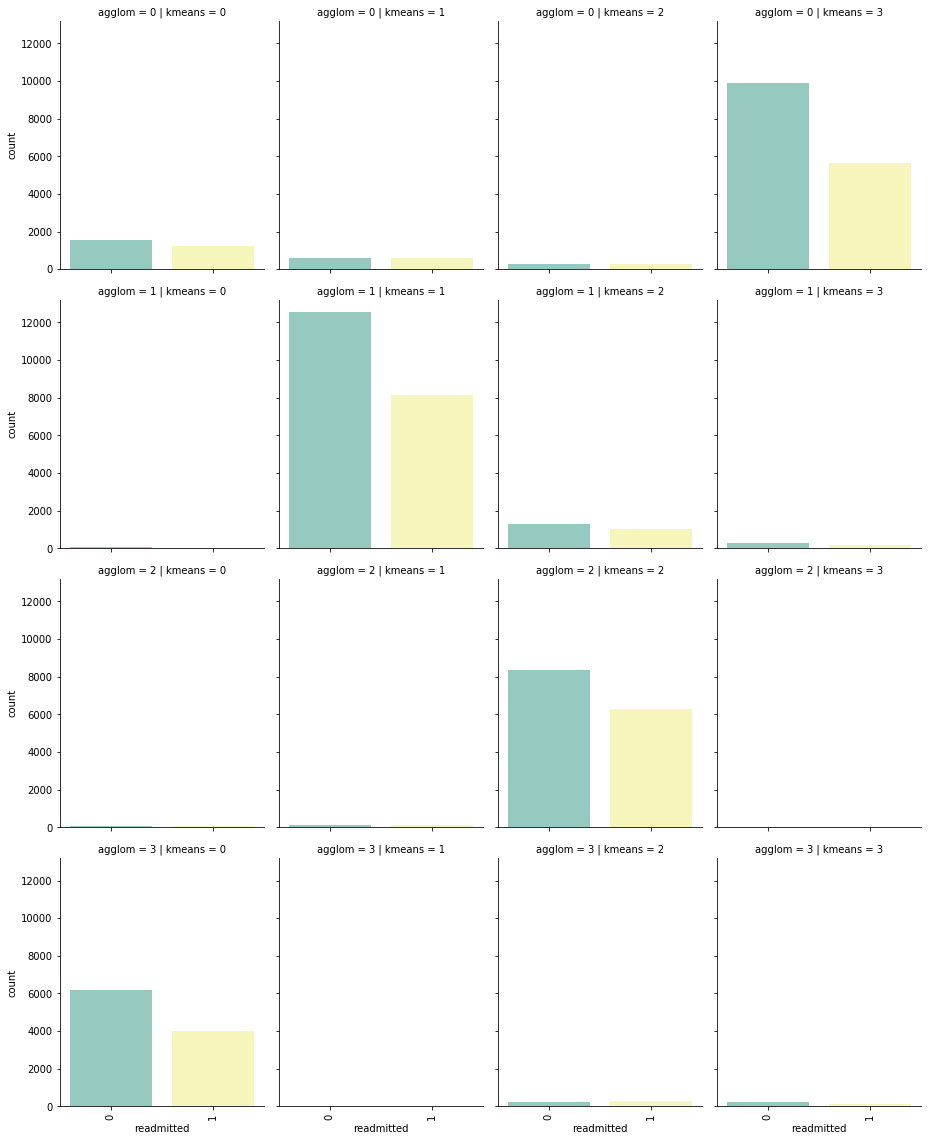

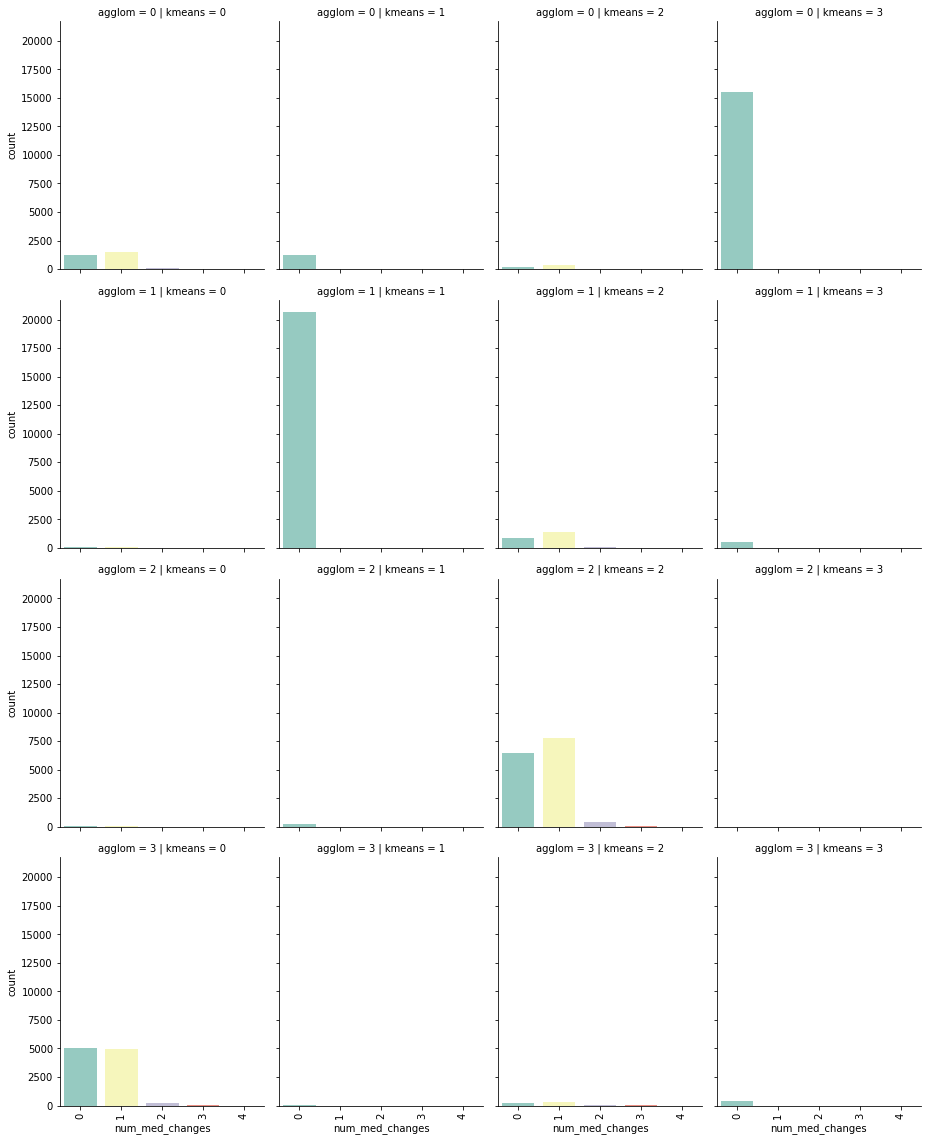

In [51]:
# same features from above we want to plot

columns_to_plot = include

# for loop that will plot a categorical plot for each feature
# k-means will be the columns
# agglom will be the rows
for c in columns_to_plot:

    cat = sns.catplot(x=c, kind='count', col='kmeans', row='agglom', data=dfanalysis, palette='Set3', 
                  height=4, aspect=0.8)
    cat.set_xticklabels(rotation=90)

These are much better at informing us the distinct clusters that we can identify via cluster labels. In summary, the four distinct clusters that both K-Means and Agglomerative have found are (as denoted by cluster labels, K = K-Means and A = Agglomerative):
- k3a0
- k1a1
- k2a2
- k0a3

These will be the four clusters we focus on in the following analysis.

In [153]:
# create dataframes for each of the four clusters to make analysis easier

k3a0 = dfanalysis[(dfanalysis['kmeans']==3) & (dfanalysis['agglom']==0)]

k1a1 = dfanalysis[(dfanalysis['kmeans']==1) & (dfanalysis['agglom']==1)]

k2a2 = dfanalysis[(dfanalysis['kmeans']==2) & (dfanalysis['agglom']==2)]

k0a3 = dfanalysis[(dfanalysis['kmeans']==0) & (dfanalysis['agglom']==3)]

In [154]:
# return shape of each cluster

display(f'K3A0 cluster shape: {k3a0.shape}')
display(f'K1A1 cluster shape: {k1a1.shape}')
display(f'K2A2 cluster shape: {k2a2.shape}')
display(f'K0A3 cluster shape: {k0a3.shape}')

'K3A0 cluster shape: (15544, 30)'

'K1A1 cluster shape: (20702, 30)'

'K2A2 cluster shape: (14653, 30)'

'K0A3 cluster shape: (10211, 30)'

In [54]:
# check proportion of readmitted

k3a0['readmitted'].value_counts(normalize=True)

0    0.636451
1    0.363549
Name: readmitted, dtype: float64

In [55]:
# check proportion of readmitted

k1a1['readmitted'].value_counts(normalize=True)

0    0.606705
1    0.393295
Name: readmitted, dtype: float64

In [56]:
# check proportion of readmitted

k2a2['readmitted'].value_counts(normalize=True)

0    0.570805
1    0.429195
Name: readmitted, dtype: float64

In [57]:
# check proportion of readmitted

k0a3['readmitted'].value_counts(normalize=True)

0    0.606503
1    0.393497
Name: readmitted, dtype: float64

A couple observations:
- k2a2 has ~43% readmitted, the highest proportion compared to other combinations of clusters. Its cluster size ranks 3rd from largest to smallest.
- k3a0 has ~36% readmitted, the lowest proportion compared to other combinations of clusters. Its cluster size ranks 2nd from largest to smallest.

Now, we've noted from the categorical plots that `admission_source_id` is a variable that differentiates the clusters. Let's see how it relates to `race` and `readmitted`.

In [66]:
# get a count of readmitted values, grouped by race and admission_source_id
# rename the count column
# reset_index to have race as its own column, not as index

k3a0_admission = k3a0.groupby(['race','admission_source_id'])['readmitted'].value_counts().rename('count').reset_index()

In [74]:
# create a new percentage column to get the proportions across combinations of race/readmission_source_id/readmitted

k3a0_admission['percent'] = (k3a0_admission['count'] / k3a0.shape[0])*100

# sort the percentages from largest to least

k3a0_admission.sort_values(by=['percent'], ascending=False)

,race,admission_source_id,readmitted,count,percent
4,Caucasian,physician_referral,0,5495,35.351261
5,Caucasian,physician_referral,1,3147,20.245754
14,Non_Caucasian,physician_referral,0,1638,10.537828
8,Caucasian,unknown,0,1240,7.977355
9,Caucasian,unknown,1,955,6.143850
15,Non_Caucasian,physician_referral,1,787,5.063047
6,Caucasian,transfer,0,780,5.018013
7,Caucasian,transfer,1,320,2.058672
16,Non_Caucasian,transfer,0,232,1.492537
18,Non_Caucasian,unknown,0,222,1.428204


In [77]:
# get a count of readmitted values, grouped by race and admission_source_id
# rename the count column
# reset_index to have race as its own column, not as index

k1a1_admission = k1a1.groupby(['race','admission_source_id'])['readmitted'].value_counts().rename('count').reset_index()

In [78]:
# create a new percentage column to get the proportions across combinations of race/readmission_source_id/readmitted

k1a1_admission['percent'] = (k1a1_admission['count'] / k1a1.shape[0])*100

# sort the percentages from largest to least

k1a1_admission.sort_values(by=['percent'], ascending=False)

,race,admission_source_id,readmitted,count,percent
0,Caucasian,emergency_room,0,8229,39.749783
1,Caucasian,emergency_room,1,5736,27.707468
10,Non_Caucasian,emergency_room,0,3106,15.003381
11,Non_Caucasian,emergency_room,1,1946,9.400058
6,Caucasian,transfer,0,628,3.033523
16,Non_Caucasian,transfer,0,356,1.719641
7,Caucasian,transfer,1,221,1.067530
17,Non_Caucasian,transfer,1,125,0.603806
8,Caucasian,unknown,0,98,0.473384
2,Caucasian,other,0,54,0.260844


In [58]:
# get a count of readmitted values, grouped by race and admission_source_id
# rename the count column
# reset_index to have race as its own column, not as index

k2a2_admission = k2a2.groupby(['race','admission_source_id'])['readmitted'].value_counts().rename('count').reset_index()

In [59]:
# create a new percentage column to get the proportions across combinations of race/readmission_source_id/readmitted

k2a2_admission['percent'] = (k2a2_admission['count'] / k2a2.shape[0])*100

# sort the percentages from largest to least

k2a2_admission.sort_values(by=['percent'], ascending=False)

,race,admission_source_id,readmitted,count,percent
0,Caucasian,emergency_room,0,5540,37.807957
1,Caucasian,emergency_room,1,4548,31.038013
10,Non_Caucasian,emergency_room,0,2568,17.525421
11,Non_Caucasian,emergency_room,1,1613,11.007985
6,Caucasian,transfer,0,79,0.539139
16,Non_Caucasian,transfer,0,59,0.402648
8,Caucasian,unknown,0,52,0.354876
7,Caucasian,transfer,1,35,0.238859
2,Caucasian,other,0,30,0.204736
17,Non_Caucasian,transfer,1,27,0.184263


In [97]:
# get a count of readmitted values, grouped by race and admission_source_id
# rename the count column
# reset_index to have race as its own column, not as index

k0a3_admission = k0a3.groupby(['race','admission_source_id'])['readmitted'].value_counts().rename('count').reset_index()

In [98]:
# create a new percentage column to get the proportions across combinations of race/readmission_source_id/readmitted

k0a3_admission['percent'] = (k0a3_admission['count'] / k0a3.shape[0])*100

# sort the percentages from largest to least

k0a3_admission.sort_values(by=['percent'], ascending=False)

,race,admission_source_id,readmitted,count,percent
4,Caucasian,physician_referral,0,4086,40.015669
5,Caucasian,physician_referral,1,2878,28.185290
13,Non_Caucasian,physician_referral,0,1231,12.055626
14,Non_Caucasian,physician_referral,1,725,7.100186
6,Caucasian,transfer,0,425,4.162178
15,Non_Caucasian,transfer,0,170,1.664871
7,Caucasian,transfer,1,159,1.557144
2,Caucasian,other,0,139,1.361277
3,Caucasian,other,1,85,0.832436
11,Non_Caucasian,other,0,76,0.744295


Since we know from the initial EDA that Caucasians make up ~75% of the entire dataset, it's not surprising that across these four clusters, the proportions of Caucasians being readmitted are consistently higher. We also note again that the clusters are not cleanly divided between `admission_source_id`'s, but "emergency" or "physician referral" make up the majority of the clusters that we'll mainly refer to these respective clusters' `admission_source_id` as "emergency" or "physician referral". In summary, these are interesting to note but not sufficient to have us make further conclusions about the clusters themselves. It does lead us to the next question; if we are to categorize the clusters based on additional variables we can see in the categorical plots, what else can we learn about the clusters?

Here is what we know so far:
- k3a0: main `admission_source_id` = 'physician referral'
- k1a1: main `admission_source_id` = 'emergency room'
- k2a2: main `admission_source_id` = 'emergency room'
- k0a3: main `admission_source_id` = 'physician referral'

And after reviewing the categorical plots for each feature across these four clusters, we can sum up the below:

|   cluster  |  k3a0  |   k1a1  |  k2a2  |   k0a3  | 
| --------- |:---:|:---:|:---:|:---:|
|admission_source| physician referral | emergency | emergency | physician referral | 
|num_med_changes|0 |0 | 1+ | 1+ |
|diabetesMed| yes or no | yes or no | yes |yes |
|change| no | no | yes | yes |
|readmission=1 %| 36 | 39 | 43 | 39 |

It's clear that there are distinctions among these four clusters; differences are found in the `admission_source_id` and in the diabetic treatments administered during the hospital visit, denoted by variables such as `num_med_changes`, `diabetesMed` and `change`.

### Conclusion and Next Steps in Classification

Now that we've found some patterns and structures across these four distinct clusters, we're going to proceed to classification. As part of our methodology, we need the classifier to predict `readmitted` and compare these predictions with the true `readmitted` values that are associated with each datapoint in the clusters, in order to find any algorithmic bias against particular clusters, if there's any.

References:

<sup>1</sup> https://scikit-learn.org/stable/modules/clustering.html#

<sup>2</sup> https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

<sup>3</sup> https://web.stanford.edu/~hastie/Papers/gap.pdf

<sup>4</sup> https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

<sup>5</sup> https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

<sup>6</sup> https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

<sup>7</sup> https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html?#condensed-trees

<sup>8</sup> https://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html